In [131]:
import pandas as pd
import zipfile
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

In [161]:
df_feat = pd.read_csv('feat_cup.csv', delimiter=',')
df_objects = pd.read_csv('objects_cup.csv', delimiter=',')

In [162]:
test_1 = df_objects[df_objects['owner_id'] != df_objects['holder_id']].drop_duplicates(subset =  ['owner_id','holder_id']).\
                                    drop_duplicates('holder_id').groupby('owner_id')['holder_id'].count().reset_index().\
    sort_values('holder_id', ascending = False).reset_index().rename(columns = {'owner_id':'client_id', 'holder_id':'col_holders'})

In [163]:
test_1.drop('index', axis=1, inplace=True)

In [164]:
df_feat = df_feat.merge(test_1, how='left', on='client_id')
df_feat['is_owner'] = df_feat.col_holders.apply(lambda x: 1 if x>0 else 0)
df_feat.drop('col_holders', axis=1, inplace=True)

In [165]:
categorial_features = df_feat.select_dtypes(include=['object']).columns.to_list()

df_feat = df_feat.drop_duplicates(subset='client_id', keep='last')
        
feat_eda = df_feat[categorial_features].drop(columns = (['client_id','dt']))

for i in feat_eda.columns:
    test_city = feat_eda[i].value_counts(normalize = True).reset_index().rename(columns = ({'index': 'city'}))
    city_list = test_city['city'].to_list()
    p_city_list = test_city[i].to_list()
    test_weight_city = pd.Series(np.random.choice(city_list, replace = True, p = p_city_list, size = feat_eda[i].isna().sum()))\
    .value_counts()
    target_weight = np.random.choice(city_list, replace = True, p = p_city_list, size = feat_eda[i].isna().sum()).tolist()
    new_values = pd.Series(target_weight, index=feat_eda.index[feat_eda[i].isna()])
    feat_eda[i].fillna(new_values, inplace=True)
if (len(feat_eda) == len(df_feat)) & (feat_eda.isna().sum().sum() == 0):
    print('Всё в норме, пропусков нет, длина исходного массива совпадает с получившимся')
else:
    print('Что-то пошло не так')

coder_other = []
for i in feat_eda.columns:
    if len(feat_eda[i].value_counts()) > 6:
        coder_other.append(i)
print(f'Претенденты на заполнение other {coder_other}')

feat_eda['country_coder'] = feat_eda['country'].apply(lambda x: 'RUS' if x == 'RUS' else 'OTHER')
feat_eda['clientoutflowstatus_coder'] = feat_eda['clientoutflowstatus'].apply(lambda x: 'ACTIVE' if x == 'ACTIVE' else 'OTHER')
addrref_check = feat_eda['addrref'].value_counts(normalize = True).reset_index()
addrref_small = addrref_check[addrref_check['addrref'] < 0.03]
addrref_small['checker'] = 'OTHER'
end_addrref = addrref_check.merge(addrref_small, on = ['index','addrref'], how = 'left')
end_addrref['checker'] = end_addrref['checker'].fillna(pd.Series(end_addrref['index'].values[:5]))
feat_eda = feat_eda.merge(end_addrref[['index','checker']], left_on = 'addrref', right_on = 'index').drop(columns = 'index')\
.rename(columns = {'checker':'addrref_coder'})
new_df_with_coders = feat_eda.drop(columns = (['country','addrref']))
new_df_with_coders = new_df_with_coders.drop(columns = ['clientoutflowstatus'])
new_df_with_coders = pd.get_dummies(new_df_with_coders)
df_feat_new_with_encoders = df_feat.drop(columns = categorial_features)\
            .merge(new_df_with_coders, left_index = True, right_index = True)
correlations = df_feat_new_with_encoders.corr().unstack().reset_index().rename(columns = {0:'correlations'})


Всё в норме, пропусков нет, длина исходного массива совпадает с получившимся
Претенденты на заполнение other ['country', 'clientoutflowstatus', 'srvpackage', 'addrref']


<ipython-input-165-a7d613a8223b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addrref_small['checker'] = 'OTHER'


In [166]:
stats_nan = df_feat_new_with_encoders.isna().sum().reset_index().rename(columns = {0:'count_nan'})
stats_nan['all'] = len(df_feat_new_with_encoders)
stats_nan['nan_percent'] = stats_nan['count_nan'] / stats_nan['all']
stats_nan = stats_nan.sort_values('nan_percent', ascending = False)
stats_filter_columns = stats_nan[stats_nan['nan_percent'] <= np.percentile(stats_nan['nan_percent'], 50)]
values_stats_nan = stats_filter_columns['index'].values
df_feat_new_with_encoders_without_high_nan = df_feat_new_with_encoders[values_stats_nan]

In [167]:
columns_to_drop_with_high_cor = correlations[(correlations['correlations'] < 1) & (correlations['correlations'] > 0.7)]\
                                                .drop_duplicates('level_0')['level_0'].values

In [168]:
df_feat_new_with_encoders_without_high_nan = df_feat_new_with_encoders_without_high_nan.drop(columns=[col for col in columns_to_drop_with_high_cor if col in df_feat_new_with_encoders_without_high_nan.columns])

In [169]:
df_feat_new_with_encoders_without_high_nan['is_owner'].value_counts()

0    186799
1     42234
Name: is_owner, dtype: int64

In [170]:
a = df_feat_new_with_encoders_without_high_nan.columns

In [171]:
fill0 = [i for i in a if i.startswith('transaction')]

In [172]:
fill0.append('by_category__amount__SUM__eoperation_type_name__perevod_po_nomeru_telefona')

In [173]:
fill0.extend([i for i in a if i.startswith('hdb')])

In [174]:
fill0.extend([i for i in a if i.startswith('avg')])

In [175]:
fill0.append('sal_rur_amt_curr_v2')

In [176]:
fill0.append('accountsalary_flag')

In [177]:
df_feat_new_with_encoders_without_high_nan[fill0] = \
                                df_feat_new_with_encoders_without_high_nan[fill0].fillna(0)

In [178]:
Y = df_feat_new_with_encoders_without_high_nan['is_owner']

In [179]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(df_feat_new_with_encoders_without_high_nan.drop('is_owner', axis=1))

### Без оверсемплинга

Baseline для выбора модели

In [47]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [48]:
classifiers = {
    "DummyClassifier_most_frequent": DummyClassifier(strategy='most_frequent', random_state=0),
    "LogisticRegression": LogisticRegression(solver = 'lbfgs', max_iter=10000),
    "XGBClassifier": XGBClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(3),    
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "GaussianNB": GaussianNB(),
    "CatBoostClassifier": CatBoostClassifier(),
    "LightGBM": LGBMClassifier()
}

In [49]:
df_models = pd.DataFrame(columns=['model','avg_pre', 'avg_pre_std', 
                                  'avg_f1', 'avg_f1_std','avg_acc', 'avg_acc_std'])

for key in classifiers:

    print('*',key)

    start_time = time.time()

    pipe = Pipeline([('scaler', StandardScaler()), ('classify', classifiers[key])])
    scorer = make_scorer(average_precision_score)
    cv_scores = cross_val_score(pipe, X_test, y_test, cv=5, scoring=scorer)
    scorer2 = make_scorer(f1_score)
    cv_scores2 = cross_val_score(pipe, X_test, y_test, cv=5, scoring=scorer2)
    scorer3 = make_scorer(accuracy_score)
    cv_scores3 = cross_val_score(pipe, X_test, y_test, cv=5, scoring=scorer3)

    row = {'model': key,
           'avg_pre': cv_scores.mean(),
           'avg_pre_std': cv_scores.std(),
           'avg_f1': cv_scores2.mean(),
           'avg_f1_std': cv_scores2.std(),
           'avg_acc': cv_scores3.mean(),
           'avg_acc_std': cv_scores3.std(),
    }

    df_models = df_models.append(row, ignore_index=True)

* DummyClassifier_most_frequent


<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* LogisticRegression


<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* XGBClassifier


<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* KNeighborsClassifier


<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* DecisionTreeClassifier


<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* RandomForestClassifier


<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* AdaBoostClassifier


<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* GradientBoostingClassifier


<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* GaussianNB


<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* CatBoostClassifier
Learning rate set to 0.059379
0:	learn: 0.6449293	total: 16.2ms	remaining: 16.1s
1:	learn: 0.6012982	total: 29.7ms	remaining: 14.8s
2:	learn: 0.5685158	total: 44ms	remaining: 14.6s
3:	learn: 0.5363683	total: 58.4ms	remaining: 14.5s
4:	learn: 0.5114756	total: 71.1ms	remaining: 14.1s
5:	learn: 0.4908109	total: 82.8ms	remaining: 13.7s
6:	learn: 0.4718923	total: 91.5ms	remaining: 13s
7:	learn: 0.4555150	total: 101ms	remaining: 12.5s
8:	learn: 0.4411357	total: 110ms	remaining: 12.2s
9:	learn: 0.4291394	total: 123ms	remaining: 12.2s
10:	learn: 0.4193089	total: 134ms	remaining: 12.1s
11:	learn: 0.4109019	total: 143ms	remaining: 11.8s
12:	learn: 0.4028173	total: 156ms	remaining: 11.8s
13:	learn: 0.3938813	total: 173ms	remaining: 12.2s
14:	learn: 0.3879326	total: 187ms	remaining: 12.3s
15:	learn: 0.3828944	total: 203ms	remaining: 12.5s
16:	learn: 0.3775763	total: 218ms	remaining: 12.6s
17:	learn: 0.3735515	total: 233ms	remaining: 12.7s
18:	learn: 0.3697424	total: 244ms	rema

171:	learn: 0.3124662	total: 2s	remaining: 9.64s
172:	learn: 0.3123825	total: 2.02s	remaining: 9.67s
173:	learn: 0.3122908	total: 2.04s	remaining: 9.69s
174:	learn: 0.3121365	total: 2.06s	remaining: 9.7s
175:	learn: 0.3120435	total: 2.07s	remaining: 9.71s
176:	learn: 0.3119158	total: 2.09s	remaining: 9.71s
177:	learn: 0.3118411	total: 2.1s	remaining: 9.69s
178:	learn: 0.3117722	total: 2.11s	remaining: 9.67s
179:	learn: 0.3116464	total: 2.12s	remaining: 9.67s
180:	learn: 0.3115375	total: 2.13s	remaining: 9.65s
181:	learn: 0.3114375	total: 2.14s	remaining: 9.63s
182:	learn: 0.3113417	total: 2.15s	remaining: 9.61s
183:	learn: 0.3112542	total: 2.16s	remaining: 9.59s
184:	learn: 0.3110635	total: 2.17s	remaining: 9.58s
185:	learn: 0.3109470	total: 2.19s	remaining: 9.56s
186:	learn: 0.3108539	total: 2.19s	remaining: 9.55s
187:	learn: 0.3107154	total: 2.21s	remaining: 9.54s
188:	learn: 0.3105896	total: 2.22s	remaining: 9.53s
189:	learn: 0.3105092	total: 2.23s	remaining: 9.51s
190:	learn: 0.310

349:	learn: 0.2947162	total: 3.82s	remaining: 7.09s
350:	learn: 0.2946718	total: 3.83s	remaining: 7.08s
351:	learn: 0.2945995	total: 3.83s	remaining: 7.06s
352:	learn: 0.2945137	total: 3.85s	remaining: 7.05s
353:	learn: 0.2944151	total: 3.85s	remaining: 7.03s
354:	learn: 0.2943033	total: 3.86s	remaining: 7.02s
355:	learn: 0.2942309	total: 3.87s	remaining: 7s
356:	learn: 0.2941603	total: 3.88s	remaining: 6.99s
357:	learn: 0.2940648	total: 3.89s	remaining: 6.97s
358:	learn: 0.2939794	total: 3.9s	remaining: 6.96s
359:	learn: 0.2939166	total: 3.9s	remaining: 6.94s
360:	learn: 0.2938350	total: 3.91s	remaining: 6.93s
361:	learn: 0.2937712	total: 3.92s	remaining: 6.92s
362:	learn: 0.2936385	total: 3.93s	remaining: 6.9s
363:	learn: 0.2935704	total: 3.94s	remaining: 6.89s
364:	learn: 0.2934983	total: 3.95s	remaining: 6.87s
365:	learn: 0.2934355	total: 3.96s	remaining: 6.86s
366:	learn: 0.2933524	total: 3.97s	remaining: 6.85s
367:	learn: 0.2932529	total: 3.98s	remaining: 6.83s
368:	learn: 0.2931

508:	learn: 0.2824958	total: 5.2s	remaining: 5.02s
509:	learn: 0.2824149	total: 5.21s	remaining: 5s
510:	learn: 0.2823406	total: 5.22s	remaining: 4.99s
511:	learn: 0.2823384	total: 5.22s	remaining: 4.98s
512:	learn: 0.2822831	total: 5.23s	remaining: 4.97s
513:	learn: 0.2822066	total: 5.24s	remaining: 4.96s
514:	learn: 0.2821477	total: 5.25s	remaining: 4.94s
515:	learn: 0.2820771	total: 5.26s	remaining: 4.93s
516:	learn: 0.2819936	total: 5.27s	remaining: 4.92s
517:	learn: 0.2819255	total: 5.28s	remaining: 4.91s
518:	learn: 0.2818372	total: 5.29s	remaining: 4.9s
519:	learn: 0.2817674	total: 5.29s	remaining: 4.89s
520:	learn: 0.2816907	total: 5.3s	remaining: 4.88s
521:	learn: 0.2815918	total: 5.31s	remaining: 4.86s
522:	learn: 0.2815392	total: 5.32s	remaining: 4.85s
523:	learn: 0.2814816	total: 5.33s	remaining: 4.84s
524:	learn: 0.2814142	total: 5.34s	remaining: 4.83s
525:	learn: 0.2813535	total: 5.35s	remaining: 4.82s
526:	learn: 0.2813043	total: 5.36s	remaining: 4.81s
527:	learn: 0.2812

671:	learn: 0.2715183	total: 6.8s	remaining: 3.32s
672:	learn: 0.2714369	total: 6.81s	remaining: 3.31s
673:	learn: 0.2713844	total: 6.82s	remaining: 3.3s
674:	learn: 0.2713827	total: 6.84s	remaining: 3.29s
675:	learn: 0.2713319	total: 6.85s	remaining: 3.28s
676:	learn: 0.2712430	total: 6.87s	remaining: 3.28s
677:	learn: 0.2712010	total: 6.88s	remaining: 3.27s
678:	learn: 0.2711366	total: 6.89s	remaining: 3.26s
679:	learn: 0.2710490	total: 6.9s	remaining: 3.25s
680:	learn: 0.2709452	total: 6.92s	remaining: 3.24s
681:	learn: 0.2709023	total: 6.93s	remaining: 3.23s
682:	learn: 0.2708455	total: 6.94s	remaining: 3.22s
683:	learn: 0.2707913	total: 6.95s	remaining: 3.21s
684:	learn: 0.2707262	total: 6.96s	remaining: 3.2s
685:	learn: 0.2706730	total: 6.97s	remaining: 3.19s
686:	learn: 0.2705791	total: 6.98s	remaining: 3.18s
687:	learn: 0.2705421	total: 6.99s	remaining: 3.17s
688:	learn: 0.2704977	total: 7s	remaining: 3.16s
689:	learn: 0.2704339	total: 7.02s	remaining: 3.15s
690:	learn: 0.27036

842:	learn: 0.2614394	total: 8.58s	remaining: 1.6s
843:	learn: 0.2613987	total: 8.59s	remaining: 1.59s
844:	learn: 0.2613524	total: 8.6s	remaining: 1.58s
845:	learn: 0.2612892	total: 8.61s	remaining: 1.57s
846:	learn: 0.2612537	total: 8.62s	remaining: 1.56s
847:	learn: 0.2611837	total: 8.63s	remaining: 1.55s
848:	learn: 0.2611312	total: 8.64s	remaining: 1.54s
849:	learn: 0.2610707	total: 8.65s	remaining: 1.53s
850:	learn: 0.2610254	total: 8.66s	remaining: 1.52s
851:	learn: 0.2609811	total: 8.67s	remaining: 1.51s
852:	learn: 0.2609072	total: 8.68s	remaining: 1.5s
853:	learn: 0.2608515	total: 8.69s	remaining: 1.49s
854:	learn: 0.2607811	total: 8.7s	remaining: 1.48s
855:	learn: 0.2607156	total: 8.71s	remaining: 1.47s
856:	learn: 0.2606470	total: 8.72s	remaining: 1.46s
857:	learn: 0.2605758	total: 8.73s	remaining: 1.45s
858:	learn: 0.2604966	total: 8.74s	remaining: 1.44s
859:	learn: 0.2604644	total: 8.75s	remaining: 1.42s
860:	learn: 0.2604036	total: 8.76s	remaining: 1.41s
861:	learn: 0.26

Learning rate set to 0.059379
0:	learn: 0.6419438	total: 23ms	remaining: 23s
1:	learn: 0.6018853	total: 33.2ms	remaining: 16.6s
2:	learn: 0.5690390	total: 41.3ms	remaining: 13.7s
3:	learn: 0.5368456	total: 50.6ms	remaining: 12.6s
4:	learn: 0.5115953	total: 60.4ms	remaining: 12s
5:	learn: 0.4905607	total: 69.9ms	remaining: 11.6s
6:	learn: 0.4711967	total: 84.7ms	remaining: 12s
7:	learn: 0.4545159	total: 93.5ms	remaining: 11.6s
8:	learn: 0.4410726	total: 102ms	remaining: 11.2s
9:	learn: 0.4293047	total: 111ms	remaining: 11s
10:	learn: 0.4193660	total: 121ms	remaining: 10.8s
11:	learn: 0.4104258	total: 130ms	remaining: 10.7s
12:	learn: 0.4027056	total: 138ms	remaining: 10.5s
13:	learn: 0.3937047	total: 148ms	remaining: 10.5s
14:	learn: 0.3874170	total: 157ms	remaining: 10.3s
15:	learn: 0.3824367	total: 167ms	remaining: 10.3s
16:	learn: 0.3782748	total: 175ms	remaining: 10.1s
17:	learn: 0.3740280	total: 184ms	remaining: 10s
18:	learn: 0.3702845	total: 193ms	remaining: 9.98s
19:	learn: 0.36

171:	learn: 0.3132389	total: 1.58s	remaining: 7.6s
172:	learn: 0.3131242	total: 1.59s	remaining: 7.6s
173:	learn: 0.3130408	total: 1.6s	remaining: 7.6s
174:	learn: 0.3129220	total: 1.61s	remaining: 7.59s
175:	learn: 0.3127269	total: 1.62s	remaining: 7.6s
176:	learn: 0.3125955	total: 1.64s	remaining: 7.61s
177:	learn: 0.3125029	total: 1.65s	remaining: 7.61s
178:	learn: 0.3124189	total: 1.65s	remaining: 7.59s
179:	learn: 0.3123209	total: 1.66s	remaining: 7.58s
180:	learn: 0.3122059	total: 1.68s	remaining: 7.58s
181:	learn: 0.3120993	total: 1.68s	remaining: 7.57s
182:	learn: 0.3118804	total: 1.69s	remaining: 7.55s
183:	learn: 0.3117365	total: 1.7s	remaining: 7.54s
184:	learn: 0.3116332	total: 1.71s	remaining: 7.53s
185:	learn: 0.3115202	total: 1.72s	remaining: 7.51s
186:	learn: 0.3114255	total: 1.73s	remaining: 7.5s
187:	learn: 0.3113532	total: 1.73s	remaining: 7.48s
188:	learn: 0.3112823	total: 1.74s	remaining: 7.47s
189:	learn: 0.3111493	total: 1.75s	remaining: 7.46s
190:	learn: 0.31104

337:	learn: 0.2967308	total: 3.18s	remaining: 6.22s
338:	learn: 0.2966555	total: 3.19s	remaining: 6.22s
339:	learn: 0.2965790	total: 3.2s	remaining: 6.21s
340:	learn: 0.2964720	total: 3.21s	remaining: 6.2s
341:	learn: 0.2964116	total: 3.22s	remaining: 6.19s
342:	learn: 0.2963133	total: 3.23s	remaining: 6.18s
343:	learn: 0.2962196	total: 3.24s	remaining: 6.17s
344:	learn: 0.2961300	total: 3.25s	remaining: 6.16s
345:	learn: 0.2960649	total: 3.25s	remaining: 6.15s
346:	learn: 0.2959911	total: 3.27s	remaining: 6.14s
347:	learn: 0.2959061	total: 3.27s	remaining: 6.13s
348:	learn: 0.2958528	total: 3.28s	remaining: 6.13s
349:	learn: 0.2958096	total: 3.29s	remaining: 6.11s
350:	learn: 0.2957123	total: 3.3s	remaining: 6.1s
351:	learn: 0.2956331	total: 3.31s	remaining: 6.09s
352:	learn: 0.2955591	total: 3.32s	remaining: 6.08s
353:	learn: 0.2954603	total: 3.33s	remaining: 6.07s
354:	learn: 0.2954284	total: 3.33s	remaining: 6.06s
355:	learn: 0.2953543	total: 3.35s	remaining: 6.05s
356:	learn: 0.29

505:	learn: 0.2835940	total: 4.79s	remaining: 4.67s
506:	learn: 0.2835273	total: 4.79s	remaining: 4.66s
507:	learn: 0.2834662	total: 4.8s	remaining: 4.65s
508:	learn: 0.2833790	total: 4.81s	remaining: 4.64s
509:	learn: 0.2832743	total: 4.82s	remaining: 4.63s
510:	learn: 0.2831637	total: 4.83s	remaining: 4.62s
511:	learn: 0.2830448	total: 4.84s	remaining: 4.61s
512:	learn: 0.2829696	total: 4.85s	remaining: 4.6s
513:	learn: 0.2828841	total: 4.86s	remaining: 4.59s
514:	learn: 0.2828102	total: 4.86s	remaining: 4.58s
515:	learn: 0.2827367	total: 4.87s	remaining: 4.57s
516:	learn: 0.2826622	total: 4.88s	remaining: 4.56s
517:	learn: 0.2825809	total: 4.89s	remaining: 4.55s
518:	learn: 0.2825321	total: 4.89s	remaining: 4.54s
519:	learn: 0.2824421	total: 4.9s	remaining: 4.53s
520:	learn: 0.2823753	total: 4.91s	remaining: 4.51s
521:	learn: 0.2823024	total: 4.92s	remaining: 4.5s
522:	learn: 0.2821988	total: 4.93s	remaining: 4.49s
523:	learn: 0.2821445	total: 4.94s	remaining: 4.48s
524:	learn: 0.28

671:	learn: 0.2720168	total: 6.39s	remaining: 3.12s
672:	learn: 0.2719430	total: 6.4s	remaining: 3.11s
673:	learn: 0.2718901	total: 6.41s	remaining: 3.1s
674:	learn: 0.2718367	total: 6.42s	remaining: 3.09s
675:	learn: 0.2717752	total: 6.43s	remaining: 3.08s
676:	learn: 0.2717177	total: 6.43s	remaining: 3.07s
677:	learn: 0.2716668	total: 6.44s	remaining: 3.06s
678:	learn: 0.2716218	total: 6.45s	remaining: 3.05s
679:	learn: 0.2715430	total: 6.46s	remaining: 3.04s
680:	learn: 0.2714700	total: 6.47s	remaining: 3.03s
681:	learn: 0.2714057	total: 6.48s	remaining: 3.02s
682:	learn: 0.2713269	total: 6.49s	remaining: 3.01s
683:	learn: 0.2712677	total: 6.5s	remaining: 3s
684:	learn: 0.2711829	total: 6.51s	remaining: 2.99s
685:	learn: 0.2711069	total: 6.52s	remaining: 2.98s
686:	learn: 0.2710585	total: 6.53s	remaining: 2.97s
687:	learn: 0.2709966	total: 6.54s	remaining: 2.96s
688:	learn: 0.2709372	total: 6.54s	remaining: 2.95s
689:	learn: 0.2708566	total: 6.55s	remaining: 2.94s
690:	learn: 0.2707

830:	learn: 0.2620636	total: 8s	remaining: 1.63s
831:	learn: 0.2620155	total: 8.01s	remaining: 1.62s
832:	learn: 0.2619591	total: 8.02s	remaining: 1.61s
833:	learn: 0.2619165	total: 8.03s	remaining: 1.6s
834:	learn: 0.2618181	total: 8.04s	remaining: 1.59s
835:	learn: 0.2617711	total: 8.05s	remaining: 1.58s
836:	learn: 0.2616970	total: 8.06s	remaining: 1.57s
837:	learn: 0.2616362	total: 8.07s	remaining: 1.56s
838:	learn: 0.2615917	total: 8.08s	remaining: 1.55s
839:	learn: 0.2615202	total: 8.09s	remaining: 1.54s
840:	learn: 0.2614571	total: 8.1s	remaining: 1.53s
841:	learn: 0.2613996	total: 8.1s	remaining: 1.52s
842:	learn: 0.2613161	total: 8.11s	remaining: 1.51s
843:	learn: 0.2612468	total: 8.12s	remaining: 1.5s
844:	learn: 0.2611653	total: 8.13s	remaining: 1.49s
845:	learn: 0.2611030	total: 8.14s	remaining: 1.48s
846:	learn: 0.2610511	total: 8.15s	remaining: 1.47s
847:	learn: 0.2610009	total: 8.16s	remaining: 1.46s
848:	learn: 0.2609464	total: 8.16s	remaining: 1.45s
849:	learn: 0.26089

Learning rate set to 0.059379
0:	learn: 0.6442499	total: 9.3ms	remaining: 9.3s
1:	learn: 0.6052058	total: 17.3ms	remaining: 8.61s
2:	learn: 0.5710500	total: 25.5ms	remaining: 8.47s
3:	learn: 0.5383814	total: 33.4ms	remaining: 8.31s
4:	learn: 0.5137143	total: 41.3ms	remaining: 8.22s
5:	learn: 0.4890273	total: 49.6ms	remaining: 8.22s
6:	learn: 0.4697734	total: 58.1ms	remaining: 8.24s
7:	learn: 0.4533754	total: 66.6ms	remaining: 8.26s
8:	learn: 0.4399171	total: 75.2ms	remaining: 8.28s
9:	learn: 0.4288196	total: 83.9ms	remaining: 8.3s
10:	learn: 0.4172794	total: 93.2ms	remaining: 8.38s
11:	learn: 0.4082677	total: 102ms	remaining: 8.38s
12:	learn: 0.4005084	total: 110ms	remaining: 8.35s
13:	learn: 0.3921455	total: 119ms	remaining: 8.35s
14:	learn: 0.3865852	total: 129ms	remaining: 8.46s
15:	learn: 0.3801812	total: 138ms	remaining: 8.47s
16:	learn: 0.3753635	total: 146ms	remaining: 8.45s
17:	learn: 0.3714969	total: 155ms	remaining: 8.43s
18:	learn: 0.3676977	total: 162ms	remaining: 8.39s
19:

176:	learn: 0.3119386	total: 1.81s	remaining: 8.4s
177:	learn: 0.3118472	total: 1.82s	remaining: 8.4s
178:	learn: 0.3117118	total: 1.84s	remaining: 8.43s
179:	learn: 0.3115960	total: 1.85s	remaining: 8.43s
180:	learn: 0.3114836	total: 1.86s	remaining: 8.42s
181:	learn: 0.3114060	total: 1.87s	remaining: 8.42s
182:	learn: 0.3112999	total: 1.89s	remaining: 8.43s
183:	learn: 0.3112354	total: 1.91s	remaining: 8.47s
184:	learn: 0.3111089	total: 1.93s	remaining: 8.52s
185:	learn: 0.3110202	total: 1.95s	remaining: 8.53s
186:	learn: 0.3108960	total: 2s	remaining: 8.68s
187:	learn: 0.3108198	total: 2.01s	remaining: 8.7s
188:	learn: 0.3106884	total: 2.05s	remaining: 8.79s
189:	learn: 0.3105987	total: 2.06s	remaining: 8.79s
190:	learn: 0.3104015	total: 2.08s	remaining: 8.79s
191:	learn: 0.3103199	total: 2.09s	remaining: 8.78s
192:	learn: 0.3102013	total: 2.1s	remaining: 8.77s
193:	learn: 0.3100829	total: 2.11s	remaining: 8.75s
194:	learn: 0.3099741	total: 2.12s	remaining: 8.75s
195:	learn: 0.30979

339:	learn: 0.2960065	total: 3.4s	remaining: 6.61s
340:	learn: 0.2959203	total: 3.41s	remaining: 6.6s
341:	learn: 0.2958245	total: 3.42s	remaining: 6.58s
342:	learn: 0.2957542	total: 3.43s	remaining: 6.57s
343:	learn: 0.2956687	total: 3.44s	remaining: 6.56s
344:	learn: 0.2955611	total: 3.45s	remaining: 6.55s
345:	learn: 0.2955146	total: 3.46s	remaining: 6.53s
346:	learn: 0.2954010	total: 3.46s	remaining: 6.52s
347:	learn: 0.2953196	total: 3.47s	remaining: 6.51s
348:	learn: 0.2952339	total: 3.48s	remaining: 6.5s
349:	learn: 0.2951329	total: 3.49s	remaining: 6.48s
350:	learn: 0.2950331	total: 3.5s	remaining: 6.47s
351:	learn: 0.2949266	total: 3.51s	remaining: 6.46s
352:	learn: 0.2948411	total: 3.52s	remaining: 6.45s
353:	learn: 0.2948248	total: 3.53s	remaining: 6.43s
354:	learn: 0.2947379	total: 3.53s	remaining: 6.42s
355:	learn: 0.2946686	total: 3.54s	remaining: 6.41s
356:	learn: 0.2945673	total: 3.55s	remaining: 6.4s
357:	learn: 0.2944681	total: 3.56s	remaining: 6.38s
358:	learn: 0.294

499:	learn: 0.2837055	total: 4.81s	remaining: 4.81s
500:	learn: 0.2836498	total: 4.82s	remaining: 4.8s
501:	learn: 0.2835802	total: 4.83s	remaining: 4.79s
502:	learn: 0.2834753	total: 4.84s	remaining: 4.78s
503:	learn: 0.2833757	total: 4.85s	remaining: 4.77s
504:	learn: 0.2833249	total: 4.86s	remaining: 4.76s
505:	learn: 0.2832565	total: 4.86s	remaining: 4.75s
506:	learn: 0.2831516	total: 4.87s	remaining: 4.74s
507:	learn: 0.2831028	total: 4.88s	remaining: 4.73s
508:	learn: 0.2830234	total: 4.89s	remaining: 4.72s
509:	learn: 0.2829643	total: 4.9s	remaining: 4.71s
510:	learn: 0.2828820	total: 4.91s	remaining: 4.7s
511:	learn: 0.2828285	total: 4.92s	remaining: 4.69s
512:	learn: 0.2827370	total: 4.93s	remaining: 4.68s
513:	learn: 0.2826630	total: 4.94s	remaining: 4.67s
514:	learn: 0.2826262	total: 4.95s	remaining: 4.66s
515:	learn: 0.2825520	total: 4.96s	remaining: 4.66s
516:	learn: 0.2824793	total: 4.97s	remaining: 4.65s
517:	learn: 0.2824147	total: 4.99s	remaining: 4.64s
518:	learn: 0.2

662:	learn: 0.2727606	total: 6.21s	remaining: 3.15s
663:	learn: 0.2727158	total: 6.21s	remaining: 3.14s
664:	learn: 0.2726833	total: 6.22s	remaining: 3.13s
665:	learn: 0.2726072	total: 6.23s	remaining: 3.12s
666:	learn: 0.2725358	total: 6.24s	remaining: 3.12s
667:	learn: 0.2724603	total: 6.25s	remaining: 3.11s
668:	learn: 0.2723786	total: 6.26s	remaining: 3.1s
669:	learn: 0.2723105	total: 6.27s	remaining: 3.09s
670:	learn: 0.2722261	total: 6.27s	remaining: 3.08s
671:	learn: 0.2721362	total: 6.28s	remaining: 3.07s
672:	learn: 0.2720645	total: 6.29s	remaining: 3.06s
673:	learn: 0.2720270	total: 6.3s	remaining: 3.05s
674:	learn: 0.2719477	total: 6.31s	remaining: 3.04s
675:	learn: 0.2718768	total: 6.32s	remaining: 3.03s
676:	learn: 0.2718206	total: 6.34s	remaining: 3.02s
677:	learn: 0.2717628	total: 6.35s	remaining: 3.01s
678:	learn: 0.2716992	total: 6.36s	remaining: 3s
679:	learn: 0.2716321	total: 6.37s	remaining: 3s
680:	learn: 0.2715770	total: 6.37s	remaining: 2.99s
681:	learn: 0.271525

843:	learn: 0.2617094	total: 7.79s	remaining: 1.44s
844:	learn: 0.2616821	total: 7.8s	remaining: 1.43s
845:	learn: 0.2616320	total: 7.81s	remaining: 1.42s
846:	learn: 0.2615749	total: 7.82s	remaining: 1.41s
847:	learn: 0.2615164	total: 7.82s	remaining: 1.4s
848:	learn: 0.2614407	total: 7.83s	remaining: 1.39s
849:	learn: 0.2613449	total: 7.84s	remaining: 1.38s
850:	learn: 0.2612863	total: 7.85s	remaining: 1.37s
851:	learn: 0.2612266	total: 7.86s	remaining: 1.36s
852:	learn: 0.2611478	total: 7.87s	remaining: 1.35s
853:	learn: 0.2610855	total: 7.88s	remaining: 1.35s
854:	learn: 0.2610216	total: 7.89s	remaining: 1.34s
855:	learn: 0.2609632	total: 7.89s	remaining: 1.33s
856:	learn: 0.2608812	total: 7.9s	remaining: 1.32s
857:	learn: 0.2608457	total: 7.91s	remaining: 1.31s
858:	learn: 0.2607759	total: 7.92s	remaining: 1.3s
859:	learn: 0.2607222	total: 7.93s	remaining: 1.29s
860:	learn: 0.2606524	total: 7.94s	remaining: 1.28s
861:	learn: 0.2605839	total: 7.95s	remaining: 1.27s
862:	learn: 0.26

20:	learn: 0.3617812	total: 201ms	remaining: 9.38s
21:	learn: 0.3594055	total: 216ms	remaining: 9.6s
22:	learn: 0.3570633	total: 228ms	remaining: 9.68s
23:	learn: 0.3550867	total: 238ms	remaining: 9.69s
24:	learn: 0.3527827	total: 247ms	remaining: 9.64s
25:	learn: 0.3510733	total: 257ms	remaining: 9.63s
26:	learn: 0.3495494	total: 267ms	remaining: 9.63s
27:	learn: 0.3479893	total: 276ms	remaining: 9.59s
28:	learn: 0.3466566	total: 287ms	remaining: 9.62s
29:	learn: 0.3455835	total: 296ms	remaining: 9.58s
30:	learn: 0.3444896	total: 306ms	remaining: 9.56s
31:	learn: 0.3428247	total: 316ms	remaining: 9.57s
32:	learn: 0.3416310	total: 329ms	remaining: 9.65s
33:	learn: 0.3409874	total: 340ms	remaining: 9.66s
34:	learn: 0.3401045	total: 352ms	remaining: 9.71s
35:	learn: 0.3394057	total: 362ms	remaining: 9.7s
36:	learn: 0.3385342	total: 371ms	remaining: 9.67s
37:	learn: 0.3377582	total: 382ms	remaining: 9.68s
38:	learn: 0.3372430	total: 392ms	remaining: 9.66s
39:	learn: 0.3367550	total: 403ms

194:	learn: 0.3101563	total: 2s	remaining: 8.24s
195:	learn: 0.3100301	total: 2.01s	remaining: 8.26s
196:	learn: 0.3099278	total: 2.03s	remaining: 8.28s
197:	learn: 0.3098187	total: 2.04s	remaining: 8.29s
198:	learn: 0.3096984	total: 2.06s	remaining: 8.29s
199:	learn: 0.3095816	total: 2.07s	remaining: 8.28s
200:	learn: 0.3094729	total: 2.08s	remaining: 8.29s
201:	learn: 0.3092638	total: 2.1s	remaining: 8.3s
202:	learn: 0.3091749	total: 2.11s	remaining: 8.3s
203:	learn: 0.3090638	total: 2.13s	remaining: 8.3s
204:	learn: 0.3089871	total: 2.14s	remaining: 8.3s
205:	learn: 0.3088252	total: 2.15s	remaining: 8.29s
206:	learn: 0.3087164	total: 2.16s	remaining: 8.29s
207:	learn: 0.3085852	total: 2.18s	remaining: 8.29s
208:	learn: 0.3084790	total: 2.19s	remaining: 8.28s
209:	learn: 0.3083850	total: 2.2s	remaining: 8.27s
210:	learn: 0.3083157	total: 2.21s	remaining: 8.28s
211:	learn: 0.3081872	total: 2.23s	remaining: 8.3s
212:	learn: 0.3081105	total: 2.24s	remaining: 8.29s
213:	learn: 0.3078980	

371:	learn: 0.2931316	total: 4.04s	remaining: 6.82s
372:	learn: 0.2930381	total: 4.05s	remaining: 6.81s
373:	learn: 0.2929725	total: 4.06s	remaining: 6.8s
374:	learn: 0.2928566	total: 4.07s	remaining: 6.79s
375:	learn: 0.2927499	total: 4.08s	remaining: 6.78s
376:	learn: 0.2926729	total: 4.09s	remaining: 6.76s
377:	learn: 0.2925915	total: 4.1s	remaining: 6.75s
378:	learn: 0.2925001	total: 4.11s	remaining: 6.73s
379:	learn: 0.2924453	total: 4.12s	remaining: 6.72s
380:	learn: 0.2923609	total: 4.13s	remaining: 6.7s
381:	learn: 0.2923587	total: 4.13s	remaining: 6.69s
382:	learn: 0.2922721	total: 4.14s	remaining: 6.67s
383:	learn: 0.2921710	total: 4.15s	remaining: 6.66s
384:	learn: 0.2920997	total: 4.16s	remaining: 6.64s
385:	learn: 0.2920278	total: 4.17s	remaining: 6.63s
386:	learn: 0.2919385	total: 4.17s	remaining: 6.61s
387:	learn: 0.2918678	total: 4.18s	remaining: 6.6s
388:	learn: 0.2917829	total: 4.19s	remaining: 6.58s
389:	learn: 0.2917133	total: 4.2s	remaining: 6.57s
390:	learn: 0.291

546:	learn: 0.2798304	total: 5.84s	remaining: 4.83s
547:	learn: 0.2797324	total: 5.85s	remaining: 4.82s
548:	learn: 0.2796553	total: 5.86s	remaining: 4.81s
549:	learn: 0.2795918	total: 5.87s	remaining: 4.8s
550:	learn: 0.2795369	total: 5.88s	remaining: 4.79s
551:	learn: 0.2794448	total: 5.89s	remaining: 4.78s
552:	learn: 0.2793861	total: 5.9s	remaining: 4.77s
553:	learn: 0.2793217	total: 5.91s	remaining: 4.76s
554:	learn: 0.2792741	total: 5.92s	remaining: 4.75s
555:	learn: 0.2792079	total: 5.93s	remaining: 4.73s
556:	learn: 0.2791068	total: 5.94s	remaining: 4.72s
557:	learn: 0.2790166	total: 5.95s	remaining: 4.71s
558:	learn: 0.2789384	total: 5.96s	remaining: 4.7s
559:	learn: 0.2788600	total: 5.97s	remaining: 4.69s
560:	learn: 0.2787733	total: 5.98s	remaining: 4.68s
561:	learn: 0.2787202	total: 5.99s	remaining: 4.67s
562:	learn: 0.2786483	total: 6s	remaining: 4.66s
563:	learn: 0.2785501	total: 6.01s	remaining: 4.64s
564:	learn: 0.2785008	total: 6.02s	remaining: 4.63s
565:	learn: 0.2784

713:	learn: 0.2687592	total: 7.43s	remaining: 2.98s
714:	learn: 0.2687000	total: 7.44s	remaining: 2.97s
715:	learn: 0.2686361	total: 7.45s	remaining: 2.96s
716:	learn: 0.2685742	total: 7.46s	remaining: 2.94s
717:	learn: 0.2685219	total: 7.47s	remaining: 2.93s
718:	learn: 0.2684536	total: 7.48s	remaining: 2.92s
719:	learn: 0.2683868	total: 7.49s	remaining: 2.91s
720:	learn: 0.2683200	total: 7.5s	remaining: 2.9s
721:	learn: 0.2682470	total: 7.51s	remaining: 2.89s
722:	learn: 0.2681840	total: 7.52s	remaining: 2.88s
723:	learn: 0.2681290	total: 7.53s	remaining: 2.87s
724:	learn: 0.2680818	total: 7.54s	remaining: 2.86s
725:	learn: 0.2680209	total: 7.55s	remaining: 2.85s
726:	learn: 0.2679848	total: 7.56s	remaining: 2.84s
727:	learn: 0.2679134	total: 7.57s	remaining: 2.83s
728:	learn: 0.2678566	total: 7.57s	remaining: 2.81s
729:	learn: 0.2677810	total: 7.58s	remaining: 2.81s
730:	learn: 0.2677109	total: 7.59s	remaining: 2.79s
731:	learn: 0.2676474	total: 7.6s	remaining: 2.78s
732:	learn: 0.2

877:	learn: 0.2591018	total: 9.03s	remaining: 1.25s
878:	learn: 0.2590279	total: 9.04s	remaining: 1.24s
879:	learn: 0.2589750	total: 9.04s	remaining: 1.23s
880:	learn: 0.2589234	total: 9.05s	remaining: 1.22s
881:	learn: 0.2588829	total: 9.06s	remaining: 1.21s
882:	learn: 0.2588245	total: 9.07s	remaining: 1.2s
883:	learn: 0.2587570	total: 9.08s	remaining: 1.19s
884:	learn: 0.2587206	total: 9.09s	remaining: 1.18s
885:	learn: 0.2586778	total: 9.1s	remaining: 1.17s
886:	learn: 0.2586176	total: 9.1s	remaining: 1.16s
887:	learn: 0.2585566	total: 9.11s	remaining: 1.15s
888:	learn: 0.2585051	total: 9.12s	remaining: 1.14s
889:	learn: 0.2584516	total: 9.13s	remaining: 1.13s
890:	learn: 0.2583899	total: 9.14s	remaining: 1.12s
891:	learn: 0.2583770	total: 9.15s	remaining: 1.11s
892:	learn: 0.2583136	total: 9.15s	remaining: 1.1s
893:	learn: 0.2582635	total: 9.17s	remaining: 1.09s
894:	learn: 0.2581972	total: 9.18s	remaining: 1.08s
895:	learn: 0.2581613	total: 9.19s	remaining: 1.07s
896:	learn: 0.25

42:	learn: 0.3344747	total: 386ms	remaining: 8.6s
43:	learn: 0.3341847	total: 400ms	remaining: 8.69s
44:	learn: 0.3336722	total: 408ms	remaining: 8.67s
45:	learn: 0.3331959	total: 419ms	remaining: 8.69s
46:	learn: 0.3328219	total: 429ms	remaining: 8.69s
47:	learn: 0.3324672	total: 437ms	remaining: 8.68s
48:	learn: 0.3320488	total: 447ms	remaining: 8.68s
49:	learn: 0.3315722	total: 462ms	remaining: 8.77s
50:	learn: 0.3311926	total: 474ms	remaining: 8.81s
51:	learn: 0.3308325	total: 484ms	remaining: 8.82s
52:	learn: 0.3306117	total: 492ms	remaining: 8.8s
53:	learn: 0.3303859	total: 501ms	remaining: 8.77s
54:	learn: 0.3300282	total: 509ms	remaining: 8.74s
55:	learn: 0.3298175	total: 517ms	remaining: 8.72s
56:	learn: 0.3295311	total: 526ms	remaining: 8.7s
57:	learn: 0.3293209	total: 534ms	remaining: 8.68s
58:	learn: 0.3290316	total: 542ms	remaining: 8.64s
59:	learn: 0.3287977	total: 550ms	remaining: 8.62s
60:	learn: 0.3284801	total: 559ms	remaining: 8.61s
61:	learn: 0.3282660	total: 568ms	

215:	learn: 0.3084912	total: 1.98s	remaining: 7.2s
216:	learn: 0.3083588	total: 1.99s	remaining: 7.19s
217:	learn: 0.3082427	total: 2.01s	remaining: 7.2s
218:	learn: 0.3081684	total: 2.02s	remaining: 7.2s
219:	learn: 0.3080649	total: 2.03s	remaining: 7.18s
220:	learn: 0.3079319	total: 2.04s	remaining: 7.17s
221:	learn: 0.3077338	total: 2.04s	remaining: 7.17s
222:	learn: 0.3076367	total: 2.05s	remaining: 7.16s
223:	learn: 0.3075529	total: 2.06s	remaining: 7.15s
224:	learn: 0.3074525	total: 2.08s	remaining: 7.15s
225:	learn: 0.3073696	total: 2.08s	remaining: 7.14s
226:	learn: 0.3072251	total: 2.09s	remaining: 7.13s
227:	learn: 0.3071005	total: 2.1s	remaining: 7.12s
228:	learn: 0.3069385	total: 2.11s	remaining: 7.12s
229:	learn: 0.3068303	total: 2.12s	remaining: 7.1s
230:	learn: 0.3067426	total: 2.13s	remaining: 7.09s
231:	learn: 0.3066166	total: 2.14s	remaining: 7.08s
232:	learn: 0.3065156	total: 2.15s	remaining: 7.07s
233:	learn: 0.3063982	total: 2.16s	remaining: 7.07s
234:	learn: 0.306

389:	learn: 0.2922732	total: 3.58s	remaining: 5.59s
390:	learn: 0.2921884	total: 3.58s	remaining: 5.58s
391:	learn: 0.2921282	total: 3.59s	remaining: 5.57s
392:	learn: 0.2920499	total: 3.6s	remaining: 5.57s
393:	learn: 0.2920204	total: 3.61s	remaining: 5.56s
394:	learn: 0.2919113	total: 3.62s	remaining: 5.55s
395:	learn: 0.2918218	total: 3.63s	remaining: 5.54s
396:	learn: 0.2917374	total: 3.64s	remaining: 5.53s
397:	learn: 0.2916341	total: 3.65s	remaining: 5.52s
398:	learn: 0.2915605	total: 3.66s	remaining: 5.52s
399:	learn: 0.2914710	total: 3.67s	remaining: 5.51s
400:	learn: 0.2913875	total: 3.68s	remaining: 5.5s
401:	learn: 0.2913157	total: 3.69s	remaining: 5.49s
402:	learn: 0.2913061	total: 3.7s	remaining: 5.48s
403:	learn: 0.2912427	total: 3.71s	remaining: 5.47s
404:	learn: 0.2911806	total: 3.71s	remaining: 5.46s
405:	learn: 0.2910820	total: 3.72s	remaining: 5.45s
406:	learn: 0.2909910	total: 3.73s	remaining: 5.44s
407:	learn: 0.2909228	total: 3.74s	remaining: 5.43s
408:	learn: 0.2

565:	learn: 0.2790910	total: 5.16s	remaining: 3.96s
566:	learn: 0.2790417	total: 5.17s	remaining: 3.95s
567:	learn: 0.2789678	total: 5.18s	remaining: 3.94s
568:	learn: 0.2789064	total: 5.19s	remaining: 3.93s
569:	learn: 0.2788521	total: 5.2s	remaining: 3.92s
570:	learn: 0.2787798	total: 5.21s	remaining: 3.91s
571:	learn: 0.2787224	total: 5.22s	remaining: 3.9s
572:	learn: 0.2786779	total: 5.23s	remaining: 3.9s
573:	learn: 0.2786206	total: 5.24s	remaining: 3.89s
574:	learn: 0.2785637	total: 5.25s	remaining: 3.88s
575:	learn: 0.2784774	total: 5.25s	remaining: 3.87s
576:	learn: 0.2784154	total: 5.26s	remaining: 3.86s
577:	learn: 0.2783355	total: 5.27s	remaining: 3.85s
578:	learn: 0.2782790	total: 5.28s	remaining: 3.84s
579:	learn: 0.2781900	total: 5.29s	remaining: 3.83s
580:	learn: 0.2781144	total: 5.3s	remaining: 3.82s
581:	learn: 0.2780400	total: 5.31s	remaining: 3.81s
582:	learn: 0.2779530	total: 5.32s	remaining: 3.8s
583:	learn: 0.2779136	total: 5.32s	remaining: 3.79s
584:	learn: 0.277

726:	learn: 0.2692833	total: 6.55s	remaining: 2.46s
727:	learn: 0.2692314	total: 6.56s	remaining: 2.45s
728:	learn: 0.2691667	total: 6.57s	remaining: 2.44s
729:	learn: 0.2691031	total: 6.58s	remaining: 2.43s
730:	learn: 0.2690294	total: 6.59s	remaining: 2.42s
731:	learn: 0.2689727	total: 6.6s	remaining: 2.42s
732:	learn: 0.2689393	total: 6.6s	remaining: 2.4s
733:	learn: 0.2688571	total: 6.61s	remaining: 2.4s
734:	learn: 0.2687887	total: 6.62s	remaining: 2.39s
735:	learn: 0.2687349	total: 6.63s	remaining: 2.38s
736:	learn: 0.2686703	total: 6.64s	remaining: 2.37s
737:	learn: 0.2686016	total: 6.65s	remaining: 2.36s
738:	learn: 0.2685154	total: 6.67s	remaining: 2.35s
739:	learn: 0.2684748	total: 6.67s	remaining: 2.34s
740:	learn: 0.2684100	total: 6.68s	remaining: 2.33s
741:	learn: 0.2683656	total: 6.69s	remaining: 2.33s
742:	learn: 0.2682962	total: 6.71s	remaining: 2.32s
743:	learn: 0.2682577	total: 6.71s	remaining: 2.31s
744:	learn: 0.2682199	total: 6.72s	remaining: 2.3s
745:	learn: 0.268

898:	learn: 0.2597044	total: 8.14s	remaining: 914ms
899:	learn: 0.2596318	total: 8.15s	remaining: 905ms
900:	learn: 0.2595953	total: 8.16s	remaining: 896ms
901:	learn: 0.2595405	total: 8.17s	remaining: 887ms
902:	learn: 0.2594812	total: 8.18s	remaining: 878ms
903:	learn: 0.2594783	total: 8.18s	remaining: 869ms
904:	learn: 0.2594140	total: 8.19s	remaining: 860ms
905:	learn: 0.2594124	total: 8.2s	remaining: 851ms
906:	learn: 0.2593671	total: 8.21s	remaining: 842ms
907:	learn: 0.2593261	total: 8.22s	remaining: 832ms
908:	learn: 0.2592591	total: 8.22s	remaining: 823ms
909:	learn: 0.2592227	total: 8.23s	remaining: 814ms
910:	learn: 0.2591582	total: 8.24s	remaining: 805ms
911:	learn: 0.2591104	total: 8.25s	remaining: 796ms
912:	learn: 0.2590546	total: 8.26s	remaining: 787ms
913:	learn: 0.2589958	total: 8.27s	remaining: 778ms
914:	learn: 0.2589276	total: 8.28s	remaining: 769ms
915:	learn: 0.2588527	total: 8.29s	remaining: 760ms
916:	learn: 0.2588071	total: 8.29s	remaining: 751ms
917:	learn: 0

67:	learn: 0.3262359	total: 596ms	remaining: 8.17s
68:	learn: 0.3260746	total: 607ms	remaining: 8.19s
69:	learn: 0.3258359	total: 616ms	remaining: 8.18s
70:	learn: 0.3256267	total: 626ms	remaining: 8.19s
71:	learn: 0.3254608	total: 636ms	remaining: 8.19s
72:	learn: 0.3252161	total: 644ms	remaining: 8.18s
73:	learn: 0.3250268	total: 653ms	remaining: 8.17s
74:	learn: 0.3248836	total: 661ms	remaining: 8.16s
75:	learn: 0.3247191	total: 670ms	remaining: 8.15s
76:	learn: 0.3243879	total: 680ms	remaining: 8.15s
77:	learn: 0.3242693	total: 689ms	remaining: 8.14s
78:	learn: 0.3240778	total: 698ms	remaining: 8.13s
79:	learn: 0.3239180	total: 706ms	remaining: 8.12s
80:	learn: 0.3237976	total: 714ms	remaining: 8.11s
81:	learn: 0.3236450	total: 724ms	remaining: 8.1s
82:	learn: 0.3235120	total: 734ms	remaining: 8.11s
83:	learn: 0.3233989	total: 743ms	remaining: 8.1s
84:	learn: 0.3230565	total: 753ms	remaining: 8.1s
85:	learn: 0.3229078	total: 761ms	remaining: 8.09s
86:	learn: 0.3226983	total: 770ms	

242:	learn: 0.3046116	total: 2.19s	remaining: 6.83s
243:	learn: 0.3044664	total: 2.2s	remaining: 6.82s
244:	learn: 0.3043548	total: 2.21s	remaining: 6.81s
245:	learn: 0.3042676	total: 2.22s	remaining: 6.8s
246:	learn: 0.3041996	total: 2.23s	remaining: 6.8s
247:	learn: 0.3040918	total: 2.24s	remaining: 6.79s
248:	learn: 0.3039855	total: 2.25s	remaining: 6.79s
249:	learn: 0.3038808	total: 2.26s	remaining: 6.78s
250:	learn: 0.3038094	total: 2.27s	remaining: 6.77s
251:	learn: 0.3037476	total: 2.28s	remaining: 6.76s
252:	learn: 0.3036200	total: 2.29s	remaining: 6.75s
253:	learn: 0.3035174	total: 2.29s	remaining: 6.74s
254:	learn: 0.3034306	total: 2.3s	remaining: 6.73s
255:	learn: 0.3033358	total: 2.31s	remaining: 6.72s
256:	learn: 0.3032393	total: 2.32s	remaining: 6.71s
257:	learn: 0.3030773	total: 2.33s	remaining: 6.7s
258:	learn: 0.3029888	total: 2.34s	remaining: 6.69s
259:	learn: 0.3028972	total: 2.35s	remaining: 6.69s
260:	learn: 0.3028089	total: 2.36s	remaining: 6.68s
261:	learn: 0.302

414:	learn: 0.2894368	total: 3.79s	remaining: 5.34s
415:	learn: 0.2893447	total: 3.8s	remaining: 5.33s
416:	learn: 0.2892610	total: 3.81s	remaining: 5.32s
417:	learn: 0.2892100	total: 3.82s	remaining: 5.32s
418:	learn: 0.2891666	total: 3.83s	remaining: 5.31s
419:	learn: 0.2890904	total: 3.84s	remaining: 5.3s
420:	learn: 0.2890128	total: 3.85s	remaining: 5.29s
421:	learn: 0.2889180	total: 3.86s	remaining: 5.29s
422:	learn: 0.2888086	total: 3.87s	remaining: 5.28s
423:	learn: 0.2887329	total: 3.88s	remaining: 5.28s
424:	learn: 0.2886226	total: 3.89s	remaining: 5.27s
425:	learn: 0.2885280	total: 3.9s	remaining: 5.26s
426:	learn: 0.2884764	total: 3.91s	remaining: 5.25s
427:	learn: 0.2883820	total: 3.92s	remaining: 5.24s
428:	learn: 0.2883251	total: 3.93s	remaining: 5.24s
429:	learn: 0.2882481	total: 3.94s	remaining: 5.23s
430:	learn: 0.2881838	total: 3.95s	remaining: 5.22s
431:	learn: 0.2881019	total: 3.96s	remaining: 5.21s
432:	learn: 0.2880196	total: 3.97s	remaining: 5.2s
433:	learn: 0.28

578:	learn: 0.2776913	total: 5.39s	remaining: 3.92s
579:	learn: 0.2776338	total: 5.4s	remaining: 3.91s
580:	learn: 0.2775745	total: 5.41s	remaining: 3.9s
581:	learn: 0.2775036	total: 5.42s	remaining: 3.89s
582:	learn: 0.2774571	total: 5.43s	remaining: 3.88s
583:	learn: 0.2773899	total: 5.44s	remaining: 3.87s
584:	learn: 0.2773201	total: 5.44s	remaining: 3.86s
585:	learn: 0.2772425	total: 5.45s	remaining: 3.85s
586:	learn: 0.2771627	total: 5.46s	remaining: 3.84s
587:	learn: 0.2771136	total: 5.47s	remaining: 3.83s
588:	learn: 0.2770436	total: 5.48s	remaining: 3.83s
589:	learn: 0.2769841	total: 5.49s	remaining: 3.82s
590:	learn: 0.2769155	total: 5.5s	remaining: 3.81s
591:	learn: 0.2768460	total: 5.51s	remaining: 3.8s
592:	learn: 0.2767860	total: 5.52s	remaining: 3.79s
593:	learn: 0.2767284	total: 5.53s	remaining: 3.78s
594:	learn: 0.2766699	total: 5.54s	remaining: 3.77s
595:	learn: 0.2766186	total: 5.55s	remaining: 3.76s
596:	learn: 0.2765621	total: 5.56s	remaining: 3.75s
597:	learn: 0.27

750:	learn: 0.2664910	total: 6.97s	remaining: 2.31s
751:	learn: 0.2664462	total: 6.98s	remaining: 2.3s
752:	learn: 0.2663887	total: 6.99s	remaining: 2.29s
753:	learn: 0.2663166	total: 7s	remaining: 2.28s
754:	learn: 0.2662504	total: 7.01s	remaining: 2.27s
755:	learn: 0.2661822	total: 7.02s	remaining: 2.27s
756:	learn: 0.2661192	total: 7.03s	remaining: 2.26s
757:	learn: 0.2661177	total: 7.04s	remaining: 2.25s
758:	learn: 0.2660452	total: 7.04s	remaining: 2.24s
759:	learn: 0.2659810	total: 7.05s	remaining: 2.23s
760:	learn: 0.2659261	total: 7.06s	remaining: 2.22s
761:	learn: 0.2658599	total: 7.07s	remaining: 2.21s
762:	learn: 0.2658159	total: 7.08s	remaining: 2.2s
763:	learn: 0.2657826	total: 7.09s	remaining: 2.19s
764:	learn: 0.2657282	total: 7.1s	remaining: 2.18s
765:	learn: 0.2656753	total: 7.11s	remaining: 2.17s
766:	learn: 0.2656110	total: 7.12s	remaining: 2.16s
767:	learn: 0.2655621	total: 7.13s	remaining: 2.15s
768:	learn: 0.2655035	total: 7.13s	remaining: 2.14s
769:	learn: 0.2654

925:	learn: 0.2568137	total: 8.56s	remaining: 684ms
926:	learn: 0.2567507	total: 8.57s	remaining: 675ms
927:	learn: 0.2566882	total: 8.57s	remaining: 665ms
928:	learn: 0.2566416	total: 8.58s	remaining: 656ms
929:	learn: 0.2566017	total: 8.59s	remaining: 647ms
930:	learn: 0.2565417	total: 8.6s	remaining: 637ms
931:	learn: 0.2564869	total: 8.61s	remaining: 628ms
932:	learn: 0.2564216	total: 8.62s	remaining: 619ms
933:	learn: 0.2563660	total: 8.63s	remaining: 609ms
934:	learn: 0.2563160	total: 8.63s	remaining: 600ms
935:	learn: 0.2562614	total: 8.64s	remaining: 591ms
936:	learn: 0.2561933	total: 8.65s	remaining: 582ms
937:	learn: 0.2561624	total: 8.66s	remaining: 572ms
938:	learn: 0.2561075	total: 8.67s	remaining: 563ms
939:	learn: 0.2560298	total: 8.68s	remaining: 554ms
940:	learn: 0.2559948	total: 8.68s	remaining: 545ms
941:	learn: 0.2559449	total: 8.69s	remaining: 535ms
942:	learn: 0.2558756	total: 8.7s	remaining: 526ms
943:	learn: 0.2558134	total: 8.71s	remaining: 517ms
944:	learn: 0.

95:	learn: 0.3216527	total: 1.01s	remaining: 9.49s
96:	learn: 0.3215360	total: 1.02s	remaining: 9.49s
97:	learn: 0.3214316	total: 1.03s	remaining: 9.46s
98:	learn: 0.3213225	total: 1.04s	remaining: 9.44s
99:	learn: 0.3211513	total: 1.04s	remaining: 9.41s
100:	learn: 0.3209037	total: 1.05s	remaining: 9.38s
101:	learn: 0.3207510	total: 1.06s	remaining: 9.36s
102:	learn: 0.3206094	total: 1.07s	remaining: 9.36s
103:	learn: 0.3205029	total: 1.08s	remaining: 9.33s
104:	learn: 0.3204395	total: 1.09s	remaining: 9.3s
105:	learn: 0.3202740	total: 1.1s	remaining: 9.28s
106:	learn: 0.3201326	total: 1.11s	remaining: 9.25s
107:	learn: 0.3200361	total: 1.12s	remaining: 9.23s
108:	learn: 0.3198723	total: 1.13s	remaining: 9.23s
109:	learn: 0.3197894	total: 1.14s	remaining: 9.21s
110:	learn: 0.3196630	total: 1.15s	remaining: 9.2s
111:	learn: 0.3195216	total: 1.16s	remaining: 9.19s
112:	learn: 0.3193844	total: 1.17s	remaining: 9.19s
113:	learn: 0.3192678	total: 1.18s	remaining: 9.18s
114:	learn: 0.319195

261:	learn: 0.3033687	total: 2.59s	remaining: 7.3s
262:	learn: 0.3032988	total: 2.6s	remaining: 7.28s
263:	learn: 0.3031634	total: 2.61s	remaining: 7.27s
264:	learn: 0.3030194	total: 2.62s	remaining: 7.26s
265:	learn: 0.3029145	total: 2.63s	remaining: 7.25s
266:	learn: 0.3028157	total: 2.63s	remaining: 7.24s
267:	learn: 0.3027430	total: 2.64s	remaining: 7.22s
268:	learn: 0.3026256	total: 2.65s	remaining: 7.21s
269:	learn: 0.3025365	total: 2.66s	remaining: 7.2s
270:	learn: 0.3024125	total: 2.67s	remaining: 7.19s
271:	learn: 0.3022965	total: 2.68s	remaining: 7.17s
272:	learn: 0.3022098	total: 2.69s	remaining: 7.16s
273:	learn: 0.3020911	total: 2.7s	remaining: 7.15s
274:	learn: 0.3020233	total: 2.71s	remaining: 7.14s
275:	learn: 0.3019057	total: 2.72s	remaining: 7.13s
276:	learn: 0.3018171	total: 2.73s	remaining: 7.12s
277:	learn: 0.3017165	total: 2.74s	remaining: 7.11s
278:	learn: 0.3016371	total: 2.74s	remaining: 7.09s
279:	learn: 0.3015589	total: 2.75s	remaining: 7.08s
280:	learn: 0.30

429:	learn: 0.2893194	total: 4.17s	remaining: 5.53s
430:	learn: 0.2892550	total: 4.18s	remaining: 5.52s
431:	learn: 0.2891246	total: 4.19s	remaining: 5.51s
432:	learn: 0.2890458	total: 4.2s	remaining: 5.5s
433:	learn: 0.2889781	total: 4.21s	remaining: 5.49s
434:	learn: 0.2888860	total: 4.22s	remaining: 5.48s
435:	learn: 0.2888009	total: 4.23s	remaining: 5.47s
436:	learn: 0.2887126	total: 4.23s	remaining: 5.46s
437:	learn: 0.2886661	total: 4.24s	remaining: 5.44s
438:	learn: 0.2885975	total: 4.25s	remaining: 5.43s
439:	learn: 0.2885312	total: 4.26s	remaining: 5.42s
440:	learn: 0.2884534	total: 4.27s	remaining: 5.41s
441:	learn: 0.2883723	total: 4.28s	remaining: 5.4s
442:	learn: 0.2882862	total: 4.29s	remaining: 5.39s
443:	learn: 0.2882026	total: 4.3s	remaining: 5.38s
444:	learn: 0.2880846	total: 4.3s	remaining: 5.37s
445:	learn: 0.2879920	total: 4.31s	remaining: 5.36s
446:	learn: 0.2879232	total: 4.32s	remaining: 5.35s
447:	learn: 0.2878620	total: 4.33s	remaining: 5.34s
448:	learn: 0.287

607:	learn: 0.2762203	total: 5.77s	remaining: 3.72s
608:	learn: 0.2761370	total: 5.78s	remaining: 3.71s
609:	learn: 0.2760632	total: 5.79s	remaining: 3.7s
610:	learn: 0.2760090	total: 5.8s	remaining: 3.69s
611:	learn: 0.2759483	total: 5.81s	remaining: 3.68s
612:	learn: 0.2758702	total: 5.82s	remaining: 3.67s
613:	learn: 0.2758189	total: 5.83s	remaining: 3.66s
614:	learn: 0.2757718	total: 5.84s	remaining: 3.65s
615:	learn: 0.2757029	total: 5.85s	remaining: 3.64s
616:	learn: 0.2756379	total: 5.86s	remaining: 3.63s
617:	learn: 0.2755927	total: 5.87s	remaining: 3.63s
618:	learn: 0.2755254	total: 5.88s	remaining: 3.62s
619:	learn: 0.2754602	total: 5.88s	remaining: 3.61s
620:	learn: 0.2754257	total: 5.89s	remaining: 3.6s
621:	learn: 0.2753463	total: 5.9s	remaining: 3.59s
622:	learn: 0.2752711	total: 5.91s	remaining: 3.58s
623:	learn: 0.2751947	total: 5.92s	remaining: 3.57s
624:	learn: 0.2751397	total: 5.93s	remaining: 3.56s
625:	learn: 0.2750544	total: 5.94s	remaining: 3.55s
626:	learn: 0.27

788:	learn: 0.2644707	total: 7.36s	remaining: 1.97s
789:	learn: 0.2644034	total: 7.37s	remaining: 1.96s
790:	learn: 0.2643456	total: 7.38s	remaining: 1.95s
791:	learn: 0.2642961	total: 7.38s	remaining: 1.94s
792:	learn: 0.2642380	total: 7.39s	remaining: 1.93s
793:	learn: 0.2641616	total: 7.4s	remaining: 1.92s
794:	learn: 0.2641029	total: 7.41s	remaining: 1.91s
795:	learn: 0.2640428	total: 7.42s	remaining: 1.9s
796:	learn: 0.2639845	total: 7.43s	remaining: 1.89s
797:	learn: 0.2639248	total: 7.44s	remaining: 1.88s
798:	learn: 0.2638611	total: 7.45s	remaining: 1.87s
799:	learn: 0.2637882	total: 7.46s	remaining: 1.86s
800:	learn: 0.2637336	total: 7.47s	remaining: 1.85s
801:	learn: 0.2636577	total: 7.48s	remaining: 1.85s
802:	learn: 0.2635935	total: 7.49s	remaining: 1.84s
803:	learn: 0.2635065	total: 7.5s	remaining: 1.83s
804:	learn: 0.2634258	total: 7.51s	remaining: 1.82s
805:	learn: 0.2633891	total: 7.51s	remaining: 1.81s
806:	learn: 0.2633530	total: 7.52s	remaining: 1.8s
807:	learn: 0.26

948:	learn: 0.2555770	total: 8.75s	remaining: 470ms
949:	learn: 0.2555216	total: 8.76s	remaining: 461ms
950:	learn: 0.2554592	total: 8.77s	remaining: 452ms
951:	learn: 0.2554110	total: 8.78s	remaining: 443ms
952:	learn: 0.2553692	total: 8.79s	remaining: 434ms
953:	learn: 0.2552891	total: 8.8s	remaining: 424ms
954:	learn: 0.2552100	total: 8.81s	remaining: 415ms
955:	learn: 0.2551689	total: 8.82s	remaining: 406ms
956:	learn: 0.2551541	total: 8.83s	remaining: 397ms
957:	learn: 0.2551060	total: 8.83s	remaining: 387ms
958:	learn: 0.2550402	total: 8.84s	remaining: 378ms
959:	learn: 0.2549882	total: 8.85s	remaining: 369ms
960:	learn: 0.2549160	total: 8.86s	remaining: 360ms
961:	learn: 0.2548501	total: 8.87s	remaining: 350ms
962:	learn: 0.2547871	total: 8.88s	remaining: 341ms
963:	learn: 0.2547358	total: 8.88s	remaining: 332ms
964:	learn: 0.2546673	total: 8.89s	remaining: 323ms
965:	learn: 0.2546289	total: 8.9s	remaining: 313ms
966:	learn: 0.2545834	total: 8.91s	remaining: 304ms
967:	learn: 0.

115:	learn: 0.3187075	total: 1.19s	remaining: 9.06s
116:	learn: 0.3185923	total: 1.2s	remaining: 9.05s
117:	learn: 0.3183841	total: 1.21s	remaining: 9.04s
118:	learn: 0.3182562	total: 1.22s	remaining: 9.04s
119:	learn: 0.3181365	total: 1.23s	remaining: 9.04s
120:	learn: 0.3180053	total: 1.24s	remaining: 9.03s
121:	learn: 0.3178803	total: 1.25s	remaining: 9.03s
122:	learn: 0.3177462	total: 1.27s	remaining: 9.03s
123:	learn: 0.3176151	total: 1.28s	remaining: 9.02s
124:	learn: 0.3175057	total: 1.29s	remaining: 9.01s
125:	learn: 0.3174096	total: 1.3s	remaining: 9s
126:	learn: 0.3172355	total: 1.31s	remaining: 8.98s
127:	learn: 0.3171094	total: 1.32s	remaining: 8.97s
128:	learn: 0.3169746	total: 1.33s	remaining: 8.96s
129:	learn: 0.3168655	total: 1.34s	remaining: 8.95s
130:	learn: 0.3167302	total: 1.35s	remaining: 8.94s
131:	learn: 0.3166679	total: 1.36s	remaining: 8.92s
132:	learn: 0.3165595	total: 1.37s	remaining: 8.91s
133:	learn: 0.3164904	total: 1.38s	remaining: 8.9s
134:	learn: 0.3163

274:	learn: 0.3018412	total: 2.81s	remaining: 7.4s
275:	learn: 0.3017261	total: 2.81s	remaining: 7.39s
276:	learn: 0.3016458	total: 2.83s	remaining: 7.38s
277:	learn: 0.3015521	total: 2.84s	remaining: 7.37s
278:	learn: 0.3014860	total: 2.85s	remaining: 7.36s
279:	learn: 0.3013974	total: 2.86s	remaining: 7.35s
280:	learn: 0.3013655	total: 2.87s	remaining: 7.34s
281:	learn: 0.3012827	total: 2.88s	remaining: 7.33s
282:	learn: 0.3012140	total: 2.89s	remaining: 7.33s
283:	learn: 0.3011311	total: 2.9s	remaining: 7.32s
284:	learn: 0.3010418	total: 2.92s	remaining: 7.32s
285:	learn: 0.3009439	total: 2.93s	remaining: 7.31s
286:	learn: 0.3008186	total: 2.94s	remaining: 7.3s
287:	learn: 0.3006959	total: 2.95s	remaining: 7.29s
288:	learn: 0.3005725	total: 2.96s	remaining: 7.29s
289:	learn: 0.3004596	total: 2.98s	remaining: 7.29s
290:	learn: 0.3003468	total: 2.99s	remaining: 7.29s
291:	learn: 0.3002389	total: 3s	remaining: 7.28s
292:	learn: 0.3001113	total: 3.02s	remaining: 7.29s
293:	learn: 0.3000

444:	learn: 0.2877587	total: 4.8s	remaining: 5.98s
445:	learn: 0.2876807	total: 4.82s	remaining: 5.98s
446:	learn: 0.2876128	total: 4.83s	remaining: 5.98s
447:	learn: 0.2875567	total: 4.85s	remaining: 5.97s
448:	learn: 0.2875104	total: 4.86s	remaining: 5.96s
449:	learn: 0.2874019	total: 4.89s	remaining: 5.97s
450:	learn: 0.2873199	total: 4.91s	remaining: 5.97s
451:	learn: 0.2872197	total: 4.92s	remaining: 5.97s
452:	learn: 0.2871374	total: 4.94s	remaining: 5.96s
453:	learn: 0.2870482	total: 4.96s	remaining: 5.96s
454:	learn: 0.2869738	total: 4.97s	remaining: 5.96s
455:	learn: 0.2869022	total: 4.99s	remaining: 5.95s
456:	learn: 0.2868134	total: 5s	remaining: 5.95s
457:	learn: 0.2867392	total: 5.02s	remaining: 5.94s
458:	learn: 0.2866537	total: 5.03s	remaining: 5.93s
459:	learn: 0.2865696	total: 5.04s	remaining: 5.92s
460:	learn: 0.2865035	total: 5.06s	remaining: 5.91s
461:	learn: 0.2864290	total: 5.07s	remaining: 5.9s
462:	learn: 0.2863768	total: 5.08s	remaining: 5.89s
463:	learn: 0.286

615:	learn: 0.2758480	total: 6.83s	remaining: 4.26s
616:	learn: 0.2757811	total: 6.84s	remaining: 4.25s
617:	learn: 0.2756784	total: 6.85s	remaining: 4.23s
618:	learn: 0.2755999	total: 6.86s	remaining: 4.22s
619:	learn: 0.2755505	total: 6.87s	remaining: 4.21s
620:	learn: 0.2754753	total: 6.88s	remaining: 4.2s
621:	learn: 0.2753990	total: 6.89s	remaining: 4.19s
622:	learn: 0.2753549	total: 6.9s	remaining: 4.17s
623:	learn: 0.2753130	total: 6.91s	remaining: 4.16s
624:	learn: 0.2752630	total: 6.92s	remaining: 4.15s
625:	learn: 0.2752032	total: 6.93s	remaining: 4.14s
626:	learn: 0.2751297	total: 6.93s	remaining: 4.13s
627:	learn: 0.2750725	total: 6.94s	remaining: 4.11s
628:	learn: 0.2749969	total: 6.95s	remaining: 4.1s
629:	learn: 0.2749143	total: 6.96s	remaining: 4.09s
630:	learn: 0.2748404	total: 6.97s	remaining: 4.08s
631:	learn: 0.2747646	total: 6.98s	remaining: 4.06s
632:	learn: 0.2747466	total: 6.99s	remaining: 4.05s
633:	learn: 0.2746811	total: 6.99s	remaining: 4.04s
634:	learn: 0.2

795:	learn: 0.2646039	total: 8.42s	remaining: 2.16s
796:	learn: 0.2645457	total: 8.43s	remaining: 2.15s
797:	learn: 0.2644639	total: 8.44s	remaining: 2.14s
798:	learn: 0.2643808	total: 8.45s	remaining: 2.13s
799:	learn: 0.2643401	total: 8.46s	remaining: 2.11s
800:	learn: 0.2642971	total: 8.46s	remaining: 2.1s
801:	learn: 0.2642333	total: 8.47s	remaining: 2.09s
802:	learn: 0.2641907	total: 8.48s	remaining: 2.08s
803:	learn: 0.2641533	total: 8.49s	remaining: 2.07s
804:	learn: 0.2640840	total: 8.51s	remaining: 2.06s
805:	learn: 0.2639956	total: 8.52s	remaining: 2.05s
806:	learn: 0.2639058	total: 8.53s	remaining: 2.04s
807:	learn: 0.2638594	total: 8.54s	remaining: 2.03s
808:	learn: 0.2637799	total: 8.55s	remaining: 2.02s
809:	learn: 0.2637063	total: 8.56s	remaining: 2.01s
810:	learn: 0.2636644	total: 8.57s	remaining: 2s
811:	learn: 0.2636182	total: 8.58s	remaining: 1.99s
812:	learn: 0.2635667	total: 8.59s	remaining: 1.98s
813:	learn: 0.2635196	total: 8.6s	remaining: 1.97s
814:	learn: 0.263

969:	learn: 0.2547246	total: 10.4s	remaining: 323ms
970:	learn: 0.2546424	total: 10.4s	remaining: 312ms
971:	learn: 0.2545913	total: 10.5s	remaining: 301ms
972:	learn: 0.2545400	total: 10.5s	remaining: 291ms
973:	learn: 0.2545121	total: 10.5s	remaining: 280ms
974:	learn: 0.2544579	total: 10.5s	remaining: 269ms
975:	learn: 0.2544089	total: 10.5s	remaining: 258ms
976:	learn: 0.2543347	total: 10.5s	remaining: 248ms
977:	learn: 0.2542526	total: 10.5s	remaining: 237ms
978:	learn: 0.2542152	total: 10.5s	remaining: 226ms
979:	learn: 0.2541416	total: 10.6s	remaining: 216ms
980:	learn: 0.2540502	total: 10.6s	remaining: 205ms
981:	learn: 0.2540050	total: 10.6s	remaining: 194ms
982:	learn: 0.2539240	total: 10.6s	remaining: 184ms
983:	learn: 0.2538622	total: 10.6s	remaining: 173ms
984:	learn: 0.2537952	total: 10.6s	remaining: 162ms
985:	learn: 0.2537394	total: 10.7s	remaining: 151ms
986:	learn: 0.2536928	total: 10.7s	remaining: 141ms
987:	learn: 0.2536517	total: 10.7s	remaining: 130ms
988:	learn: 

133:	learn: 0.3167236	total: 1.38s	remaining: 8.93s
134:	learn: 0.3166562	total: 1.39s	remaining: 8.91s
135:	learn: 0.3165518	total: 1.4s	remaining: 8.9s
136:	learn: 0.3164098	total: 1.41s	remaining: 8.88s
137:	learn: 0.3162672	total: 1.42s	remaining: 8.86s
138:	learn: 0.3161827	total: 1.43s	remaining: 8.84s
139:	learn: 0.3160576	total: 1.44s	remaining: 8.82s
140:	learn: 0.3159431	total: 1.44s	remaining: 8.8s
141:	learn: 0.3158047	total: 1.45s	remaining: 8.78s
142:	learn: 0.3156884	total: 1.46s	remaining: 8.75s
143:	learn: 0.3156176	total: 1.47s	remaining: 8.74s
144:	learn: 0.3154995	total: 1.48s	remaining: 8.72s
145:	learn: 0.3153822	total: 1.49s	remaining: 8.71s
146:	learn: 0.3152829	total: 1.5s	remaining: 8.69s
147:	learn: 0.3151245	total: 1.5s	remaining: 8.66s
148:	learn: 0.3150229	total: 1.51s	remaining: 8.64s
149:	learn: 0.3149436	total: 1.52s	remaining: 8.62s
150:	learn: 0.3148162	total: 1.53s	remaining: 8.59s
151:	learn: 0.3146952	total: 1.54s	remaining: 8.57s
152:	learn: 0.314

315:	learn: 0.2978475	total: 2.95s	remaining: 6.39s
316:	learn: 0.2977372	total: 2.96s	remaining: 6.38s
317:	learn: 0.2976442	total: 2.97s	remaining: 6.37s
318:	learn: 0.2975774	total: 2.98s	remaining: 6.36s
319:	learn: 0.2974997	total: 2.99s	remaining: 6.35s
320:	learn: 0.2973993	total: 3s	remaining: 6.34s
321:	learn: 0.2973359	total: 3s	remaining: 6.32s
322:	learn: 0.2972512	total: 3.01s	remaining: 6.31s
323:	learn: 0.2971668	total: 3.02s	remaining: 6.3s
324:	learn: 0.2970589	total: 3.03s	remaining: 6.3s
325:	learn: 0.2969467	total: 3.04s	remaining: 6.29s
326:	learn: 0.2968602	total: 3.05s	remaining: 6.28s
327:	learn: 0.2967779	total: 3.06s	remaining: 6.26s
328:	learn: 0.2967087	total: 3.07s	remaining: 6.26s
329:	learn: 0.2966184	total: 3.08s	remaining: 6.25s
330:	learn: 0.2965265	total: 3.09s	remaining: 6.24s
331:	learn: 0.2964286	total: 3.1s	remaining: 6.23s
332:	learn: 0.2963432	total: 3.1s	remaining: 6.21s
333:	learn: 0.2962185	total: 3.11s	remaining: 6.2s
334:	learn: 0.2961200	t

481:	learn: 0.2846890	total: 4.34s	remaining: 4.66s
482:	learn: 0.2846203	total: 4.34s	remaining: 4.65s
483:	learn: 0.2845053	total: 4.35s	remaining: 4.64s
484:	learn: 0.2844211	total: 4.36s	remaining: 4.63s
485:	learn: 0.2843414	total: 4.37s	remaining: 4.63s
486:	learn: 0.2842400	total: 4.38s	remaining: 4.62s
487:	learn: 0.2841666	total: 4.39s	remaining: 4.61s
488:	learn: 0.2840866	total: 4.4s	remaining: 4.6s
489:	learn: 0.2840368	total: 4.41s	remaining: 4.59s
490:	learn: 0.2839642	total: 4.42s	remaining: 4.58s
491:	learn: 0.2838798	total: 4.43s	remaining: 4.57s
492:	learn: 0.2838015	total: 4.44s	remaining: 4.56s
493:	learn: 0.2837232	total: 4.44s	remaining: 4.55s
494:	learn: 0.2836311	total: 4.45s	remaining: 4.54s
495:	learn: 0.2835734	total: 4.46s	remaining: 4.53s
496:	learn: 0.2834965	total: 4.47s	remaining: 4.52s
497:	learn: 0.2834954	total: 4.48s	remaining: 4.51s
498:	learn: 0.2834034	total: 4.49s	remaining: 4.5s
499:	learn: 0.2833241	total: 4.49s	remaining: 4.49s
500:	learn: 0.2

642:	learn: 0.2733610	total: 5.71s	remaining: 3.17s
643:	learn: 0.2733117	total: 5.71s	remaining: 3.16s
644:	learn: 0.2732608	total: 5.72s	remaining: 3.15s
645:	learn: 0.2731908	total: 5.73s	remaining: 3.14s
646:	learn: 0.2731207	total: 5.74s	remaining: 3.13s
647:	learn: 0.2730408	total: 5.75s	remaining: 3.12s
648:	learn: 0.2729860	total: 5.75s	remaining: 3.11s
649:	learn: 0.2728672	total: 5.76s	remaining: 3.1s
650:	learn: 0.2727798	total: 5.77s	remaining: 3.1s
651:	learn: 0.2726953	total: 5.78s	remaining: 3.09s
652:	learn: 0.2726556	total: 5.79s	remaining: 3.08s
653:	learn: 0.2725821	total: 5.8s	remaining: 3.07s
654:	learn: 0.2725347	total: 5.81s	remaining: 3.06s
655:	learn: 0.2724827	total: 5.82s	remaining: 3.05s
656:	learn: 0.2724024	total: 5.83s	remaining: 3.04s
657:	learn: 0.2723417	total: 5.83s	remaining: 3.03s
658:	learn: 0.2722711	total: 5.84s	remaining: 3.02s
659:	learn: 0.2722074	total: 5.85s	remaining: 3.01s
660:	learn: 0.2721424	total: 5.86s	remaining: 3s
661:	learn: 0.2720

808:	learn: 0.2630283	total: 7.3s	remaining: 1.72s
809:	learn: 0.2629744	total: 7.31s	remaining: 1.72s
810:	learn: 0.2629170	total: 7.33s	remaining: 1.71s
811:	learn: 0.2628352	total: 7.34s	remaining: 1.7s
812:	learn: 0.2627915	total: 7.35s	remaining: 1.69s
813:	learn: 0.2627906	total: 7.36s	remaining: 1.68s
814:	learn: 0.2627297	total: 7.37s	remaining: 1.67s
815:	learn: 0.2626573	total: 7.39s	remaining: 1.67s
816:	learn: 0.2625815	total: 7.4s	remaining: 1.66s
817:	learn: 0.2625156	total: 7.41s	remaining: 1.65s
818:	learn: 0.2624286	total: 7.42s	remaining: 1.64s
819:	learn: 0.2623727	total: 7.42s	remaining: 1.63s
820:	learn: 0.2623010	total: 7.43s	remaining: 1.62s
821:	learn: 0.2622600	total: 7.44s	remaining: 1.61s
822:	learn: 0.2621866	total: 7.45s	remaining: 1.6s
823:	learn: 0.2621372	total: 7.46s	remaining: 1.59s
824:	learn: 0.2620920	total: 7.46s	remaining: 1.58s
825:	learn: 0.2620479	total: 7.47s	remaining: 1.57s
826:	learn: 0.2620314	total: 7.48s	remaining: 1.56s
827:	learn: 0.26

979:	learn: 0.2538097	total: 9.12s	remaining: 186ms
980:	learn: 0.2537777	total: 9.13s	remaining: 177ms
981:	learn: 0.2537212	total: 9.14s	remaining: 168ms
982:	learn: 0.2536765	total: 9.15s	remaining: 158ms
983:	learn: 0.2536159	total: 9.16s	remaining: 149ms
984:	learn: 0.2535541	total: 9.18s	remaining: 140ms
985:	learn: 0.2535074	total: 9.19s	remaining: 130ms
986:	learn: 0.2534634	total: 9.2s	remaining: 121ms
987:	learn: 0.2534400	total: 9.21s	remaining: 112ms
988:	learn: 0.2533789	total: 9.22s	remaining: 103ms
989:	learn: 0.2533291	total: 9.23s	remaining: 93.2ms
990:	learn: 0.2533039	total: 9.23s	remaining: 83.9ms
991:	learn: 0.2532621	total: 9.24s	remaining: 74.5ms
992:	learn: 0.2532072	total: 9.25s	remaining: 65.2ms
993:	learn: 0.2531852	total: 9.26s	remaining: 55.9ms
994:	learn: 0.2531187	total: 9.27s	remaining: 46.6ms
995:	learn: 0.2530656	total: 9.28s	remaining: 37.3ms
996:	learn: 0.2530025	total: 9.29s	remaining: 27.9ms
997:	learn: 0.2529525	total: 9.29s	remaining: 18.6ms
998:

147:	learn: 0.3159540	total: 1.4s	remaining: 8.06s
148:	learn: 0.3158683	total: 1.41s	remaining: 8.04s
149:	learn: 0.3157753	total: 1.42s	remaining: 8.03s
150:	learn: 0.3156785	total: 1.43s	remaining: 8.02s
151:	learn: 0.3155422	total: 1.44s	remaining: 8.01s
152:	learn: 0.3154487	total: 1.45s	remaining: 8s
153:	learn: 0.3153505	total: 1.45s	remaining: 7.99s
154:	learn: 0.3152112	total: 1.46s	remaining: 7.97s
155:	learn: 0.3151421	total: 1.47s	remaining: 7.96s
156:	learn: 0.3150586	total: 1.48s	remaining: 7.95s
157:	learn: 0.3149543	total: 1.49s	remaining: 7.94s
158:	learn: 0.3148494	total: 1.5s	remaining: 7.93s
159:	learn: 0.3147583	total: 1.51s	remaining: 7.92s
160:	learn: 0.3146699	total: 1.52s	remaining: 7.92s
161:	learn: 0.3145834	total: 1.53s	remaining: 7.92s
162:	learn: 0.3145167	total: 1.54s	remaining: 7.91s
163:	learn: 0.3144016	total: 1.55s	remaining: 7.9s
164:	learn: 0.3142685	total: 1.56s	remaining: 7.89s
165:	learn: 0.3141664	total: 1.57s	remaining: 7.88s
166:	learn: 0.3140

317:	learn: 0.2981326	total: 3s	remaining: 6.45s
318:	learn: 0.2980537	total: 3.02s	remaining: 6.45s
319:	learn: 0.2979445	total: 3.04s	remaining: 6.45s
320:	learn: 0.2978575	total: 3.05s	remaining: 6.46s
321:	learn: 0.2977526	total: 3.07s	remaining: 6.46s
322:	learn: 0.2976799	total: 3.08s	remaining: 6.46s
323:	learn: 0.2976176	total: 3.09s	remaining: 6.46s
324:	learn: 0.2975135	total: 3.11s	remaining: 6.46s
325:	learn: 0.2974227	total: 3.12s	remaining: 6.46s
326:	learn: 0.2972831	total: 3.14s	remaining: 6.46s
327:	learn: 0.2972423	total: 3.15s	remaining: 6.46s
328:	learn: 0.2972137	total: 3.17s	remaining: 6.46s
329:	learn: 0.2971535	total: 3.18s	remaining: 6.46s
330:	learn: 0.2970980	total: 3.19s	remaining: 6.46s
331:	learn: 0.2969888	total: 3.21s	remaining: 6.46s
332:	learn: 0.2968908	total: 3.22s	remaining: 6.46s
333:	learn: 0.2968103	total: 3.24s	remaining: 6.46s
334:	learn: 0.2967019	total: 3.25s	remaining: 6.46s
335:	learn: 0.2965988	total: 3.26s	remaining: 6.45s
336:	learn: 0.2

481:	learn: 0.2848178	total: 4.61s	remaining: 4.95s
482:	learn: 0.2847438	total: 4.62s	remaining: 4.94s
483:	learn: 0.2846556	total: 4.63s	remaining: 4.93s
484:	learn: 0.2845916	total: 4.64s	remaining: 4.92s
485:	learn: 0.2844990	total: 4.65s	remaining: 4.91s
486:	learn: 0.2844465	total: 4.66s	remaining: 4.9s
487:	learn: 0.2843664	total: 4.66s	remaining: 4.89s
488:	learn: 0.2842829	total: 4.67s	remaining: 4.88s
489:	learn: 0.2842194	total: 4.68s	remaining: 4.87s
490:	learn: 0.2841575	total: 4.69s	remaining: 4.86s
491:	learn: 0.2840779	total: 4.7s	remaining: 4.85s
492:	learn: 0.2840008	total: 4.71s	remaining: 4.84s
493:	learn: 0.2839347	total: 4.72s	remaining: 4.83s
494:	learn: 0.2838737	total: 4.72s	remaining: 4.82s
495:	learn: 0.2837853	total: 4.73s	remaining: 4.81s
496:	learn: 0.2837591	total: 4.74s	remaining: 4.8s
497:	learn: 0.2836603	total: 4.75s	remaining: 4.79s
498:	learn: 0.2835907	total: 4.76s	remaining: 4.78s
499:	learn: 0.2835319	total: 4.77s	remaining: 4.77s
500:	learn: 0.2

652:	learn: 0.2736385	total: 6.43s	remaining: 3.42s
653:	learn: 0.2735582	total: 6.44s	remaining: 3.41s
654:	learn: 0.2734647	total: 6.45s	remaining: 3.4s
655:	learn: 0.2734057	total: 6.46s	remaining: 3.39s
656:	learn: 0.2733227	total: 6.47s	remaining: 3.38s
657:	learn: 0.2732655	total: 6.47s	remaining: 3.37s
658:	learn: 0.2732213	total: 6.48s	remaining: 3.35s
659:	learn: 0.2731682	total: 6.49s	remaining: 3.34s
660:	learn: 0.2731268	total: 6.5s	remaining: 3.33s
661:	learn: 0.2730705	total: 6.51s	remaining: 3.33s
662:	learn: 0.2730103	total: 6.52s	remaining: 3.32s
663:	learn: 0.2729422	total: 6.53s	remaining: 3.31s
664:	learn: 0.2729115	total: 6.54s	remaining: 3.3s
665:	learn: 0.2728616	total: 6.56s	remaining: 3.29s
666:	learn: 0.2727901	total: 6.57s	remaining: 3.28s
667:	learn: 0.2727393	total: 6.58s	remaining: 3.27s
668:	learn: 0.2726843	total: 6.59s	remaining: 3.26s
669:	learn: 0.2726454	total: 6.6s	remaining: 3.25s
670:	learn: 0.2725848	total: 6.61s	remaining: 3.24s
671:	learn: 0.27

824:	learn: 0.2637547	total: 8.24s	remaining: 1.75s
825:	learn: 0.2637125	total: 8.25s	remaining: 1.74s
826:	learn: 0.2636457	total: 8.26s	remaining: 1.73s
827:	learn: 0.2636035	total: 8.27s	remaining: 1.72s
828:	learn: 0.2635646	total: 8.28s	remaining: 1.71s
829:	learn: 0.2635205	total: 8.29s	remaining: 1.7s
830:	learn: 0.2634854	total: 8.3s	remaining: 1.69s
831:	learn: 0.2634338	total: 8.3s	remaining: 1.68s
832:	learn: 0.2633641	total: 8.31s	remaining: 1.67s
833:	learn: 0.2633248	total: 8.32s	remaining: 1.66s
834:	learn: 0.2632525	total: 8.33s	remaining: 1.65s
835:	learn: 0.2632073	total: 8.34s	remaining: 1.64s
836:	learn: 0.2631460	total: 8.35s	remaining: 1.63s
837:	learn: 0.2631445	total: 8.35s	remaining: 1.61s
838:	learn: 0.2630652	total: 8.36s	remaining: 1.6s
839:	learn: 0.2630283	total: 8.37s	remaining: 1.59s
840:	learn: 0.2629790	total: 8.38s	remaining: 1.58s
841:	learn: 0.2629364	total: 8.39s	remaining: 1.57s
842:	learn: 0.2628827	total: 8.39s	remaining: 1.56s
843:	learn: 0.26

989:	learn: 0.2549455	total: 9.63s	remaining: 97.3ms
990:	learn: 0.2548986	total: 9.64s	remaining: 87.5ms
991:	learn: 0.2548626	total: 9.64s	remaining: 77.8ms
992:	learn: 0.2547919	total: 9.65s	remaining: 68.1ms
993:	learn: 0.2547877	total: 9.66s	remaining: 58.3ms
994:	learn: 0.2547374	total: 9.67s	remaining: 48.6ms
995:	learn: 0.2547321	total: 9.68s	remaining: 38.9ms
996:	learn: 0.2546812	total: 9.69s	remaining: 29.1ms
997:	learn: 0.2546391	total: 9.7s	remaining: 19.4ms
998:	learn: 0.2545733	total: 9.71s	remaining: 9.71ms
999:	learn: 0.2545100	total: 9.71s	remaining: 0us
Learning rate set to 0.059379
0:	learn: 0.6449293	total: 10.4ms	remaining: 10.4s
1:	learn: 0.6012982	total: 18.6ms	remaining: 9.29s
2:	learn: 0.5685158	total: 26.8ms	remaining: 8.92s
3:	learn: 0.5363683	total: 34.9ms	remaining: 8.69s
4:	learn: 0.5114756	total: 42.7ms	remaining: 8.49s
5:	learn: 0.4908109	total: 50.6ms	remaining: 8.38s
6:	learn: 0.4718923	total: 58.4ms	remaining: 8.28s
7:	learn: 0.4555150	total: 66.8ms	

162:	learn: 0.3135118	total: 1.38s	remaining: 7.1s
163:	learn: 0.3134062	total: 1.39s	remaining: 7.1s
164:	learn: 0.3133041	total: 1.4s	remaining: 7.09s
165:	learn: 0.3132061	total: 1.41s	remaining: 7.08s
166:	learn: 0.3130624	total: 1.42s	remaining: 7.08s
167:	learn: 0.3129250	total: 1.43s	remaining: 7.07s
168:	learn: 0.3128106	total: 1.44s	remaining: 7.09s
169:	learn: 0.3126977	total: 1.45s	remaining: 7.09s
170:	learn: 0.3125890	total: 1.46s	remaining: 7.1s
171:	learn: 0.3124662	total: 1.48s	remaining: 7.11s
172:	learn: 0.3123825	total: 1.49s	remaining: 7.13s
173:	learn: 0.3122908	total: 1.51s	remaining: 7.15s
174:	learn: 0.3121365	total: 1.52s	remaining: 7.17s
175:	learn: 0.3120435	total: 1.53s	remaining: 7.18s
176:	learn: 0.3119158	total: 1.55s	remaining: 7.2s
177:	learn: 0.3118411	total: 1.56s	remaining: 7.21s
178:	learn: 0.3117722	total: 1.57s	remaining: 7.22s
179:	learn: 0.3116464	total: 1.59s	remaining: 7.24s
180:	learn: 0.3115375	total: 1.6s	remaining: 7.27s
181:	learn: 0.3114

321:	learn: 0.2971182	total: 3.22s	remaining: 6.77s
322:	learn: 0.2969759	total: 3.23s	remaining: 6.77s
323:	learn: 0.2968518	total: 3.24s	remaining: 6.77s
324:	learn: 0.2967699	total: 3.26s	remaining: 6.77s
325:	learn: 0.2966939	total: 3.27s	remaining: 6.76s
326:	learn: 0.2966144	total: 3.28s	remaining: 6.76s
327:	learn: 0.2965135	total: 3.3s	remaining: 6.76s
328:	learn: 0.2964274	total: 3.31s	remaining: 6.75s
329:	learn: 0.2963412	total: 3.32s	remaining: 6.75s
330:	learn: 0.2962689	total: 3.33s	remaining: 6.74s
331:	learn: 0.2961783	total: 3.34s	remaining: 6.73s
332:	learn: 0.2961037	total: 3.35s	remaining: 6.72s
333:	learn: 0.2959974	total: 3.37s	remaining: 6.71s
334:	learn: 0.2959256	total: 3.38s	remaining: 6.7s
335:	learn: 0.2958463	total: 3.39s	remaining: 6.69s
336:	learn: 0.2957652	total: 3.4s	remaining: 6.68s
337:	learn: 0.2956822	total: 3.41s	remaining: 6.68s
338:	learn: 0.2955855	total: 3.42s	remaining: 6.67s
339:	learn: 0.2954862	total: 3.43s	remaining: 6.66s
340:	learn: 0.2

498:	learn: 0.2831989	total: 5.01s	remaining: 5.03s
499:	learn: 0.2831300	total: 5.02s	remaining: 5.02s
500:	learn: 0.2830414	total: 5.03s	remaining: 5.01s
501:	learn: 0.2829822	total: 5.04s	remaining: 5s
502:	learn: 0.2829042	total: 5.06s	remaining: 5s
503:	learn: 0.2828352	total: 5.07s	remaining: 4.99s
504:	learn: 0.2827633	total: 5.08s	remaining: 4.98s
505:	learn: 0.2827082	total: 5.09s	remaining: 4.97s
506:	learn: 0.2826164	total: 5.1s	remaining: 4.96s
507:	learn: 0.2825735	total: 5.11s	remaining: 4.95s
508:	learn: 0.2824958	total: 5.12s	remaining: 4.93s
509:	learn: 0.2824149	total: 5.13s	remaining: 4.92s
510:	learn: 0.2823406	total: 5.14s	remaining: 4.92s
511:	learn: 0.2823384	total: 5.14s	remaining: 4.9s
512:	learn: 0.2822831	total: 5.16s	remaining: 4.9s
513:	learn: 0.2822066	total: 5.17s	remaining: 4.89s
514:	learn: 0.2821477	total: 5.18s	remaining: 4.88s
515:	learn: 0.2820771	total: 5.19s	remaining: 4.87s
516:	learn: 0.2819936	total: 5.2s	remaining: 4.86s
517:	learn: 0.2819255	

659:	learn: 0.2723543	total: 6.83s	remaining: 3.52s
660:	learn: 0.2722765	total: 6.84s	remaining: 3.51s
661:	learn: 0.2722018	total: 6.85s	remaining: 3.5s
662:	learn: 0.2721357	total: 6.86s	remaining: 3.48s
663:	learn: 0.2720593	total: 6.86s	remaining: 3.47s
664:	learn: 0.2719929	total: 6.87s	remaining: 3.46s
665:	learn: 0.2719234	total: 6.88s	remaining: 3.45s
666:	learn: 0.2718505	total: 6.89s	remaining: 3.44s
667:	learn: 0.2717646	total: 6.9s	remaining: 3.43s
668:	learn: 0.2716945	total: 6.91s	remaining: 3.42s
669:	learn: 0.2716323	total: 6.92s	remaining: 3.41s
670:	learn: 0.2715825	total: 6.93s	remaining: 3.4s
671:	learn: 0.2715183	total: 6.94s	remaining: 3.39s
672:	learn: 0.2714369	total: 6.95s	remaining: 3.38s
673:	learn: 0.2713844	total: 6.96s	remaining: 3.37s
674:	learn: 0.2713827	total: 6.96s	remaining: 3.35s
675:	learn: 0.2713319	total: 6.98s	remaining: 3.34s
676:	learn: 0.2712430	total: 6.99s	remaining: 3.33s
677:	learn: 0.2712010	total: 7s	remaining: 3.32s
678:	learn: 0.2711

821:	learn: 0.2625676	total: 8.42s	remaining: 1.82s
822:	learn: 0.2625289	total: 8.43s	remaining: 1.81s
823:	learn: 0.2624650	total: 8.43s	remaining: 1.8s
824:	learn: 0.2624151	total: 8.44s	remaining: 1.79s
825:	learn: 0.2623412	total: 8.45s	remaining: 1.78s
826:	learn: 0.2622664	total: 8.46s	remaining: 1.77s
827:	learn: 0.2621959	total: 8.47s	remaining: 1.76s
828:	learn: 0.2621492	total: 8.48s	remaining: 1.75s
829:	learn: 0.2621168	total: 8.49s	remaining: 1.74s
830:	learn: 0.2620339	total: 8.5s	remaining: 1.73s
831:	learn: 0.2619746	total: 8.51s	remaining: 1.72s
832:	learn: 0.2619410	total: 8.52s	remaining: 1.71s
833:	learn: 0.2618672	total: 8.53s	remaining: 1.7s
834:	learn: 0.2617971	total: 8.54s	remaining: 1.69s
835:	learn: 0.2617520	total: 8.55s	remaining: 1.68s
836:	learn: 0.2617101	total: 8.56s	remaining: 1.67s
837:	learn: 0.2616575	total: 8.56s	remaining: 1.66s
838:	learn: 0.2615973	total: 8.57s	remaining: 1.65s
839:	learn: 0.2615634	total: 8.58s	remaining: 1.63s
840:	learn: 0.2

982:	learn: 0.2537962	total: 9.8s	remaining: 170ms
983:	learn: 0.2537700	total: 9.82s	remaining: 160ms
984:	learn: 0.2537301	total: 9.83s	remaining: 150ms
985:	learn: 0.2536762	total: 9.84s	remaining: 140ms
986:	learn: 0.2536079	total: 9.85s	remaining: 130ms
987:	learn: 0.2535509	total: 9.86s	remaining: 120ms
988:	learn: 0.2535412	total: 9.87s	remaining: 110ms
989:	learn: 0.2534777	total: 9.88s	remaining: 99.8ms
990:	learn: 0.2534439	total: 9.89s	remaining: 89.8ms
991:	learn: 0.2533961	total: 9.9s	remaining: 79.8ms
992:	learn: 0.2533488	total: 9.91s	remaining: 69.8ms
993:	learn: 0.2533086	total: 9.92s	remaining: 59.9ms
994:	learn: 0.2532363	total: 9.93s	remaining: 49.9ms
995:	learn: 0.2531854	total: 9.93s	remaining: 39.9ms
996:	learn: 0.2531606	total: 9.94s	remaining: 29.9ms
997:	learn: 0.2531244	total: 9.95s	remaining: 19.9ms
998:	learn: 0.2530921	total: 9.96s	remaining: 9.97ms
999:	learn: 0.2530413	total: 9.96s	remaining: 0us
Learning rate set to 0.059379
0:	learn: 0.6419438	total: 9

159:	learn: 0.3144217	total: 1.41s	remaining: 7.38s
160:	learn: 0.3143115	total: 1.42s	remaining: 7.38s
161:	learn: 0.3141966	total: 1.42s	remaining: 7.37s
162:	learn: 0.3141126	total: 1.43s	remaining: 7.36s
163:	learn: 0.3140060	total: 1.44s	remaining: 7.36s
164:	learn: 0.3139154	total: 1.45s	remaining: 7.35s
165:	learn: 0.3137913	total: 1.46s	remaining: 7.34s
166:	learn: 0.3137047	total: 1.47s	remaining: 7.34s
167:	learn: 0.3136096	total: 1.48s	remaining: 7.33s
168:	learn: 0.3135097	total: 1.49s	remaining: 7.33s
169:	learn: 0.3134055	total: 1.5s	remaining: 7.32s
170:	learn: 0.3133288	total: 1.51s	remaining: 7.31s
171:	learn: 0.3132389	total: 1.52s	remaining: 7.3s
172:	learn: 0.3131242	total: 1.52s	remaining: 7.29s
173:	learn: 0.3130408	total: 1.53s	remaining: 7.29s
174:	learn: 0.3129220	total: 1.54s	remaining: 7.29s
175:	learn: 0.3127269	total: 1.55s	remaining: 7.28s
176:	learn: 0.3125955	total: 1.56s	remaining: 7.27s
177:	learn: 0.3125029	total: 1.57s	remaining: 7.26s
178:	learn: 0.

328:	learn: 0.2975122	total: 3.02s	remaining: 6.17s
329:	learn: 0.2974546	total: 3.03s	remaining: 6.16s
330:	learn: 0.2973869	total: 3.04s	remaining: 6.14s
331:	learn: 0.2972979	total: 3.05s	remaining: 6.13s
332:	learn: 0.2972334	total: 3.06s	remaining: 6.12s
333:	learn: 0.2971365	total: 3.06s	remaining: 6.11s
334:	learn: 0.2970342	total: 3.07s	remaining: 6.1s
335:	learn: 0.2969411	total: 3.08s	remaining: 6.09s
336:	learn: 0.2968526	total: 3.09s	remaining: 6.08s
337:	learn: 0.2967308	total: 3.1s	remaining: 6.07s
338:	learn: 0.2966555	total: 3.11s	remaining: 6.06s
339:	learn: 0.2965790	total: 3.12s	remaining: 6.05s
340:	learn: 0.2964720	total: 3.13s	remaining: 6.04s
341:	learn: 0.2964116	total: 3.13s	remaining: 6.03s
342:	learn: 0.2963133	total: 3.14s	remaining: 6.02s
343:	learn: 0.2962196	total: 3.15s	remaining: 6.01s
344:	learn: 0.2961300	total: 3.16s	remaining: 6s
345:	learn: 0.2960649	total: 3.17s	remaining: 5.99s
346:	learn: 0.2959911	total: 3.18s	remaining: 5.98s
347:	learn: 0.295

490:	learn: 0.2847354	total: 4.63s	remaining: 4.8s
491:	learn: 0.2846562	total: 4.65s	remaining: 4.8s
492:	learn: 0.2845470	total: 4.66s	remaining: 4.79s
493:	learn: 0.2844583	total: 4.67s	remaining: 4.79s
494:	learn: 0.2843762	total: 4.68s	remaining: 4.78s
495:	learn: 0.2843290	total: 4.7s	remaining: 4.77s
496:	learn: 0.2842536	total: 4.71s	remaining: 4.77s
497:	learn: 0.2841627	total: 4.72s	remaining: 4.76s
498:	learn: 0.2840737	total: 4.73s	remaining: 4.75s
499:	learn: 0.2839744	total: 4.75s	remaining: 4.75s
500:	learn: 0.2838958	total: 4.76s	remaining: 4.74s
501:	learn: 0.2838434	total: 4.77s	remaining: 4.73s
502:	learn: 0.2837653	total: 4.78s	remaining: 4.73s
503:	learn: 0.2837294	total: 4.79s	remaining: 4.72s
504:	learn: 0.2836394	total: 4.81s	remaining: 4.71s
505:	learn: 0.2835940	total: 4.82s	remaining: 4.71s
506:	learn: 0.2835273	total: 4.83s	remaining: 4.7s
507:	learn: 0.2834662	total: 4.85s	remaining: 4.69s
508:	learn: 0.2833790	total: 4.86s	remaining: 4.69s
509:	learn: 0.28

658:	learn: 0.2728034	total: 6.25s	remaining: 3.23s
659:	learn: 0.2727107	total: 6.26s	remaining: 3.23s
660:	learn: 0.2727090	total: 6.27s	remaining: 3.22s
661:	learn: 0.2726622	total: 6.28s	remaining: 3.21s
662:	learn: 0.2726082	total: 6.3s	remaining: 3.2s
663:	learn: 0.2725457	total: 6.31s	remaining: 3.19s
664:	learn: 0.2724681	total: 6.32s	remaining: 3.18s
665:	learn: 0.2724042	total: 6.33s	remaining: 3.17s
666:	learn: 0.2723108	total: 6.33s	remaining: 3.16s
667:	learn: 0.2722461	total: 6.34s	remaining: 3.15s
668:	learn: 0.2721889	total: 6.35s	remaining: 3.14s
669:	learn: 0.2721339	total: 6.36s	remaining: 3.13s
670:	learn: 0.2720731	total: 6.37s	remaining: 3.12s
671:	learn: 0.2720168	total: 6.38s	remaining: 3.11s
672:	learn: 0.2719430	total: 6.38s	remaining: 3.1s
673:	learn: 0.2718901	total: 6.39s	remaining: 3.09s
674:	learn: 0.2718367	total: 6.4s	remaining: 3.08s
675:	learn: 0.2717752	total: 6.41s	remaining: 3.07s
676:	learn: 0.2717177	total: 6.42s	remaining: 3.06s
677:	learn: 0.27

828:	learn: 0.2621565	total: 7.84s	remaining: 1.62s
829:	learn: 0.2621552	total: 7.85s	remaining: 1.61s
830:	learn: 0.2620636	total: 7.86s	remaining: 1.6s
831:	learn: 0.2620155	total: 7.88s	remaining: 1.59s
832:	learn: 0.2619591	total: 7.88s	remaining: 1.58s
833:	learn: 0.2619165	total: 7.89s	remaining: 1.57s
834:	learn: 0.2618181	total: 7.9s	remaining: 1.56s
835:	learn: 0.2617711	total: 7.91s	remaining: 1.55s
836:	learn: 0.2616970	total: 7.92s	remaining: 1.54s
837:	learn: 0.2616362	total: 7.93s	remaining: 1.53s
838:	learn: 0.2615917	total: 7.94s	remaining: 1.52s
839:	learn: 0.2615202	total: 7.95s	remaining: 1.51s
840:	learn: 0.2614571	total: 7.96s	remaining: 1.5s
841:	learn: 0.2613996	total: 7.97s	remaining: 1.49s
842:	learn: 0.2613161	total: 7.97s	remaining: 1.49s
843:	learn: 0.2612468	total: 7.98s	remaining: 1.48s
844:	learn: 0.2611653	total: 7.99s	remaining: 1.47s
845:	learn: 0.2611030	total: 8s	remaining: 1.46s
846:	learn: 0.2610511	total: 8.01s	remaining: 1.45s
847:	learn: 0.2610

Learning rate set to 0.059379
0:	learn: 0.6442499	total: 9.3ms	remaining: 9.29s
1:	learn: 0.6052058	total: 18.8ms	remaining: 9.38s
2:	learn: 0.5710500	total: 30.2ms	remaining: 10.1s
3:	learn: 0.5383814	total: 41.5ms	remaining: 10.3s
4:	learn: 0.5137143	total: 53.3ms	remaining: 10.6s
5:	learn: 0.4890273	total: 64.2ms	remaining: 10.6s
6:	learn: 0.4697734	total: 75.8ms	remaining: 10.8s
7:	learn: 0.4533754	total: 86.7ms	remaining: 10.7s
8:	learn: 0.4399171	total: 99ms	remaining: 10.9s
9:	learn: 0.4288196	total: 109ms	remaining: 10.8s
10:	learn: 0.4172794	total: 119ms	remaining: 10.7s
11:	learn: 0.4082677	total: 129ms	remaining: 10.7s
12:	learn: 0.4005084	total: 139ms	remaining: 10.5s
13:	learn: 0.3921455	total: 150ms	remaining: 10.6s
14:	learn: 0.3865852	total: 161ms	remaining: 10.5s
15:	learn: 0.3801812	total: 171ms	remaining: 10.5s
16:	learn: 0.3753635	total: 181ms	remaining: 10.5s
17:	learn: 0.3714969	total: 192ms	remaining: 10.5s
18:	learn: 0.3676977	total: 203ms	remaining: 10.5s
19:	l

160:	learn: 0.3136250	total: 1.59s	remaining: 8.31s
161:	learn: 0.3135223	total: 1.6s	remaining: 8.3s
162:	learn: 0.3134426	total: 1.61s	remaining: 8.29s
163:	learn: 0.3133234	total: 1.62s	remaining: 8.28s
164:	learn: 0.3132391	total: 1.63s	remaining: 8.27s
165:	learn: 0.3131534	total: 1.65s	remaining: 8.27s
166:	learn: 0.3130396	total: 1.66s	remaining: 8.26s
167:	learn: 0.3129305	total: 1.67s	remaining: 8.25s
168:	learn: 0.3127745	total: 1.68s	remaining: 8.24s
169:	learn: 0.3126858	total: 1.68s	remaining: 8.23s
170:	learn: 0.3125531	total: 1.69s	remaining: 8.21s
171:	learn: 0.3124387	total: 1.7s	remaining: 8.2s
172:	learn: 0.3123580	total: 1.71s	remaining: 8.19s
173:	learn: 0.3122626	total: 1.72s	remaining: 8.18s
174:	learn: 0.3121980	total: 1.73s	remaining: 8.16s
175:	learn: 0.3120897	total: 1.74s	remaining: 8.16s
176:	learn: 0.3119386	total: 1.75s	remaining: 8.14s
177:	learn: 0.3118472	total: 1.76s	remaining: 8.14s
178:	learn: 0.3117118	total: 1.77s	remaining: 8.13s
179:	learn: 0.31

326:	learn: 0.2971827	total: 3.19s	remaining: 6.58s
327:	learn: 0.2971099	total: 3.2s	remaining: 6.57s
328:	learn: 0.2970289	total: 3.21s	remaining: 6.55s
329:	learn: 0.2969402	total: 3.22s	remaining: 6.55s
330:	learn: 0.2968426	total: 3.23s	remaining: 6.54s
331:	learn: 0.2967677	total: 3.24s	remaining: 6.52s
332:	learn: 0.2967322	total: 3.25s	remaining: 6.51s
333:	learn: 0.2966201	total: 3.26s	remaining: 6.5s
334:	learn: 0.2965155	total: 3.27s	remaining: 6.49s
335:	learn: 0.2964034	total: 3.28s	remaining: 6.48s
336:	learn: 0.2963376	total: 3.29s	remaining: 6.47s
337:	learn: 0.2962366	total: 3.3s	remaining: 6.46s
338:	learn: 0.2961199	total: 3.31s	remaining: 6.46s
339:	learn: 0.2960065	total: 3.32s	remaining: 6.44s
340:	learn: 0.2959203	total: 3.33s	remaining: 6.43s
341:	learn: 0.2958245	total: 3.34s	remaining: 6.42s
342:	learn: 0.2957542	total: 3.35s	remaining: 6.41s
343:	learn: 0.2956687	total: 3.36s	remaining: 6.4s
344:	learn: 0.2955611	total: 3.37s	remaining: 6.39s
345:	learn: 0.29

501:	learn: 0.2835802	total: 4.79s	remaining: 4.75s
502:	learn: 0.2834753	total: 4.8s	remaining: 4.74s
503:	learn: 0.2833757	total: 4.81s	remaining: 4.73s
504:	learn: 0.2833249	total: 4.82s	remaining: 4.72s
505:	learn: 0.2832565	total: 4.83s	remaining: 4.71s
506:	learn: 0.2831516	total: 4.84s	remaining: 4.7s
507:	learn: 0.2831028	total: 4.84s	remaining: 4.69s
508:	learn: 0.2830234	total: 4.85s	remaining: 4.68s
509:	learn: 0.2829643	total: 4.86s	remaining: 4.67s
510:	learn: 0.2828820	total: 4.87s	remaining: 4.66s
511:	learn: 0.2828285	total: 4.88s	remaining: 4.65s
512:	learn: 0.2827370	total: 4.89s	remaining: 4.64s
513:	learn: 0.2826630	total: 4.9s	remaining: 4.63s
514:	learn: 0.2826262	total: 4.91s	remaining: 4.62s
515:	learn: 0.2825520	total: 4.91s	remaining: 4.61s
516:	learn: 0.2824793	total: 4.92s	remaining: 4.6s
517:	learn: 0.2824147	total: 4.93s	remaining: 4.59s
518:	learn: 0.2823573	total: 4.94s	remaining: 4.58s
519:	learn: 0.2822658	total: 4.95s	remaining: 4.57s
520:	learn: 0.28

661:	learn: 0.2728195	total: 6.19s	remaining: 3.16s
662:	learn: 0.2727606	total: 6.2s	remaining: 3.15s
663:	learn: 0.2727158	total: 6.21s	remaining: 3.14s
664:	learn: 0.2726833	total: 6.23s	remaining: 3.14s
665:	learn: 0.2726072	total: 6.24s	remaining: 3.13s
666:	learn: 0.2725358	total: 6.25s	remaining: 3.12s
667:	learn: 0.2724603	total: 6.26s	remaining: 3.11s
668:	learn: 0.2723786	total: 6.28s	remaining: 3.1s
669:	learn: 0.2723105	total: 6.29s	remaining: 3.1s
670:	learn: 0.2722261	total: 6.3s	remaining: 3.09s
671:	learn: 0.2721362	total: 6.31s	remaining: 3.08s
672:	learn: 0.2720645	total: 6.32s	remaining: 3.07s
673:	learn: 0.2720270	total: 6.33s	remaining: 3.06s
674:	learn: 0.2719477	total: 6.34s	remaining: 3.05s
675:	learn: 0.2718768	total: 6.35s	remaining: 3.04s
676:	learn: 0.2718206	total: 6.36s	remaining: 3.04s
677:	learn: 0.2717628	total: 6.37s	remaining: 3.03s
678:	learn: 0.2716992	total: 6.38s	remaining: 3.02s
679:	learn: 0.2716321	total: 6.4s	remaining: 3.01s
680:	learn: 0.271

836:	learn: 0.2621517	total: 7.8s	remaining: 1.52s
837:	learn: 0.2620817	total: 7.81s	remaining: 1.51s
838:	learn: 0.2620095	total: 7.82s	remaining: 1.5s
839:	learn: 0.2619499	total: 7.83s	remaining: 1.49s
840:	learn: 0.2618850	total: 7.83s	remaining: 1.48s
841:	learn: 0.2618370	total: 7.84s	remaining: 1.47s
842:	learn: 0.2617785	total: 7.85s	remaining: 1.46s
843:	learn: 0.2617094	total: 7.86s	remaining: 1.45s
844:	learn: 0.2616821	total: 7.87s	remaining: 1.44s
845:	learn: 0.2616320	total: 7.88s	remaining: 1.43s
846:	learn: 0.2615749	total: 7.89s	remaining: 1.42s
847:	learn: 0.2615164	total: 7.89s	remaining: 1.42s
848:	learn: 0.2614407	total: 7.9s	remaining: 1.41s
849:	learn: 0.2613449	total: 7.91s	remaining: 1.4s
850:	learn: 0.2612863	total: 7.92s	remaining: 1.39s
851:	learn: 0.2612266	total: 7.93s	remaining: 1.38s
852:	learn: 0.2611478	total: 7.94s	remaining: 1.37s
853:	learn: 0.2610855	total: 7.94s	remaining: 1.36s
854:	learn: 0.2610216	total: 7.95s	remaining: 1.35s
855:	learn: 0.26

996:	learn: 0.2531406	total: 9.19s	remaining: 27.7ms
997:	learn: 0.2530988	total: 9.2s	remaining: 18.4ms
998:	learn: 0.2530450	total: 9.21s	remaining: 9.22ms
999:	learn: 0.2529843	total: 9.22s	remaining: 0us
Learning rate set to 0.059379
0:	learn: 0.6446058	total: 10.1ms	remaining: 10s
1:	learn: 0.6063105	total: 20.3ms	remaining: 10.1s
2:	learn: 0.5718521	total: 34ms	remaining: 11.3s
3:	learn: 0.5395069	total: 44.9ms	remaining: 11.2s
4:	learn: 0.5141360	total: 56ms	remaining: 11.1s
5:	learn: 0.4893354	total: 67.1ms	remaining: 11.1s
6:	learn: 0.4711587	total: 77ms	remaining: 10.9s
7:	learn: 0.4544457	total: 89.2ms	remaining: 11.1s
8:	learn: 0.4408707	total: 99.4ms	remaining: 10.9s
9:	learn: 0.4289523	total: 109ms	remaining: 10.8s
10:	learn: 0.4181665	total: 118ms	remaining: 10.6s
11:	learn: 0.4090214	total: 128ms	remaining: 10.5s
12:	learn: 0.4012103	total: 141ms	remaining: 10.7s
13:	learn: 0.3930194	total: 151ms	remaining: 10.6s
14:	learn: 0.3872386	total: 159ms	remaining: 10.5s
15:	le

156:	learn: 0.3140505	total: 1.62s	remaining: 8.71s
157:	learn: 0.3139482	total: 1.63s	remaining: 8.69s
158:	learn: 0.3138623	total: 1.64s	remaining: 8.68s
159:	learn: 0.3137926	total: 1.65s	remaining: 8.66s
160:	learn: 0.3137076	total: 1.66s	remaining: 8.64s
161:	learn: 0.3135864	total: 1.67s	remaining: 8.63s
162:	learn: 0.3133501	total: 1.68s	remaining: 8.62s
163:	learn: 0.3132507	total: 1.69s	remaining: 8.61s
164:	learn: 0.3130705	total: 1.7s	remaining: 8.61s
165:	learn: 0.3129766	total: 1.71s	remaining: 8.6s
166:	learn: 0.3128452	total: 1.72s	remaining: 8.58s
167:	learn: 0.3127434	total: 1.73s	remaining: 8.58s
168:	learn: 0.3126202	total: 1.75s	remaining: 8.59s
169:	learn: 0.3125365	total: 1.76s	remaining: 8.57s
170:	learn: 0.3124505	total: 1.77s	remaining: 8.56s
171:	learn: 0.3123612	total: 1.78s	remaining: 8.55s
172:	learn: 0.3122679	total: 1.79s	remaining: 8.56s
173:	learn: 0.3121713	total: 1.8s	remaining: 8.55s
174:	learn: 0.3120988	total: 1.81s	remaining: 8.55s
175:	learn: 0.3

337:	learn: 0.2958494	total: 3.62s	remaining: 7.09s
338:	learn: 0.2957866	total: 3.63s	remaining: 7.08s
339:	learn: 0.2956889	total: 3.64s	remaining: 7.06s
340:	learn: 0.2956016	total: 3.65s	remaining: 7.05s
341:	learn: 0.2955203	total: 3.65s	remaining: 7.03s
342:	learn: 0.2954441	total: 3.66s	remaining: 7.02s
343:	learn: 0.2953606	total: 3.67s	remaining: 7s
344:	learn: 0.2952781	total: 3.68s	remaining: 6.99s
345:	learn: 0.2951913	total: 3.69s	remaining: 6.98s
346:	learn: 0.2950945	total: 3.7s	remaining: 6.96s
347:	learn: 0.2949914	total: 3.71s	remaining: 6.95s
348:	learn: 0.2948867	total: 3.71s	remaining: 6.93s
349:	learn: 0.2947845	total: 3.72s	remaining: 6.92s
350:	learn: 0.2947239	total: 3.73s	remaining: 6.9s
351:	learn: 0.2946476	total: 3.74s	remaining: 6.88s
352:	learn: 0.2945982	total: 3.75s	remaining: 6.87s
353:	learn: 0.2945006	total: 3.75s	remaining: 6.85s
354:	learn: 0.2944197	total: 3.76s	remaining: 6.84s
355:	learn: 0.2943312	total: 3.77s	remaining: 6.82s
356:	learn: 0.294

501:	learn: 0.2831894	total: 5.24s	remaining: 5.2s
502:	learn: 0.2831300	total: 5.25s	remaining: 5.18s
503:	learn: 0.2830559	total: 5.26s	remaining: 5.17s
504:	learn: 0.2829967	total: 5.26s	remaining: 5.16s
505:	learn: 0.2829102	total: 5.27s	remaining: 5.15s
506:	learn: 0.2828998	total: 5.28s	remaining: 5.14s
507:	learn: 0.2828381	total: 5.29s	remaining: 5.12s
508:	learn: 0.2827725	total: 5.3s	remaining: 5.11s
509:	learn: 0.2826845	total: 5.31s	remaining: 5.1s
510:	learn: 0.2825766	total: 5.32s	remaining: 5.09s
511:	learn: 0.2825226	total: 5.33s	remaining: 5.08s
512:	learn: 0.2824644	total: 5.33s	remaining: 5.06s
513:	learn: 0.2823510	total: 5.34s	remaining: 5.05s
514:	learn: 0.2822506	total: 5.35s	remaining: 5.04s
515:	learn: 0.2821581	total: 5.36s	remaining: 5.03s
516:	learn: 0.2820729	total: 5.37s	remaining: 5.01s
517:	learn: 0.2820125	total: 5.37s	remaining: 5s
518:	learn: 0.2819177	total: 5.38s	remaining: 4.99s
519:	learn: 0.2818501	total: 5.39s	remaining: 4.98s
520:	learn: 0.2817

667:	learn: 0.2716148	total: 6.85s	remaining: 3.4s
668:	learn: 0.2715526	total: 6.86s	remaining: 3.39s
669:	learn: 0.2714967	total: 6.87s	remaining: 3.38s
670:	learn: 0.2714221	total: 6.88s	remaining: 3.37s
671:	learn: 0.2713385	total: 6.89s	remaining: 3.36s
672:	learn: 0.2712983	total: 6.9s	remaining: 3.35s
673:	learn: 0.2712220	total: 6.91s	remaining: 3.34s
674:	learn: 0.2711645	total: 6.92s	remaining: 3.33s
675:	learn: 0.2711249	total: 6.92s	remaining: 3.32s
676:	learn: 0.2710563	total: 6.93s	remaining: 3.31s
677:	learn: 0.2709960	total: 6.94s	remaining: 3.29s
678:	learn: 0.2709423	total: 6.95s	remaining: 3.28s
679:	learn: 0.2709088	total: 6.95s	remaining: 3.27s
680:	learn: 0.2708406	total: 6.96s	remaining: 3.26s
681:	learn: 0.2707575	total: 6.97s	remaining: 3.25s
682:	learn: 0.2706848	total: 6.98s	remaining: 3.24s
683:	learn: 0.2705930	total: 6.99s	remaining: 3.23s
684:	learn: 0.2705325	total: 7s	remaining: 3.22s
685:	learn: 0.2704630	total: 7s	remaining: 3.21s
686:	learn: 0.270410

836:	learn: 0.2615849	total: 8.46s	remaining: 1.65s
837:	learn: 0.2615230	total: 8.47s	remaining: 1.64s
838:	learn: 0.2614895	total: 8.48s	remaining: 1.63s
839:	learn: 0.2614256	total: 8.49s	remaining: 1.62s
840:	learn: 0.2613717	total: 8.49s	remaining: 1.61s
841:	learn: 0.2612941	total: 8.51s	remaining: 1.59s
842:	learn: 0.2612315	total: 8.51s	remaining: 1.58s
843:	learn: 0.2611675	total: 8.52s	remaining: 1.57s
844:	learn: 0.2610835	total: 8.53s	remaining: 1.56s
845:	learn: 0.2610136	total: 8.54s	remaining: 1.55s
846:	learn: 0.2609312	total: 8.55s	remaining: 1.54s
847:	learn: 0.2608701	total: 8.55s	remaining: 1.53s
848:	learn: 0.2608077	total: 8.56s	remaining: 1.52s
849:	learn: 0.2607593	total: 8.57s	remaining: 1.51s
850:	learn: 0.2607169	total: 8.58s	remaining: 1.5s
851:	learn: 0.2606777	total: 8.59s	remaining: 1.49s
852:	learn: 0.2606109	total: 8.6s	remaining: 1.48s
853:	learn: 0.2605643	total: 8.6s	remaining: 1.47s
854:	learn: 0.2604980	total: 8.61s	remaining: 1.46s
855:	learn: 0.2

Learning rate set to 0.059379
0:	learn: 0.6423002	total: 8.33ms	remaining: 8.32s
1:	learn: 0.6022817	total: 17ms	remaining: 8.46s
2:	learn: 0.5693927	total: 25.5ms	remaining: 8.49s
3:	learn: 0.5361830	total: 33.6ms	remaining: 8.35s
4:	learn: 0.5107650	total: 42.3ms	remaining: 8.42s
5:	learn: 0.4896804	total: 50.1ms	remaining: 8.3s
6:	learn: 0.4702081	total: 58.6ms	remaining: 8.32s
7:	learn: 0.4532865	total: 67.2ms	remaining: 8.34s
8:	learn: 0.4406336	total: 76.4ms	remaining: 8.42s
9:	learn: 0.4280303	total: 85.4ms	remaining: 8.45s
10:	learn: 0.4177474	total: 93.7ms	remaining: 8.43s
11:	learn: 0.4082161	total: 102ms	remaining: 8.43s
12:	learn: 0.4007134	total: 110ms	remaining: 8.35s
13:	learn: 0.3939727	total: 119ms	remaining: 8.37s
14:	learn: 0.3877229	total: 128ms	remaining: 8.38s
15:	learn: 0.3815055	total: 137ms	remaining: 8.41s
16:	learn: 0.3766609	total: 146ms	remaining: 8.44s
17:	learn: 0.3725835	total: 155ms	remaining: 8.47s
18:	learn: 0.3690736	total: 164ms	remaining: 8.49s
19:

160:	learn: 0.3146699	total: 1.59s	remaining: 8.29s
161:	learn: 0.3145834	total: 1.6s	remaining: 8.29s
162:	learn: 0.3145167	total: 1.61s	remaining: 8.29s
163:	learn: 0.3144016	total: 1.62s	remaining: 8.28s
164:	learn: 0.3142685	total: 1.63s	remaining: 8.27s
165:	learn: 0.3141664	total: 1.65s	remaining: 8.26s
166:	learn: 0.3140896	total: 1.65s	remaining: 8.25s
167:	learn: 0.3139927	total: 1.67s	remaining: 8.26s
168:	learn: 0.3138922	total: 1.68s	remaining: 8.27s
169:	learn: 0.3138119	total: 1.69s	remaining: 8.26s
170:	learn: 0.3137070	total: 1.7s	remaining: 8.25s
171:	learn: 0.3136032	total: 1.71s	remaining: 8.24s
172:	learn: 0.3135111	total: 1.73s	remaining: 8.26s
173:	learn: 0.3134111	total: 1.74s	remaining: 8.25s
174:	learn: 0.3132101	total: 1.75s	remaining: 8.25s
175:	learn: 0.3131203	total: 1.76s	remaining: 8.25s
176:	learn: 0.3129486	total: 1.77s	remaining: 8.25s
177:	learn: 0.3128712	total: 1.78s	remaining: 8.23s
178:	learn: 0.3127657	total: 1.79s	remaining: 8.22s
179:	learn: 0.

324:	learn: 0.2975135	total: 3.4s	remaining: 7.06s
325:	learn: 0.2974227	total: 3.41s	remaining: 7.05s
326:	learn: 0.2972831	total: 3.42s	remaining: 7.04s
327:	learn: 0.2972423	total: 3.43s	remaining: 7.03s
328:	learn: 0.2972137	total: 3.44s	remaining: 7.02s
329:	learn: 0.2971535	total: 3.45s	remaining: 7.01s
330:	learn: 0.2970980	total: 3.46s	remaining: 7s
331:	learn: 0.2969888	total: 3.47s	remaining: 6.99s
332:	learn: 0.2968908	total: 3.48s	remaining: 6.98s
333:	learn: 0.2968103	total: 3.49s	remaining: 6.96s
334:	learn: 0.2967019	total: 3.5s	remaining: 6.95s
335:	learn: 0.2965988	total: 3.51s	remaining: 6.94s
336:	learn: 0.2965323	total: 3.52s	remaining: 6.93s
337:	learn: 0.2964708	total: 3.53s	remaining: 6.92s
338:	learn: 0.2963876	total: 3.54s	remaining: 6.91s
339:	learn: 0.2962982	total: 3.56s	remaining: 6.9s
340:	learn: 0.2962205	total: 3.57s	remaining: 6.89s
341:	learn: 0.2961335	total: 3.58s	remaining: 6.89s
342:	learn: 0.2960635	total: 3.59s	remaining: 6.88s
343:	learn: 0.2960

500:	learn: 0.2834544	total: 5.01s	remaining: 4.99s
501:	learn: 0.2833577	total: 5.01s	remaining: 4.97s
502:	learn: 0.2832809	total: 5.03s	remaining: 4.96s
503:	learn: 0.2832297	total: 5.03s	remaining: 4.95s
504:	learn: 0.2831975	total: 5.04s	remaining: 4.94s
505:	learn: 0.2831449	total: 5.05s	remaining: 4.93s
506:	learn: 0.2830881	total: 5.06s	remaining: 4.92s
507:	learn: 0.2830073	total: 5.07s	remaining: 4.91s
508:	learn: 0.2829310	total: 5.08s	remaining: 4.9s
509:	learn: 0.2828428	total: 5.09s	remaining: 4.89s
510:	learn: 0.2827762	total: 5.1s	remaining: 4.88s
511:	learn: 0.2826954	total: 5.11s	remaining: 4.87s
512:	learn: 0.2826247	total: 5.12s	remaining: 4.86s
513:	learn: 0.2825603	total: 5.12s	remaining: 4.84s
514:	learn: 0.2824649	total: 5.13s	remaining: 4.83s
515:	learn: 0.2823921	total: 5.14s	remaining: 4.82s
516:	learn: 0.2823188	total: 5.15s	remaining: 4.81s
517:	learn: 0.2822242	total: 5.16s	remaining: 4.8s
518:	learn: 0.2821662	total: 5.17s	remaining: 4.79s
519:	learn: 0.2

665:	learn: 0.2728616	total: 6.41s	remaining: 3.21s
666:	learn: 0.2727901	total: 6.42s	remaining: 3.2s
667:	learn: 0.2727393	total: 6.43s	remaining: 3.19s
668:	learn: 0.2726843	total: 6.43s	remaining: 3.18s
669:	learn: 0.2726454	total: 6.44s	remaining: 3.17s
670:	learn: 0.2725848	total: 6.45s	remaining: 3.16s
671:	learn: 0.2725754	total: 6.46s	remaining: 3.15s
672:	learn: 0.2724937	total: 6.47s	remaining: 3.15s
673:	learn: 0.2724164	total: 6.48s	remaining: 3.14s
674:	learn: 0.2723639	total: 6.49s	remaining: 3.13s
675:	learn: 0.2722754	total: 6.5s	remaining: 3.12s
676:	learn: 0.2721713	total: 6.51s	remaining: 3.11s
677:	learn: 0.2720934	total: 6.52s	remaining: 3.1s
678:	learn: 0.2720215	total: 6.53s	remaining: 3.09s
679:	learn: 0.2719643	total: 6.54s	remaining: 3.08s
680:	learn: 0.2719143	total: 6.55s	remaining: 3.07s
681:	learn: 0.2718628	total: 6.56s	remaining: 3.06s
682:	learn: 0.2717889	total: 6.57s	remaining: 3.05s
683:	learn: 0.2717212	total: 6.58s	remaining: 3.04s
684:	learn: 0.2

842:	learn: 0.2628827	total: 7.98s	remaining: 1.49s
843:	learn: 0.2628198	total: 7.99s	remaining: 1.48s
844:	learn: 0.2627801	total: 8s	remaining: 1.47s
845:	learn: 0.2627200	total: 8.01s	remaining: 1.46s
846:	learn: 0.2626836	total: 8.02s	remaining: 1.45s
847:	learn: 0.2626294	total: 8.03s	remaining: 1.44s
848:	learn: 0.2625701	total: 8.04s	remaining: 1.43s
849:	learn: 0.2625146	total: 8.04s	remaining: 1.42s
850:	learn: 0.2624531	total: 8.05s	remaining: 1.41s
851:	learn: 0.2624210	total: 8.06s	remaining: 1.4s
852:	learn: 0.2623711	total: 8.07s	remaining: 1.39s
853:	learn: 0.2623345	total: 8.08s	remaining: 1.38s
854:	learn: 0.2622756	total: 8.09s	remaining: 1.37s
855:	learn: 0.2621957	total: 8.1s	remaining: 1.36s
856:	learn: 0.2621355	total: 8.1s	remaining: 1.35s
857:	learn: 0.2620793	total: 8.11s	remaining: 1.34s
858:	learn: 0.2620026	total: 8.12s	remaining: 1.33s
859:	learn: 0.2619526	total: 8.13s	remaining: 1.32s
860:	learn: 0.2618878	total: 8.13s	remaining: 1.31s
861:	learn: 0.2618

<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* LightGBM


<ipython-input-49-8f6a14cc5e51>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


In [50]:
df_models

,model,avg_pre,avg_pre_std,avg_f1,avg_f1_std,avg_acc,avg_acc_std
0,DummyClassifier_most_frequent,0.184769,0.000005,0.000000,0.000000,0.815231,0.000005
1,LogisticRegression,0.359341,0.007876,0.448791,0.010281,0.852053,0.002126
2,XGBClassifier,0.411227,0.005077,0.552086,0.005446,0.858337,0.001802
3,KNeighborsClassifier,0.279323,0.004301,0.374073,0.006444,0.815549,0.002611
4,DecisionTreeClassifier,0.319451,0.001762,0.466782,0.005439,0.806750,0.001569
5,RandomForestClassifier,0.403964,0.006966,0.526119,0.006855,0.860428,0.001094
6,AdaBoostClassifier,0.406709,0.005508,0.539668,0.005170,0.859158,0.002094
7,GradientBoostingClassifier,0.417552,0.005872,0.551042,0.006081,0.862426,0.001962
8,GaussianNB,0.309741,0.016283,0.388810,0.058991,0.832021,0.009463
9,CatBoostClassifier,0.423305,0.001649,0.561205,0.001904,0.863101,0.000889


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [72]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier()

catboost.fit(X_train, y_train)

Learning rate set to 0.088378
0:	learn: 0.6182600	total: 57.9ms	remaining: 57.9s
1:	learn: 0.5643611	total: 75.2ms	remaining: 37.5s
2:	learn: 0.5208892	total: 94ms	remaining: 31.2s
3:	learn: 0.4860682	total: 109ms	remaining: 27.2s
4:	learn: 0.4544114	total: 134ms	remaining: 26.6s
5:	learn: 0.4310460	total: 152ms	remaining: 25.1s
6:	learn: 0.4139462	total: 170ms	remaining: 24.1s
7:	learn: 0.3994896	total: 188ms	remaining: 23.3s
8:	learn: 0.3888294	total: 208ms	remaining: 22.9s
9:	learn: 0.3786878	total: 229ms	remaining: 22.7s
10:	learn: 0.3716699	total: 245ms	remaining: 22s
11:	learn: 0.3654393	total: 262ms	remaining: 21.5s
12:	learn: 0.3602136	total: 279ms	remaining: 21.2s
13:	learn: 0.3551611	total: 296ms	remaining: 20.8s
14:	learn: 0.3510232	total: 312ms	remaining: 20.5s
15:	learn: 0.3485270	total: 327ms	remaining: 20.1s
16:	learn: 0.3459703	total: 347ms	remaining: 20s
17:	learn: 0.3431007	total: 366ms	remaining: 19.9s
18:	learn: 0.3413557	total: 387ms	remaining: 20s
19:	learn: 0.339

164:	learn: 0.3076864	total: 3.29s	remaining: 16.7s
165:	learn: 0.3076352	total: 3.31s	remaining: 16.6s
166:	learn: 0.3075287	total: 3.33s	remaining: 16.6s
167:	learn: 0.3074517	total: 3.35s	remaining: 16.6s
168:	learn: 0.3073883	total: 3.37s	remaining: 16.6s
169:	learn: 0.3073337	total: 3.4s	remaining: 16.6s
170:	learn: 0.3072159	total: 3.42s	remaining: 16.6s
171:	learn: 0.3071459	total: 3.44s	remaining: 16.6s
172:	learn: 0.3070653	total: 3.47s	remaining: 16.6s
173:	learn: 0.3069835	total: 3.5s	remaining: 16.6s
174:	learn: 0.3068939	total: 3.52s	remaining: 16.6s
175:	learn: 0.3068057	total: 3.54s	remaining: 16.6s
176:	learn: 0.3067282	total: 3.57s	remaining: 16.6s
177:	learn: 0.3066706	total: 3.59s	remaining: 16.6s
178:	learn: 0.3065880	total: 3.61s	remaining: 16.5s
179:	learn: 0.3065231	total: 3.63s	remaining: 16.5s
180:	learn: 0.3064228	total: 3.66s	remaining: 16.5s
181:	learn: 0.3063459	total: 3.68s	remaining: 16.5s
182:	learn: 0.3062560	total: 3.69s	remaining: 16.5s
183:	learn: 0.

324:	learn: 0.2969890	total: 6.41s	remaining: 13.3s
325:	learn: 0.2969387	total: 6.43s	remaining: 13.3s
326:	learn: 0.2968795	total: 6.45s	remaining: 13.3s
327:	learn: 0.2968237	total: 6.47s	remaining: 13.2s
328:	learn: 0.2967692	total: 6.48s	remaining: 13.2s
329:	learn: 0.2967082	total: 6.5s	remaining: 13.2s
330:	learn: 0.2966682	total: 6.52s	remaining: 13.2s
331:	learn: 0.2966246	total: 6.54s	remaining: 13.2s
332:	learn: 0.2965915	total: 6.55s	remaining: 13.1s
333:	learn: 0.2965400	total: 6.57s	remaining: 13.1s
334:	learn: 0.2964962	total: 6.6s	remaining: 13.1s
335:	learn: 0.2964375	total: 6.63s	remaining: 13.1s
336:	learn: 0.2963776	total: 6.64s	remaining: 13.1s
337:	learn: 0.2963272	total: 6.67s	remaining: 13.1s
338:	learn: 0.2962870	total: 6.69s	remaining: 13s
339:	learn: 0.2962419	total: 6.71s	remaining: 13s
340:	learn: 0.2961789	total: 6.73s	remaining: 13s
341:	learn: 0.2961361	total: 6.75s	remaining: 13s
342:	learn: 0.2960911	total: 6.76s	remaining: 13s
343:	learn: 0.2960270	to

491:	learn: 0.2886860	total: 9.35s	remaining: 9.65s
492:	learn: 0.2886483	total: 9.37s	remaining: 9.63s
493:	learn: 0.2886113	total: 9.39s	remaining: 9.62s
494:	learn: 0.2885638	total: 9.41s	remaining: 9.6s
495:	learn: 0.2884895	total: 9.43s	remaining: 9.58s
496:	learn: 0.2884570	total: 9.44s	remaining: 9.55s
497:	learn: 0.2884239	total: 9.46s	remaining: 9.53s
498:	learn: 0.2883654	total: 9.47s	remaining: 9.51s
499:	learn: 0.2883175	total: 9.49s	remaining: 9.49s
500:	learn: 0.2882762	total: 9.51s	remaining: 9.47s
501:	learn: 0.2882267	total: 9.52s	remaining: 9.45s
502:	learn: 0.2881845	total: 9.54s	remaining: 9.43s
503:	learn: 0.2881478	total: 9.56s	remaining: 9.41s
504:	learn: 0.2881132	total: 9.58s	remaining: 9.39s
505:	learn: 0.2880561	total: 9.6s	remaining: 9.37s
506:	learn: 0.2879877	total: 9.62s	remaining: 9.35s
507:	learn: 0.2879389	total: 9.64s	remaining: 9.33s
508:	learn: 0.2879037	total: 9.65s	remaining: 9.31s
509:	learn: 0.2878396	total: 9.67s	remaining: 9.29s
510:	learn: 0.

658:	learn: 0.2812717	total: 12.2s	remaining: 6.33s
659:	learn: 0.2812262	total: 12.3s	remaining: 6.31s
660:	learn: 0.2811754	total: 12.3s	remaining: 6.3s
661:	learn: 0.2811253	total: 12.3s	remaining: 6.28s
662:	learn: 0.2810752	total: 12.3s	remaining: 6.26s
663:	learn: 0.2810231	total: 12.3s	remaining: 6.24s
664:	learn: 0.2809794	total: 12.4s	remaining: 6.22s
665:	learn: 0.2809164	total: 12.4s	remaining: 6.2s
666:	learn: 0.2808707	total: 12.4s	remaining: 6.18s
667:	learn: 0.2808300	total: 12.4s	remaining: 6.16s
668:	learn: 0.2807846	total: 12.4s	remaining: 6.14s
669:	learn: 0.2807543	total: 12.4s	remaining: 6.13s
670:	learn: 0.2807233	total: 12.5s	remaining: 6.11s
671:	learn: 0.2806893	total: 12.5s	remaining: 6.09s
672:	learn: 0.2806544	total: 12.5s	remaining: 6.07s
673:	learn: 0.2806185	total: 12.5s	remaining: 6.05s
674:	learn: 0.2805833	total: 12.5s	remaining: 6.04s
675:	learn: 0.2805280	total: 12.6s	remaining: 6.02s
676:	learn: 0.2804907	total: 12.6s	remaining: 6s
677:	learn: 0.280

823:	learn: 0.2747315	total: 15.4s	remaining: 3.28s
824:	learn: 0.2746992	total: 15.4s	remaining: 3.26s
825:	learn: 0.2746400	total: 15.4s	remaining: 3.24s
826:	learn: 0.2746258	total: 15.4s	remaining: 3.22s
827:	learn: 0.2746067	total: 15.4s	remaining: 3.21s
828:	learn: 0.2745595	total: 15.5s	remaining: 3.19s
829:	learn: 0.2745155	total: 15.5s	remaining: 3.17s
830:	learn: 0.2744654	total: 15.5s	remaining: 3.15s
831:	learn: 0.2744528	total: 15.5s	remaining: 3.13s
832:	learn: 0.2744031	total: 15.5s	remaining: 3.11s
833:	learn: 0.2743625	total: 15.5s	remaining: 3.09s
834:	learn: 0.2743557	total: 15.6s	remaining: 3.08s
835:	learn: 0.2743332	total: 15.6s	remaining: 3.06s
836:	learn: 0.2742838	total: 15.6s	remaining: 3.04s
837:	learn: 0.2742505	total: 15.6s	remaining: 3.02s
838:	learn: 0.2742054	total: 15.7s	remaining: 3s
839:	learn: 0.2741722	total: 15.7s	remaining: 2.99s
840:	learn: 0.2741350	total: 15.7s	remaining: 2.97s
841:	learn: 0.2740994	total: 15.7s	remaining: 2.95s
842:	learn: 0.2

988:	learn: 0.2687368	total: 18.5s	remaining: 205ms
989:	learn: 0.2686849	total: 18.5s	remaining: 187ms
990:	learn: 0.2686427	total: 18.5s	remaining: 168ms
991:	learn: 0.2686077	total: 18.5s	remaining: 149ms
992:	learn: 0.2685649	total: 18.5s	remaining: 131ms
993:	learn: 0.2685252	total: 18.6s	remaining: 112ms
994:	learn: 0.2684783	total: 18.6s	remaining: 93.4ms
995:	learn: 0.2684345	total: 18.6s	remaining: 74.7ms
996:	learn: 0.2684150	total: 18.6s	remaining: 56ms
997:	learn: 0.2683798	total: 18.6s	remaining: 37.3ms
998:	learn: 0.2683243	total: 18.7s	remaining: 18.7ms
999:	learn: 0.2682899	total: 18.7s	remaining: 0us


In [74]:
X_pred = catboost.predict(X_test)

In [97]:
from sklearn.metrics import classification_report
print(classification_report(X_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92     65596
         1.0       0.49      0.68      0.57      9985

    accuracy                           0.86     75581
   macro avg       0.72      0.79      0.74     75581
weighted avg       0.89      0.86      0.87     75581



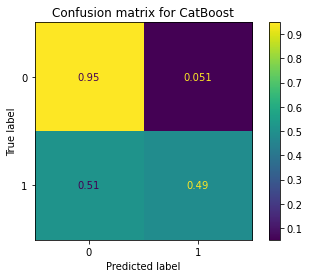

In [90]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, X_pred, normalize='true'))
matrix.plot()
plt.title('Confusion matrix for CatBoost')
plt.show()

### C АндерСемплингом

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [145]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [146]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [147]:
catboost = CatBoostClassifier()

catboost.fit(X_train, y_train)

Learning rate set to 0.057701
0:	learn: 0.6663017	total: 26.5ms	remaining: 26.4s
1:	learn: 0.6436493	total: 36.6ms	remaining: 18.3s
2:	learn: 0.6245823	total: 45.4ms	remaining: 15.1s
3:	learn: 0.6079069	total: 54.4ms	remaining: 13.6s
4:	learn: 0.5931926	total: 63.8ms	remaining: 12.7s
5:	learn: 0.5793433	total: 73.1ms	remaining: 12.1s
6:	learn: 0.5672038	total: 82ms	remaining: 11.6s
7:	learn: 0.5568915	total: 92ms	remaining: 11.4s
8:	learn: 0.5471944	total: 107ms	remaining: 11.7s
9:	learn: 0.5388057	total: 120ms	remaining: 11.8s
10:	learn: 0.5315756	total: 132ms	remaining: 11.9s
11:	learn: 0.5251650	total: 145ms	remaining: 12s
12:	learn: 0.5194462	total: 155ms	remaining: 11.8s
13:	learn: 0.5147355	total: 165ms	remaining: 11.6s
14:	learn: 0.5103053	total: 175ms	remaining: 11.5s
15:	learn: 0.5057977	total: 185ms	remaining: 11.4s
16:	learn: 0.5021445	total: 195ms	remaining: 11.3s
17:	learn: 0.4989420	total: 206ms	remaining: 11.3s
18:	learn: 0.4956599	total: 215ms	remaining: 11.1s
19:	learn

175:	learn: 0.4329643	total: 1.57s	remaining: 7.37s
176:	learn: 0.4328440	total: 1.58s	remaining: 7.37s
177:	learn: 0.4327135	total: 1.59s	remaining: 7.36s
178:	learn: 0.4326111	total: 1.6s	remaining: 7.36s
179:	learn: 0.4325216	total: 1.61s	remaining: 7.35s
180:	learn: 0.4323953	total: 1.62s	remaining: 7.35s
181:	learn: 0.4322974	total: 1.63s	remaining: 7.35s
182:	learn: 0.4321869	total: 1.65s	remaining: 7.35s
183:	learn: 0.4320636	total: 1.66s	remaining: 7.34s
184:	learn: 0.4319281	total: 1.66s	remaining: 7.33s
185:	learn: 0.4318042	total: 1.67s	remaining: 7.33s
186:	learn: 0.4316797	total: 1.68s	remaining: 7.32s
187:	learn: 0.4315909	total: 1.69s	remaining: 7.31s
188:	learn: 0.4314591	total: 1.7s	remaining: 7.3s
189:	learn: 0.4312776	total: 1.71s	remaining: 7.29s
190:	learn: 0.4312110	total: 1.72s	remaining: 7.27s
191:	learn: 0.4311013	total: 1.73s	remaining: 7.26s
192:	learn: 0.4309757	total: 1.73s	remaining: 7.25s
193:	learn: 0.4308648	total: 1.74s	remaining: 7.24s
194:	learn: 0.4

344:	learn: 0.4147647	total: 2.96s	remaining: 5.63s
345:	learn: 0.4146201	total: 2.97s	remaining: 5.62s
346:	learn: 0.4145111	total: 2.98s	remaining: 5.61s
347:	learn: 0.4144017	total: 2.99s	remaining: 5.6s
348:	learn: 0.4142873	total: 3s	remaining: 5.59s
349:	learn: 0.4141975	total: 3.01s	remaining: 5.58s
350:	learn: 0.4141242	total: 3.02s	remaining: 5.58s
351:	learn: 0.4140117	total: 3.03s	remaining: 5.57s
352:	learn: 0.4139008	total: 3.03s	remaining: 5.56s
353:	learn: 0.4138311	total: 3.04s	remaining: 5.55s
354:	learn: 0.4137313	total: 3.05s	remaining: 5.54s
355:	learn: 0.4136467	total: 3.06s	remaining: 5.53s
356:	learn: 0.4135508	total: 3.07s	remaining: 5.53s
357:	learn: 0.4133915	total: 3.08s	remaining: 5.51s
358:	learn: 0.4132830	total: 3.08s	remaining: 5.51s
359:	learn: 0.4131808	total: 3.09s	remaining: 5.5s
360:	learn: 0.4130851	total: 3.1s	remaining: 5.49s
361:	learn: 0.4129782	total: 3.11s	remaining: 5.48s
362:	learn: 0.4128844	total: 3.12s	remaining: 5.47s
363:	learn: 0.4127

513:	learn: 0.4004788	total: 4.36s	remaining: 4.12s
514:	learn: 0.4004271	total: 4.37s	remaining: 4.12s
515:	learn: 0.4003678	total: 4.38s	remaining: 4.11s
516:	learn: 0.4002747	total: 4.39s	remaining: 4.1s
517:	learn: 0.4002165	total: 4.41s	remaining: 4.1s
518:	learn: 0.4001440	total: 4.42s	remaining: 4.09s
519:	learn: 0.4000617	total: 4.43s	remaining: 4.08s
520:	learn: 0.3999803	total: 4.44s	remaining: 4.08s
521:	learn: 0.3999044	total: 4.45s	remaining: 4.07s
522:	learn: 0.3998376	total: 4.46s	remaining: 4.07s
523:	learn: 0.3997600	total: 4.47s	remaining: 4.06s
524:	learn: 0.3996419	total: 4.48s	remaining: 4.05s
525:	learn: 0.3995826	total: 4.49s	remaining: 4.04s
526:	learn: 0.3995058	total: 4.5s	remaining: 4.04s
527:	learn: 0.3994353	total: 4.51s	remaining: 4.03s
528:	learn: 0.3993725	total: 4.52s	remaining: 4.02s
529:	learn: 0.3993197	total: 4.53s	remaining: 4.01s
530:	learn: 0.3992585	total: 4.54s	remaining: 4.01s
531:	learn: 0.3991669	total: 4.55s	remaining: 4s
532:	learn: 0.3990

687:	learn: 0.3883007	total: 5.97s	remaining: 2.71s
688:	learn: 0.3882324	total: 5.98s	remaining: 2.7s
689:	learn: 0.3881447	total: 5.99s	remaining: 2.69s
690:	learn: 0.3880506	total: 6s	remaining: 2.68s
691:	learn: 0.3879980	total: 6.01s	remaining: 2.67s
692:	learn: 0.3879788	total: 6.02s	remaining: 2.67s
693:	learn: 0.3878905	total: 6.03s	remaining: 2.66s
694:	learn: 0.3878381	total: 6.04s	remaining: 2.65s
695:	learn: 0.3877588	total: 6.04s	remaining: 2.64s
696:	learn: 0.3876392	total: 6.05s	remaining: 2.63s
697:	learn: 0.3876017	total: 6.06s	remaining: 2.62s
698:	learn: 0.3875726	total: 6.07s	remaining: 2.61s
699:	learn: 0.3874860	total: 6.08s	remaining: 2.61s
700:	learn: 0.3873965	total: 6.09s	remaining: 2.6s
701:	learn: 0.3873730	total: 6.1s	remaining: 2.59s
702:	learn: 0.3873381	total: 6.11s	remaining: 2.58s
703:	learn: 0.3872697	total: 6.11s	remaining: 2.57s
704:	learn: 0.3872277	total: 6.12s	remaining: 2.56s
705:	learn: 0.3871657	total: 6.13s	remaining: 2.55s
706:	learn: 0.3871

854:	learn: 0.3779658	total: 7.34s	remaining: 1.24s
855:	learn: 0.3779008	total: 7.35s	remaining: 1.24s
856:	learn: 0.3778341	total: 7.36s	remaining: 1.23s
857:	learn: 0.3777664	total: 7.37s	remaining: 1.22s
858:	learn: 0.3776907	total: 7.38s	remaining: 1.21s
859:	learn: 0.3776189	total: 7.38s	remaining: 1.2s
860:	learn: 0.3775464	total: 7.39s	remaining: 1.19s
861:	learn: 0.3775023	total: 7.4s	remaining: 1.19s
862:	learn: 0.3774230	total: 7.41s	remaining: 1.18s
863:	learn: 0.3774072	total: 7.42s	remaining: 1.17s
864:	learn: 0.3773598	total: 7.43s	remaining: 1.16s
865:	learn: 0.3772904	total: 7.44s	remaining: 1.15s
866:	learn: 0.3772249	total: 7.45s	remaining: 1.14s
867:	learn: 0.3771561	total: 7.45s	remaining: 1.13s
868:	learn: 0.3771055	total: 7.46s	remaining: 1.12s
869:	learn: 0.3770268	total: 7.47s	remaining: 1.12s
870:	learn: 0.3769771	total: 7.48s	remaining: 1.11s
871:	learn: 0.3769205	total: 7.48s	remaining: 1.1s
872:	learn: 0.3768392	total: 7.49s	remaining: 1.09s
873:	learn: 0.3

In [148]:
X_pred = catboost.predict(X_test)

In [149]:
from sklearn.metrics import classification_report
print(classification_report(X_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87     52561
         1.0       0.79      0.48      0.60     23020

    accuracy                           0.80     75581
   macro avg       0.80      0.71      0.73     75581
weighted avg       0.80      0.80      0.79     75581



In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [151]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours()
X_train, y_train = enn.fit_resample(X_train, y_train)

In [152]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [153]:
catboost = CatBoostClassifier()

catboost.fit(X_train, y_train)

Learning rate set to 0.078817
0:	learn: 0.6214338	total: 16.8ms	remaining: 16.7s
1:	learn: 0.5621781	total: 31.7ms	remaining: 15.8s
2:	learn: 0.5161070	total: 45.9ms	remaining: 15.3s
3:	learn: 0.4770820	total: 64.2ms	remaining: 16s
4:	learn: 0.4454416	total: 81.7ms	remaining: 16.3s
5:	learn: 0.4218454	total: 93.3ms	remaining: 15.5s
6:	learn: 0.4015916	total: 105ms	remaining: 14.9s
7:	learn: 0.3833322	total: 118ms	remaining: 14.6s
8:	learn: 0.3705191	total: 130ms	remaining: 14.3s
9:	learn: 0.3589165	total: 143ms	remaining: 14.1s
10:	learn: 0.3499818	total: 155ms	remaining: 14s
11:	learn: 0.3417873	total: 168ms	remaining: 13.8s
12:	learn: 0.3351457	total: 180ms	remaining: 13.6s
13:	learn: 0.3282405	total: 195ms	remaining: 13.8s
14:	learn: 0.3232544	total: 211ms	remaining: 13.8s
15:	learn: 0.3193819	total: 226ms	remaining: 13.9s
16:	learn: 0.3159827	total: 243ms	remaining: 14s
17:	learn: 0.3129179	total: 257ms	remaining: 14s
18:	learn: 0.3092966	total: 268ms	remaining: 13.8s
19:	learn: 0.

164:	learn: 0.2639270	total: 2.26s	remaining: 11.4s
165:	learn: 0.2638353	total: 2.27s	remaining: 11.4s
166:	learn: 0.2637561	total: 2.29s	remaining: 11.4s
167:	learn: 0.2636560	total: 2.3s	remaining: 11.4s
168:	learn: 0.2635974	total: 2.31s	remaining: 11.4s
169:	learn: 0.2635061	total: 2.33s	remaining: 11.4s
170:	learn: 0.2634068	total: 2.34s	remaining: 11.3s
171:	learn: 0.2633205	total: 2.35s	remaining: 11.3s
172:	learn: 0.2632965	total: 2.37s	remaining: 11.3s
173:	learn: 0.2632188	total: 2.38s	remaining: 11.3s
174:	learn: 0.2631295	total: 2.39s	remaining: 11.3s
175:	learn: 0.2630412	total: 2.4s	remaining: 11.3s
176:	learn: 0.2630048	total: 2.42s	remaining: 11.2s
177:	learn: 0.2629239	total: 2.43s	remaining: 11.2s
178:	learn: 0.2628204	total: 2.44s	remaining: 11.2s
179:	learn: 0.2627002	total: 2.46s	remaining: 11.2s
180:	learn: 0.2626297	total: 2.47s	remaining: 11.2s
181:	learn: 0.2625309	total: 2.49s	remaining: 11.2s
182:	learn: 0.2624340	total: 2.5s	remaining: 11.2s
183:	learn: 0.2

338:	learn: 0.2523007	total: 4.47s	remaining: 8.72s
339:	learn: 0.2522346	total: 4.48s	remaining: 8.71s
340:	learn: 0.2521766	total: 4.5s	remaining: 8.69s
341:	learn: 0.2521033	total: 4.51s	remaining: 8.68s
342:	learn: 0.2520350	total: 4.52s	remaining: 8.67s
343:	learn: 0.2519770	total: 4.54s	remaining: 8.65s
344:	learn: 0.2519153	total: 4.55s	remaining: 8.63s
345:	learn: 0.2518629	total: 4.56s	remaining: 8.62s
346:	learn: 0.2517871	total: 4.57s	remaining: 8.61s
347:	learn: 0.2517291	total: 4.58s	remaining: 8.59s
348:	learn: 0.2516576	total: 4.6s	remaining: 8.58s
349:	learn: 0.2515990	total: 4.61s	remaining: 8.56s
350:	learn: 0.2515547	total: 4.62s	remaining: 8.55s
351:	learn: 0.2514934	total: 4.63s	remaining: 8.53s
352:	learn: 0.2514431	total: 4.65s	remaining: 8.52s
353:	learn: 0.2513891	total: 4.66s	remaining: 8.5s
354:	learn: 0.2513081	total: 4.67s	remaining: 8.49s
355:	learn: 0.2512400	total: 4.69s	remaining: 8.48s
356:	learn: 0.2511744	total: 4.7s	remaining: 8.47s
357:	learn: 0.25

506:	learn: 0.2435588	total: 6.7s	remaining: 6.51s
507:	learn: 0.2435080	total: 6.71s	remaining: 6.5s
508:	learn: 0.2434642	total: 6.73s	remaining: 6.49s
509:	learn: 0.2434181	total: 6.74s	remaining: 6.48s
510:	learn: 0.2433650	total: 6.75s	remaining: 6.46s
511:	learn: 0.2433231	total: 6.77s	remaining: 6.45s
512:	learn: 0.2432922	total: 6.78s	remaining: 6.44s
513:	learn: 0.2432446	total: 6.8s	remaining: 6.43s
514:	learn: 0.2431964	total: 6.81s	remaining: 6.42s
515:	learn: 0.2431563	total: 6.83s	remaining: 6.4s
516:	learn: 0.2431410	total: 6.84s	remaining: 6.39s
517:	learn: 0.2430792	total: 6.86s	remaining: 6.38s
518:	learn: 0.2430397	total: 6.87s	remaining: 6.37s
519:	learn: 0.2429855	total: 6.89s	remaining: 6.36s
520:	learn: 0.2429401	total: 6.91s	remaining: 6.35s
521:	learn: 0.2428911	total: 6.92s	remaining: 6.34s
522:	learn: 0.2428400	total: 6.94s	remaining: 6.33s
523:	learn: 0.2427916	total: 6.95s	remaining: 6.31s
524:	learn: 0.2427403	total: 6.97s	remaining: 6.3s
525:	learn: 0.242

672:	learn: 0.2360955	total: 8.95s	remaining: 4.35s
673:	learn: 0.2360943	total: 8.96s	remaining: 4.33s
674:	learn: 0.2360490	total: 8.97s	remaining: 4.32s
675:	learn: 0.2359977	total: 8.99s	remaining: 4.31s
676:	learn: 0.2359293	total: 9s	remaining: 4.29s
677:	learn: 0.2358918	total: 9.01s	remaining: 4.28s
678:	learn: 0.2358384	total: 9.03s	remaining: 4.27s
679:	learn: 0.2357979	total: 9.04s	remaining: 4.25s
680:	learn: 0.2357530	total: 9.05s	remaining: 4.24s
681:	learn: 0.2356796	total: 9.06s	remaining: 4.23s
682:	learn: 0.2356254	total: 9.08s	remaining: 4.21s
683:	learn: 0.2355868	total: 9.09s	remaining: 4.2s
684:	learn: 0.2355388	total: 9.1s	remaining: 4.19s
685:	learn: 0.2355047	total: 9.11s	remaining: 4.17s
686:	learn: 0.2354602	total: 9.13s	remaining: 4.16s
687:	learn: 0.2354060	total: 9.14s	remaining: 4.15s
688:	learn: 0.2353584	total: 9.16s	remaining: 4.13s
689:	learn: 0.2353246	total: 9.17s	remaining: 4.12s
690:	learn: 0.2352888	total: 9.19s	remaining: 4.11s
691:	learn: 0.235

845:	learn: 0.2289566	total: 11.2s	remaining: 2.03s
846:	learn: 0.2289242	total: 11.2s	remaining: 2.02s
847:	learn: 0.2288854	total: 11.2s	remaining: 2.01s
848:	learn: 0.2288739	total: 11.2s	remaining: 2s
849:	learn: 0.2288315	total: 11.2s	remaining: 1.98s
850:	learn: 0.2287710	total: 11.2s	remaining: 1.97s
851:	learn: 0.2287252	total: 11.3s	remaining: 1.96s
852:	learn: 0.2286866	total: 11.3s	remaining: 1.94s
853:	learn: 0.2286570	total: 11.3s	remaining: 1.93s
854:	learn: 0.2286197	total: 11.3s	remaining: 1.92s
855:	learn: 0.2285752	total: 11.3s	remaining: 1.9s
856:	learn: 0.2285359	total: 11.3s	remaining: 1.89s
857:	learn: 0.2285041	total: 11.3s	remaining: 1.88s
858:	learn: 0.2284479	total: 11.3s	remaining: 1.86s
859:	learn: 0.2283989	total: 11.4s	remaining: 1.85s
860:	learn: 0.2283556	total: 11.4s	remaining: 1.83s
861:	learn: 0.2283161	total: 11.4s	remaining: 1.82s
862:	learn: 0.2282741	total: 11.4s	remaining: 1.81s
863:	learn: 0.2282608	total: 11.4s	remaining: 1.8s
864:	learn: 0.228

In [154]:
X_pred = catboost.predict(X_test)

In [155]:
from sklearn.metrics import classification_report
print(classification_report(X_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90     57934
         1.0       0.70      0.55      0.61     17647

    accuracy                           0.84     75581
   macro avg       0.78      0.74      0.76     75581
weighted avg       0.83      0.84      0.83     75581



In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [163]:
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import InstanceHardnessThreshold
iht = InstanceHardnessThreshold(random_state=0, 
                                estimator=LogisticRegression(solver='lbfgs', multi_class='auto'))
X_train, y_train = enn.fit_resample(X_train, y_train)

In [164]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [165]:
catboost = CatBoostClassifier()

catboost.fit(X_train, y_train)

Learning rate set to 0.078817
0:	learn: 0.6214338	total: 28.2ms	remaining: 28.2s
1:	learn: 0.5621781	total: 43.3ms	remaining: 21.6s
2:	learn: 0.5161070	total: 58.3ms	remaining: 19.4s
3:	learn: 0.4770820	total: 71.8ms	remaining: 17.9s
4:	learn: 0.4454416	total: 87.2ms	remaining: 17.4s
5:	learn: 0.4218454	total: 99.1ms	remaining: 16.4s
6:	learn: 0.4015916	total: 113ms	remaining: 16s
7:	learn: 0.3833322	total: 125ms	remaining: 15.5s
8:	learn: 0.3705191	total: 137ms	remaining: 15.1s
9:	learn: 0.3589165	total: 150ms	remaining: 14.8s
10:	learn: 0.3499818	total: 162ms	remaining: 14.6s
11:	learn: 0.3417873	total: 175ms	remaining: 14.4s
12:	learn: 0.3351457	total: 188ms	remaining: 14.3s
13:	learn: 0.3282405	total: 202ms	remaining: 14.2s
14:	learn: 0.3232544	total: 220ms	remaining: 14.4s
15:	learn: 0.3193819	total: 239ms	remaining: 14.7s
16:	learn: 0.3159827	total: 257ms	remaining: 14.8s
17:	learn: 0.3129179	total: 271ms	remaining: 14.8s
18:	learn: 0.3092966	total: 286ms	remaining: 14.7s
19:	lea

165:	learn: 0.2638353	total: 2.4s	remaining: 12.1s
166:	learn: 0.2637561	total: 2.42s	remaining: 12.1s
167:	learn: 0.2636560	total: 2.44s	remaining: 12.1s
168:	learn: 0.2635974	total: 2.45s	remaining: 12.1s
169:	learn: 0.2635061	total: 2.46s	remaining: 12s
170:	learn: 0.2634068	total: 2.48s	remaining: 12s
171:	learn: 0.2633205	total: 2.5s	remaining: 12s
172:	learn: 0.2632965	total: 2.51s	remaining: 12s
173:	learn: 0.2632188	total: 2.53s	remaining: 12s
174:	learn: 0.2631295	total: 2.54s	remaining: 12s
175:	learn: 0.2630412	total: 2.56s	remaining: 12s
176:	learn: 0.2630048	total: 2.57s	remaining: 12s
177:	learn: 0.2629239	total: 2.59s	remaining: 11.9s
178:	learn: 0.2628204	total: 2.6s	remaining: 11.9s
179:	learn: 0.2627002	total: 2.62s	remaining: 11.9s
180:	learn: 0.2626297	total: 2.63s	remaining: 11.9s
181:	learn: 0.2625309	total: 2.65s	remaining: 11.9s
182:	learn: 0.2624340	total: 2.67s	remaining: 11.9s
183:	learn: 0.2623339	total: 2.68s	remaining: 11.9s
184:	learn: 0.2623311	total: 2.

334:	learn: 0.2525249	total: 4.84s	remaining: 9.62s
335:	learn: 0.2524461	total: 4.86s	remaining: 9.61s
336:	learn: 0.2524190	total: 4.88s	remaining: 9.6s
337:	learn: 0.2523681	total: 4.89s	remaining: 9.58s
338:	learn: 0.2523007	total: 4.91s	remaining: 9.57s
339:	learn: 0.2522346	total: 4.92s	remaining: 9.55s
340:	learn: 0.2521766	total: 4.94s	remaining: 9.54s
341:	learn: 0.2521033	total: 4.95s	remaining: 9.53s
342:	learn: 0.2520350	total: 4.97s	remaining: 9.52s
343:	learn: 0.2519770	total: 4.99s	remaining: 9.51s
344:	learn: 0.2519153	total: 5s	remaining: 9.5s
345:	learn: 0.2518629	total: 5.02s	remaining: 9.49s
346:	learn: 0.2517871	total: 5.04s	remaining: 9.48s
347:	learn: 0.2517291	total: 5.05s	remaining: 9.46s
348:	learn: 0.2516576	total: 5.06s	remaining: 9.45s
349:	learn: 0.2515990	total: 5.08s	remaining: 9.43s
350:	learn: 0.2515547	total: 5.09s	remaining: 9.42s
351:	learn: 0.2514934	total: 5.11s	remaining: 9.4s
352:	learn: 0.2514431	total: 5.12s	remaining: 9.38s
353:	learn: 0.2513

505:	learn: 0.2436176	total: 7.26s	remaining: 7.09s
506:	learn: 0.2435588	total: 7.28s	remaining: 7.08s
507:	learn: 0.2435080	total: 7.29s	remaining: 7.06s
508:	learn: 0.2434642	total: 7.3s	remaining: 7.05s
509:	learn: 0.2434181	total: 7.32s	remaining: 7.03s
510:	learn: 0.2433650	total: 7.33s	remaining: 7.02s
511:	learn: 0.2433231	total: 7.35s	remaining: 7s
512:	learn: 0.2432922	total: 7.36s	remaining: 6.99s
513:	learn: 0.2432446	total: 7.38s	remaining: 6.98s
514:	learn: 0.2431964	total: 7.39s	remaining: 6.96s
515:	learn: 0.2431563	total: 7.41s	remaining: 6.95s
516:	learn: 0.2431410	total: 7.42s	remaining: 6.94s
517:	learn: 0.2430792	total: 7.44s	remaining: 6.92s
518:	learn: 0.2430397	total: 7.45s	remaining: 6.91s
519:	learn: 0.2429855	total: 7.47s	remaining: 6.89s
520:	learn: 0.2429401	total: 7.48s	remaining: 6.88s
521:	learn: 0.2428911	total: 7.5s	remaining: 6.87s
522:	learn: 0.2428400	total: 7.51s	remaining: 6.85s
523:	learn: 0.2427916	total: 7.52s	remaining: 6.83s
524:	learn: 0.242

671:	learn: 0.2361511	total: 9.71s	remaining: 4.74s
672:	learn: 0.2360955	total: 9.72s	remaining: 4.72s
673:	learn: 0.2360943	total: 9.73s	remaining: 4.71s
674:	learn: 0.2360490	total: 9.75s	remaining: 4.69s
675:	learn: 0.2359977	total: 9.77s	remaining: 4.68s
676:	learn: 0.2359293	total: 9.78s	remaining: 4.67s
677:	learn: 0.2358918	total: 9.79s	remaining: 4.65s
678:	learn: 0.2358384	total: 9.81s	remaining: 4.64s
679:	learn: 0.2357979	total: 9.82s	remaining: 4.62s
680:	learn: 0.2357530	total: 9.84s	remaining: 4.61s
681:	learn: 0.2356796	total: 9.85s	remaining: 4.59s
682:	learn: 0.2356254	total: 9.86s	remaining: 4.58s
683:	learn: 0.2355868	total: 9.87s	remaining: 4.56s
684:	learn: 0.2355388	total: 9.89s	remaining: 4.55s
685:	learn: 0.2355047	total: 9.9s	remaining: 4.53s
686:	learn: 0.2354602	total: 9.91s	remaining: 4.51s
687:	learn: 0.2354060	total: 9.92s	remaining: 4.5s
688:	learn: 0.2353584	total: 9.94s	remaining: 4.49s
689:	learn: 0.2353246	total: 9.95s	remaining: 4.47s
690:	learn: 0.

845:	learn: 0.2289566	total: 12.2s	remaining: 2.21s
846:	learn: 0.2289242	total: 12.2s	remaining: 2.2s
847:	learn: 0.2288854	total: 12.2s	remaining: 2.19s
848:	learn: 0.2288739	total: 12.2s	remaining: 2.17s
849:	learn: 0.2288315	total: 12.2s	remaining: 2.16s
850:	learn: 0.2287710	total: 12.2s	remaining: 2.14s
851:	learn: 0.2287252	total: 12.3s	remaining: 2.13s
852:	learn: 0.2286866	total: 12.3s	remaining: 2.12s
853:	learn: 0.2286570	total: 12.3s	remaining: 2.1s
854:	learn: 0.2286197	total: 12.3s	remaining: 2.09s
855:	learn: 0.2285752	total: 12.3s	remaining: 2.07s
856:	learn: 0.2285359	total: 12.3s	remaining: 2.06s
857:	learn: 0.2285041	total: 12.4s	remaining: 2.04s
858:	learn: 0.2284479	total: 12.4s	remaining: 2.03s
859:	learn: 0.2283989	total: 12.4s	remaining: 2.02s
860:	learn: 0.2283556	total: 12.4s	remaining: 2s
861:	learn: 0.2283161	total: 12.4s	remaining: 1.99s
862:	learn: 0.2282741	total: 12.4s	remaining: 1.97s
863:	learn: 0.2282608	total: 12.4s	remaining: 1.96s
864:	learn: 0.228

In [166]:
X_pred = catboost.predict(X_test)

In [167]:
from sklearn.metrics import classification_report
print(classification_report(X_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90     57934
         1.0       0.70      0.55      0.61     17647

    accuracy                           0.84     75581
   macro avg       0.78      0.74      0.76     75581
weighted avg       0.83      0.84      0.83     75581



### С оверсемплингом

SMOTE

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [114]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [115]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [116]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier()

catboost.fit(X_train, y_train)

Learning rate set to 0.108925
0:	learn: 0.5804326	total: 45.3ms	remaining: 45.2s
1:	learn: 0.5339077	total: 84.3ms	remaining: 42.1s
2:	learn: 0.5017951	total: 125ms	remaining: 41.6s
3:	learn: 0.4689665	total: 171ms	remaining: 42.5s
4:	learn: 0.4446802	total: 218ms	remaining: 43.3s
5:	learn: 0.4030538	total: 257ms	remaining: 42.6s
6:	learn: 0.3853135	total: 293ms	remaining: 41.6s
7:	learn: 0.3568549	total: 337ms	remaining: 41.8s
8:	learn: 0.3356136	total: 375ms	remaining: 41.3s
9:	learn: 0.3188239	total: 410ms	remaining: 40.6s
10:	learn: 0.3121843	total: 447ms	remaining: 40.2s
11:	learn: 0.3031403	total: 486ms	remaining: 40s
12:	learn: 0.2960416	total: 522ms	remaining: 39.6s
13:	learn: 0.2877733	total: 554ms	remaining: 39.1s
14:	learn: 0.2835689	total: 589ms	remaining: 38.7s
15:	learn: 0.2807016	total: 622ms	remaining: 38.3s
16:	learn: 0.2783471	total: 660ms	remaining: 38.1s
17:	learn: 0.2751458	total: 693ms	remaining: 37.8s
18:	learn: 0.2734397	total: 732ms	remaining: 37.8s
19:	learn: 

163:	learn: 0.2243388	total: 6.09s	remaining: 31s
164:	learn: 0.2242750	total: 6.13s	remaining: 31s
165:	learn: 0.2242102	total: 6.17s	remaining: 31s
166:	learn: 0.2238657	total: 6.21s	remaining: 31s
167:	learn: 0.2237939	total: 6.25s	remaining: 30.9s
168:	learn: 0.2237539	total: 6.29s	remaining: 30.9s
169:	learn: 0.2237013	total: 6.33s	remaining: 30.9s
170:	learn: 0.2236575	total: 6.37s	remaining: 30.9s
171:	learn: 0.2235965	total: 6.42s	remaining: 30.9s
172:	learn: 0.2235456	total: 6.45s	remaining: 30.9s
173:	learn: 0.2234500	total: 6.49s	remaining: 30.8s
174:	learn: 0.2233915	total: 6.53s	remaining: 30.8s
175:	learn: 0.2233174	total: 6.57s	remaining: 30.8s
176:	learn: 0.2232633	total: 6.61s	remaining: 30.8s
177:	learn: 0.2232221	total: 6.64s	remaining: 30.7s
178:	learn: 0.2231552	total: 6.67s	remaining: 30.6s
179:	learn: 0.2231048	total: 6.71s	remaining: 30.6s
180:	learn: 0.2226662	total: 6.76s	remaining: 30.6s
181:	learn: 0.2226191	total: 6.8s	remaining: 30.6s
182:	learn: 0.2225612

325:	learn: 0.2142725	total: 12s	remaining: 24.7s
326:	learn: 0.2142127	total: 12s	remaining: 24.7s
327:	learn: 0.2141585	total: 12s	remaining: 24.7s
328:	learn: 0.2141045	total: 12.1s	remaining: 24.6s
329:	learn: 0.2140637	total: 12.1s	remaining: 24.6s
330:	learn: 0.2136720	total: 12.1s	remaining: 24.6s
331:	learn: 0.2136199	total: 12.2s	remaining: 24.5s
332:	learn: 0.2135672	total: 12.2s	remaining: 24.5s
333:	learn: 0.2135401	total: 12.3s	remaining: 24.4s
334:	learn: 0.2135106	total: 12.3s	remaining: 24.4s
335:	learn: 0.2134738	total: 12.3s	remaining: 24.3s
336:	learn: 0.2134233	total: 12.3s	remaining: 24.3s
337:	learn: 0.2133908	total: 12.4s	remaining: 24.2s
338:	learn: 0.2133484	total: 12.4s	remaining: 24.2s
339:	learn: 0.2133113	total: 12.5s	remaining: 24.2s
340:	learn: 0.2132617	total: 12.5s	remaining: 24.1s
341:	learn: 0.2132161	total: 12.5s	remaining: 24.1s
342:	learn: 0.2131678	total: 12.6s	remaining: 24.1s
343:	learn: 0.2131173	total: 12.6s	remaining: 24s
344:	learn: 0.213085

488:	learn: 0.2072151	total: 17.5s	remaining: 18.3s
489:	learn: 0.2071834	total: 17.5s	remaining: 18.2s
490:	learn: 0.2071449	total: 17.6s	remaining: 18.2s
491:	learn: 0.2071035	total: 17.6s	remaining: 18.2s
492:	learn: 0.2070703	total: 17.6s	remaining: 18.1s
493:	learn: 0.2070343	total: 17.7s	remaining: 18.1s
494:	learn: 0.2069983	total: 17.7s	remaining: 18.1s
495:	learn: 0.2069579	total: 17.8s	remaining: 18s
496:	learn: 0.2069330	total: 17.8s	remaining: 18s
497:	learn: 0.2068913	total: 17.8s	remaining: 18s
498:	learn: 0.2068632	total: 17.9s	remaining: 17.9s
499:	learn: 0.2068209	total: 17.9s	remaining: 17.9s
500:	learn: 0.2067935	total: 17.9s	remaining: 17.9s
501:	learn: 0.2067591	total: 18s	remaining: 17.8s
502:	learn: 0.2067410	total: 18s	remaining: 17.8s
503:	learn: 0.2067130	total: 18.1s	remaining: 17.8s
504:	learn: 0.2066769	total: 18.1s	remaining: 17.7s
505:	learn: 0.2066500	total: 18.1s	remaining: 17.7s
506:	learn: 0.2066134	total: 18.2s	remaining: 17.7s
507:	learn: 0.2065858	

650:	learn: 0.2017561	total: 23.4s	remaining: 12.5s
651:	learn: 0.2017201	total: 23.4s	remaining: 12.5s
652:	learn: 0.2016767	total: 23.4s	remaining: 12.5s
653:	learn: 0.2016446	total: 23.5s	remaining: 12.4s
654:	learn: 0.2016075	total: 23.5s	remaining: 12.4s
655:	learn: 0.2015810	total: 23.6s	remaining: 12.4s
656:	learn: 0.2015475	total: 23.6s	remaining: 12.3s
657:	learn: 0.2015204	total: 23.6s	remaining: 12.3s
658:	learn: 0.2014859	total: 23.7s	remaining: 12.2s
659:	learn: 0.2014551	total: 23.7s	remaining: 12.2s
660:	learn: 0.2014086	total: 23.7s	remaining: 12.2s
661:	learn: 0.2013797	total: 23.8s	remaining: 12.1s
662:	learn: 0.2013603	total: 23.8s	remaining: 12.1s
663:	learn: 0.2013432	total: 23.9s	remaining: 12.1s
664:	learn: 0.2013155	total: 23.9s	remaining: 12s
665:	learn: 0.2012953	total: 23.9s	remaining: 12s
666:	learn: 0.2012556	total: 24s	remaining: 12s
667:	learn: 0.2012247	total: 24s	remaining: 11.9s
668:	learn: 0.2011971	total: 24.1s	remaining: 11.9s
669:	learn: 0.2011624	

810:	learn: 0.1967428	total: 29.3s	remaining: 6.83s
811:	learn: 0.1967199	total: 29.4s	remaining: 6.8s
812:	learn: 0.1966806	total: 29.4s	remaining: 6.76s
813:	learn: 0.1966628	total: 29.4s	remaining: 6.73s
814:	learn: 0.1966340	total: 29.5s	remaining: 6.69s
815:	learn: 0.1966073	total: 29.5s	remaining: 6.65s
816:	learn: 0.1965729	total: 29.5s	remaining: 6.62s
817:	learn: 0.1964162	total: 29.6s	remaining: 6.58s
818:	learn: 0.1963785	total: 29.6s	remaining: 6.54s
819:	learn: 0.1963465	total: 29.6s	remaining: 6.51s
820:	learn: 0.1963184	total: 29.7s	remaining: 6.47s
821:	learn: 0.1962919	total: 29.7s	remaining: 6.43s
822:	learn: 0.1962659	total: 29.7s	remaining: 6.4s
823:	learn: 0.1962328	total: 29.8s	remaining: 6.36s
824:	learn: 0.1962145	total: 29.8s	remaining: 6.33s
825:	learn: 0.1961815	total: 29.9s	remaining: 6.29s
826:	learn: 0.1961521	total: 29.9s	remaining: 6.25s
827:	learn: 0.1961203	total: 29.9s	remaining: 6.21s
828:	learn: 0.1960929	total: 30s	remaining: 6.18s
829:	learn: 0.19

970:	learn: 0.1919571	total: 34.8s	remaining: 1.04s
971:	learn: 0.1919339	total: 34.9s	remaining: 1s
972:	learn: 0.1919127	total: 34.9s	remaining: 969ms
973:	learn: 0.1918840	total: 34.9s	remaining: 933ms
974:	learn: 0.1918652	total: 35s	remaining: 897ms
975:	learn: 0.1918414	total: 35s	remaining: 861ms
976:	learn: 0.1918293	total: 35s	remaining: 825ms
977:	learn: 0.1917917	total: 35.1s	remaining: 789ms
978:	learn: 0.1917750	total: 35.1s	remaining: 753ms
979:	learn: 0.1917451	total: 35.1s	remaining: 717ms
980:	learn: 0.1917272	total: 35.2s	remaining: 681ms
981:	learn: 0.1916963	total: 35.2s	remaining: 645ms
982:	learn: 0.1916925	total: 35.2s	remaining: 609ms
983:	learn: 0.1916729	total: 35.3s	remaining: 574ms
984:	learn: 0.1916400	total: 35.3s	remaining: 538ms
985:	learn: 0.1916193	total: 35.3s	remaining: 502ms
986:	learn: 0.1916105	total: 35.4s	remaining: 466ms
987:	learn: 0.1915909	total: 35.4s	remaining: 430ms
988:	learn: 0.1915584	total: 35.4s	remaining: 394ms
989:	learn: 0.1915206

In [117]:
X_pred = catboost.predict(X_test)

In [118]:
from sklearn.metrics import classification_report
print(classification_report(X_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92     65429
         1.0       0.50      0.68      0.57     10152

    accuracy                           0.86     75581
   macro avg       0.72      0.79      0.75     75581
weighted avg       0.89      0.86      0.87     75581



Другие методы oversampling

ADASYN

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [169]:
from imblearn.over_sampling import ADASYN
X_train, y_train = ADASYN().fit_resample(X_train, y_train)

In [170]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [171]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier()

catboost.fit(X_train, y_train)

Learning rate set to 0.108901
0:	learn: 0.6387995	total: 74.5ms	remaining: 1m 14s
1:	learn: 0.5648277	total: 115ms	remaining: 57.3s
2:	learn: 0.5043418	total: 157ms	remaining: 52s
3:	learn: 0.4526773	total: 191ms	remaining: 47.5s
4:	learn: 0.4339068	total: 224ms	remaining: 44.6s
5:	learn: 0.4026081	total: 256ms	remaining: 42.5s
6:	learn: 0.3765034	total: 292ms	remaining: 41.4s
7:	learn: 0.3652532	total: 325ms	remaining: 40.3s
8:	learn: 0.3500822	total: 358ms	remaining: 39.4s
9:	learn: 0.3438673	total: 388ms	remaining: 38.4s
10:	learn: 0.3318614	total: 416ms	remaining: 37.4s
11:	learn: 0.3270036	total: 448ms	remaining: 36.8s
12:	learn: 0.3228644	total: 475ms	remaining: 36.1s
13:	learn: 0.3161473	total: 507ms	remaining: 35.7s
14:	learn: 0.3083153	total: 544ms	remaining: 35.7s
15:	learn: 0.3031621	total: 577ms	remaining: 35.5s
16:	learn: 0.2995127	total: 605ms	remaining: 35s
17:	learn: 0.2928162	total: 634ms	remaining: 34.6s
18:	learn: 0.2901061	total: 660ms	remaining: 34.1s
19:	learn: 0.

164:	learn: 0.2399510	total: 5.53s	remaining: 28s
165:	learn: 0.2398825	total: 5.56s	remaining: 27.9s
166:	learn: 0.2396112	total: 5.6s	remaining: 27.9s
167:	learn: 0.2394272	total: 5.64s	remaining: 27.9s
168:	learn: 0.2393746	total: 5.68s	remaining: 27.9s
169:	learn: 0.2393013	total: 5.72s	remaining: 27.9s
170:	learn: 0.2390672	total: 5.77s	remaining: 28s
171:	learn: 0.2390091	total: 5.8s	remaining: 27.9s
172:	learn: 0.2389453	total: 5.84s	remaining: 27.9s
173:	learn: 0.2388813	total: 5.88s	remaining: 27.9s
174:	learn: 0.2388130	total: 5.91s	remaining: 27.9s
175:	learn: 0.2387548	total: 5.94s	remaining: 27.8s
176:	learn: 0.2386775	total: 5.98s	remaining: 27.8s
177:	learn: 0.2386128	total: 6s	remaining: 27.7s
178:	learn: 0.2384919	total: 6.04s	remaining: 27.7s
179:	learn: 0.2384215	total: 6.07s	remaining: 27.7s
180:	learn: 0.2383527	total: 6.11s	remaining: 27.6s
181:	learn: 0.2382469	total: 6.14s	remaining: 27.6s
182:	learn: 0.2381653	total: 6.18s	remaining: 27.6s
183:	learn: 0.2381051

326:	learn: 0.2295186	total: 10.9s	remaining: 22.5s
327:	learn: 0.2294769	total: 11s	remaining: 22.5s
328:	learn: 0.2294338	total: 11s	remaining: 22.5s
329:	learn: 0.2293839	total: 11.1s	remaining: 22.5s
330:	learn: 0.2293588	total: 11.1s	remaining: 22.4s
331:	learn: 0.2293281	total: 11.1s	remaining: 22.4s
332:	learn: 0.2292688	total: 11.2s	remaining: 22.4s
333:	learn: 0.2292226	total: 11.2s	remaining: 22.4s
334:	learn: 0.2291786	total: 11.3s	remaining: 22.4s
335:	learn: 0.2291299	total: 11.3s	remaining: 22.3s
336:	learn: 0.2290737	total: 11.3s	remaining: 22.3s
337:	learn: 0.2290282	total: 11.4s	remaining: 22.3s
338:	learn: 0.2289878	total: 11.4s	remaining: 22.3s
339:	learn: 0.2289150	total: 11.5s	remaining: 22.2s
340:	learn: 0.2288883	total: 11.5s	remaining: 22.2s
341:	learn: 0.2288479	total: 11.5s	remaining: 22.2s
342:	learn: 0.2288160	total: 11.6s	remaining: 22.1s
343:	learn: 0.2287777	total: 11.6s	remaining: 22.1s
344:	learn: 0.2287288	total: 11.7s	remaining: 22.2s
345:	learn: 0.22

491:	learn: 0.2220435	total: 16.3s	remaining: 16.9s
492:	learn: 0.2220229	total: 16.4s	remaining: 16.8s
493:	learn: 0.2219854	total: 16.4s	remaining: 16.8s
494:	learn: 0.2219398	total: 16.4s	remaining: 16.8s
495:	learn: 0.2219055	total: 16.5s	remaining: 16.7s
496:	learn: 0.2218602	total: 16.5s	remaining: 16.7s
497:	learn: 0.2218232	total: 16.5s	remaining: 16.7s
498:	learn: 0.2217815	total: 16.6s	remaining: 16.6s
499:	learn: 0.2217574	total: 16.6s	remaining: 16.6s
500:	learn: 0.2217164	total: 16.6s	remaining: 16.5s
501:	learn: 0.2216841	total: 16.6s	remaining: 16.5s
502:	learn: 0.2216677	total: 16.7s	remaining: 16.5s
503:	learn: 0.2216209	total: 16.7s	remaining: 16.5s
504:	learn: 0.2215796	total: 16.8s	remaining: 16.4s
505:	learn: 0.2215408	total: 16.8s	remaining: 16.4s
506:	learn: 0.2215101	total: 16.9s	remaining: 16.4s
507:	learn: 0.2214506	total: 16.9s	remaining: 16.4s
508:	learn: 0.2214164	total: 16.9s	remaining: 16.3s
509:	learn: 0.2213918	total: 16.9s	remaining: 16.3s
510:	learn: 

650:	learn: 0.2162377	total: 21.5s	remaining: 11.5s
651:	learn: 0.2162112	total: 21.5s	remaining: 11.5s
652:	learn: 0.2161800	total: 21.6s	remaining: 11.5s
653:	learn: 0.2161441	total: 21.6s	remaining: 11.4s
654:	learn: 0.2161185	total: 21.6s	remaining: 11.4s
655:	learn: 0.2160939	total: 21.6s	remaining: 11.3s
656:	learn: 0.2160735	total: 21.7s	remaining: 11.3s
657:	learn: 0.2160460	total: 21.7s	remaining: 11.3s
658:	learn: 0.2160383	total: 21.7s	remaining: 11.2s
659:	learn: 0.2160043	total: 21.8s	remaining: 11.2s
660:	learn: 0.2159749	total: 21.8s	remaining: 11.2s
661:	learn: 0.2159367	total: 21.8s	remaining: 11.1s
662:	learn: 0.2159070	total: 21.8s	remaining: 11.1s
663:	learn: 0.2158738	total: 21.9s	remaining: 11.1s
664:	learn: 0.2158431	total: 21.9s	remaining: 11s
665:	learn: 0.2158050	total: 21.9s	remaining: 11s
666:	learn: 0.2157628	total: 22s	remaining: 11s
667:	learn: 0.2157316	total: 22s	remaining: 10.9s
668:	learn: 0.2156881	total: 22s	remaining: 10.9s
669:	learn: 0.2156584	to

810:	learn: 0.2109987	total: 26.4s	remaining: 6.16s
811:	learn: 0.2109548	total: 26.5s	remaining: 6.13s
812:	learn: 0.2109346	total: 26.5s	remaining: 6.09s
813:	learn: 0.2108970	total: 26.5s	remaining: 6.06s
814:	learn: 0.2108648	total: 26.5s	remaining: 6.03s
815:	learn: 0.2108566	total: 26.6s	remaining: 5.99s
816:	learn: 0.2108325	total: 26.6s	remaining: 5.96s
817:	learn: 0.2108153	total: 26.6s	remaining: 5.92s
818:	learn: 0.2107986	total: 26.7s	remaining: 5.89s
819:	learn: 0.2107800	total: 26.7s	remaining: 5.86s
820:	learn: 0.2107404	total: 26.8s	remaining: 5.83s
821:	learn: 0.2107049	total: 26.8s	remaining: 5.8s
822:	learn: 0.2106737	total: 26.9s	remaining: 5.78s
823:	learn: 0.2106577	total: 26.9s	remaining: 5.74s
824:	learn: 0.2106184	total: 26.9s	remaining: 5.71s
825:	learn: 0.2105991	total: 27s	remaining: 5.68s
826:	learn: 0.2105698	total: 27s	remaining: 5.65s
827:	learn: 0.2105478	total: 27.1s	remaining: 5.62s
828:	learn: 0.2105128	total: 27.1s	remaining: 5.59s
829:	learn: 0.210

970:	learn: 0.2064677	total: 31.6s	remaining: 944ms
971:	learn: 0.2064487	total: 31.6s	remaining: 911ms
972:	learn: 0.2064213	total: 31.7s	remaining: 879ms
973:	learn: 0.2063852	total: 31.7s	remaining: 846ms
974:	learn: 0.2063361	total: 31.7s	remaining: 814ms
975:	learn: 0.2063095	total: 31.8s	remaining: 781ms
976:	learn: 0.2062751	total: 31.8s	remaining: 748ms
977:	learn: 0.2062449	total: 31.8s	remaining: 716ms
978:	learn: 0.2062182	total: 31.9s	remaining: 683ms
979:	learn: 0.2061852	total: 31.9s	remaining: 651ms
980:	learn: 0.2061467	total: 31.9s	remaining: 618ms
981:	learn: 0.2061260	total: 31.9s	remaining: 585ms
982:	learn: 0.2060960	total: 32s	remaining: 553ms
983:	learn: 0.2060672	total: 32s	remaining: 520ms
984:	learn: 0.2060601	total: 32s	remaining: 488ms
985:	learn: 0.2060440	total: 32.1s	remaining: 455ms
986:	learn: 0.2060156	total: 32.1s	remaining: 423ms
987:	learn: 0.2060020	total: 32.1s	remaining: 390ms
988:	learn: 0.2059784	total: 32.1s	remaining: 357ms
989:	learn: 0.2059

In [172]:
X_pred = catboost.predict(X_test)

In [173]:
from sklearn.metrics import classification_report
print(classification_report(X_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92     65368
         1.0       0.50      0.68      0.57     10213

    accuracy                           0.86     75581
   macro avg       0.72      0.79      0.75     75581
weighted avg       0.89      0.86      0.87     75581



SMOTE borderline

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=42)

In [175]:
from imblearn.over_sampling import BorderlineSMOTE
sampler = BorderlineSMOTE()
X_train, y_train = sampler.fit_resample(X_train, y_train)

In [176]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [177]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier()

catboost.fit(X_train, y_train)

Learning rate set to 0.108925
0:	learn: 0.6325306	total: 104ms	remaining: 1m 43s
1:	learn: 0.5413554	total: 135ms	remaining: 1m 7s
2:	learn: 0.5075038	total: 171ms	remaining: 56.8s
3:	learn: 0.4488653	total: 210ms	remaining: 52.4s
4:	learn: 0.4043497	total: 246ms	remaining: 49s
5:	learn: 0.3776102	total: 281ms	remaining: 46.5s
6:	learn: 0.3604800	total: 310ms	remaining: 44s
7:	learn: 0.3428355	total: 340ms	remaining: 42.2s
8:	learn: 0.3261706	total: 367ms	remaining: 40.4s
9:	learn: 0.3111625	total: 399ms	remaining: 39.5s
10:	learn: 0.3048855	total: 439ms	remaining: 39.5s
11:	learn: 0.3004553	total: 468ms	remaining: 38.5s
12:	learn: 0.2925649	total: 499ms	remaining: 37.9s
13:	learn: 0.2893538	total: 525ms	remaining: 37s
14:	learn: 0.2821291	total: 556ms	remaining: 36.5s
15:	learn: 0.2770331	total: 581ms	remaining: 35.8s
16:	learn: 0.2723960	total: 610ms	remaining: 35.3s
17:	learn: 0.2707417	total: 644ms	remaining: 35.1s
18:	learn: 0.2677292	total: 675ms	remaining: 34.9s
19:	learn: 0.266

160:	learn: 0.2205796	total: 4.83s	remaining: 25.2s
161:	learn: 0.2205092	total: 4.86s	remaining: 25.1s
162:	learn: 0.2204509	total: 4.9s	remaining: 25.1s
163:	learn: 0.2204030	total: 4.92s	remaining: 25.1s
164:	learn: 0.2203527	total: 4.95s	remaining: 25.1s
165:	learn: 0.2202981	total: 4.98s	remaining: 25s
166:	learn: 0.2202281	total: 5.01s	remaining: 25s
167:	learn: 0.2201566	total: 5.04s	remaining: 25s
168:	learn: 0.2200807	total: 5.07s	remaining: 24.9s
169:	learn: 0.2200225	total: 5.1s	remaining: 24.9s
170:	learn: 0.2199647	total: 5.12s	remaining: 24.8s
171:	learn: 0.2198861	total: 5.15s	remaining: 24.8s
172:	learn: 0.2198216	total: 5.17s	remaining: 24.7s
173:	learn: 0.2197229	total: 5.2s	remaining: 24.7s
174:	learn: 0.2195842	total: 5.23s	remaining: 24.7s
175:	learn: 0.2194911	total: 5.26s	remaining: 24.6s
176:	learn: 0.2194088	total: 5.29s	remaining: 24.6s
177:	learn: 0.2193217	total: 5.32s	remaining: 24.6s
178:	learn: 0.2192717	total: 5.35s	remaining: 24.5s
179:	learn: 0.2192268

321:	learn: 0.2088554	total: 9.39s	remaining: 19.8s
322:	learn: 0.2088016	total: 9.43s	remaining: 19.8s
323:	learn: 0.2087630	total: 9.46s	remaining: 19.7s
324:	learn: 0.2087198	total: 9.49s	remaining: 19.7s
325:	learn: 0.2086697	total: 9.52s	remaining: 19.7s
326:	learn: 0.2085628	total: 9.54s	remaining: 19.6s
327:	learn: 0.2085194	total: 9.57s	remaining: 19.6s
328:	learn: 0.2083912	total: 9.6s	remaining: 19.6s
329:	learn: 0.2083617	total: 9.63s	remaining: 19.6s
330:	learn: 0.2081797	total: 9.66s	remaining: 19.5s
331:	learn: 0.2081382	total: 9.69s	remaining: 19.5s
332:	learn: 0.2081077	total: 9.72s	remaining: 19.5s
333:	learn: 0.2080591	total: 9.74s	remaining: 19.4s
334:	learn: 0.2080196	total: 9.77s	remaining: 19.4s
335:	learn: 0.2079568	total: 9.8s	remaining: 19.4s
336:	learn: 0.2079130	total: 9.83s	remaining: 19.3s
337:	learn: 0.2078567	total: 9.86s	remaining: 19.3s
338:	learn: 0.2078026	total: 9.9s	remaining: 19.3s
339:	learn: 0.2074339	total: 9.93s	remaining: 19.3s
340:	learn: 0.2

482:	learn: 0.2011784	total: 14s	remaining: 15s
483:	learn: 0.2011347	total: 14s	remaining: 15s
484:	learn: 0.2011036	total: 14.1s	remaining: 14.9s
485:	learn: 0.2010656	total: 14.1s	remaining: 14.9s
486:	learn: 0.2010312	total: 14.1s	remaining: 14.9s
487:	learn: 0.2009991	total: 14.2s	remaining: 14.9s
488:	learn: 0.2009559	total: 14.2s	remaining: 14.8s
489:	learn: 0.2009116	total: 14.2s	remaining: 14.8s
490:	learn: 0.2008693	total: 14.3s	remaining: 14.8s
491:	learn: 0.2008538	total: 14.3s	remaining: 14.8s
492:	learn: 0.2008077	total: 14.3s	remaining: 14.7s
493:	learn: 0.2007765	total: 14.3s	remaining: 14.7s
494:	learn: 0.2007304	total: 14.4s	remaining: 14.7s
495:	learn: 0.2007115	total: 14.4s	remaining: 14.6s
496:	learn: 0.2006892	total: 14.4s	remaining: 14.6s
497:	learn: 0.2006263	total: 14.5s	remaining: 14.6s
498:	learn: 0.2005852	total: 14.5s	remaining: 14.5s
499:	learn: 0.2005529	total: 14.5s	remaining: 14.5s
500:	learn: 0.2005236	total: 14.5s	remaining: 14.5s
501:	learn: 0.200478

645:	learn: 0.1953874	total: 18.8s	remaining: 10.3s
646:	learn: 0.1953112	total: 18.8s	remaining: 10.3s
647:	learn: 0.1952925	total: 18.9s	remaining: 10.2s
648:	learn: 0.1952794	total: 18.9s	remaining: 10.2s
649:	learn: 0.1952566	total: 18.9s	remaining: 10.2s
650:	learn: 0.1952097	total: 18.9s	remaining: 10.1s
651:	learn: 0.1951757	total: 19s	remaining: 10.1s
652:	learn: 0.1951372	total: 19s	remaining: 10.1s
653:	learn: 0.1951029	total: 19s	remaining: 10.1s
654:	learn: 0.1950708	total: 19.1s	remaining: 10s
655:	learn: 0.1950479	total: 19.1s	remaining: 10s
656:	learn: 0.1949988	total: 19.1s	remaining: 9.98s
657:	learn: 0.1949578	total: 19.1s	remaining: 9.95s
658:	learn: 0.1949179	total: 19.2s	remaining: 9.92s
659:	learn: 0.1948774	total: 19.2s	remaining: 9.89s
660:	learn: 0.1948445	total: 19.2s	remaining: 9.86s
661:	learn: 0.1947886	total: 19.3s	remaining: 9.83s
662:	learn: 0.1947599	total: 19.3s	remaining: 9.8s
663:	learn: 0.1947194	total: 19.3s	remaining: 9.77s
664:	learn: 0.1946899	t

808:	learn: 0.1903092	total: 23.5s	remaining: 5.55s
809:	learn: 0.1902860	total: 23.5s	remaining: 5.52s
810:	learn: 0.1902618	total: 23.6s	remaining: 5.49s
811:	learn: 0.1902273	total: 23.6s	remaining: 5.47s
812:	learn: 0.1901914	total: 23.6s	remaining: 5.44s
813:	learn: 0.1901582	total: 23.7s	remaining: 5.41s
814:	learn: 0.1901331	total: 23.7s	remaining: 5.38s
815:	learn: 0.1901007	total: 23.7s	remaining: 5.35s
816:	learn: 0.1900655	total: 23.8s	remaining: 5.32s
817:	learn: 0.1900344	total: 23.8s	remaining: 5.29s
818:	learn: 0.1900122	total: 23.8s	remaining: 5.26s
819:	learn: 0.1899829	total: 23.8s	remaining: 5.23s
820:	learn: 0.1899637	total: 23.9s	remaining: 5.2s
821:	learn: 0.1899443	total: 23.9s	remaining: 5.17s
822:	learn: 0.1899147	total: 23.9s	remaining: 5.14s
823:	learn: 0.1898805	total: 23.9s	remaining: 5.12s
824:	learn: 0.1898398	total: 24s	remaining: 5.09s
825:	learn: 0.1898307	total: 24s	remaining: 5.06s
826:	learn: 0.1898060	total: 24s	remaining: 5.03s
827:	learn: 0.18978

969:	learn: 0.1854284	total: 28.4s	remaining: 878ms
970:	learn: 0.1853948	total: 28.4s	remaining: 850ms
971:	learn: 0.1853820	total: 28.5s	remaining: 821ms
972:	learn: 0.1853665	total: 28.5s	remaining: 792ms
973:	learn: 0.1853532	total: 28.6s	remaining: 763ms
974:	learn: 0.1853216	total: 28.6s	remaining: 733ms
975:	learn: 0.1853028	total: 28.7s	remaining: 705ms
976:	learn: 0.1852776	total: 28.7s	remaining: 676ms
977:	learn: 0.1852392	total: 28.8s	remaining: 647ms
978:	learn: 0.1852183	total: 28.8s	remaining: 618ms
979:	learn: 0.1851881	total: 28.9s	remaining: 589ms
980:	learn: 0.1851686	total: 28.9s	remaining: 559ms
981:	learn: 0.1851437	total: 28.9s	remaining: 530ms
982:	learn: 0.1851085	total: 29s	remaining: 501ms
983:	learn: 0.1850891	total: 29s	remaining: 471ms
984:	learn: 0.1850567	total: 29s	remaining: 442ms
985:	learn: 0.1850235	total: 29s	remaining: 412ms
986:	learn: 0.1849977	total: 29.1s	remaining: 383ms
987:	learn: 0.1849755	total: 29.1s	remaining: 354ms
988:	learn: 0.184944

In [178]:
X_pred = catboost.predict(X_test)

In [179]:
from sklearn.metrics import classification_report
print(classification_report(X_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92     65341
         1.0       0.50      0.68      0.57     10240

    accuracy                           0.86     75581
   macro avg       0.72      0.79      0.75     75581
weighted avg       0.89      0.86      0.87     75581



In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Выбираем обычный SMOTE и тюним на нем гиперпараметры

In [98]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import f1_score

In [93]:
imba_pipeline = make_pipeline(SMOTE(random_state=42), StandardScaler(),
                              CatBoostClassifier())
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [109]:
new_params = {'smote__k_neighbors': [i for i in range(5)]}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,refit='precision_score', scoring=scorers,
                        return_train_score=True, verbose=1)
grid_imba.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Learning rate set to 0.099047
0:	learn: 0.6374328	total: 49.7ms	remaining: 49.6s
1:	learn: 0.5897055	total: 78.1ms	remaining: 39s
2:	learn: 0.5525057	total: 103ms	remaining: 34.1s
3:	learn: 0.5213938	total: 126ms	remaining: 31.3s
4:	learn: 0.4960334	total: 149ms	remaining: 29.7s
5:	learn: 0.4665251	total: 173ms	remaining: 28.6s
6:	learn: 0.4511521	total: 200ms	remaining: 28.4s
7:	learn: 0.4399118	total: 231ms	remaining: 28.7s
8:	learn: 0.4235962	total: 262ms	remaining: 28.8s
9:	learn: 0.4162255	total: 290ms	remaining: 28.7s
10:	learn: 0.4100594	total: 311ms	remaining: 28s
11:	learn: 0.4026275	total: 340ms	remaining: 28s
12:	learn: 0.3969715	total: 363ms	remaining: 27.6s
13:	learn: 0.3879833	total: 391ms	remaining: 27.5s
14:	learn: 0.3787459	total: 421ms	remaining: 27.6s
15:	learn: 0.3698889	total: 448ms	remaining: 27.5s
16:	learn: 0.3673653	total: 470ms	remaining: 27.2s
17:	learn: 0.3602693	total: 491ms	remaining: 26.8s
18:	le

162:	learn: 0.2500877	total: 4.17s	remaining: 21.4s
163:	learn: 0.2499898	total: 4.2s	remaining: 21.4s
164:	learn: 0.2499013	total: 4.23s	remaining: 21.4s
165:	learn: 0.2498102	total: 4.26s	remaining: 21.4s
166:	learn: 0.2497380	total: 4.29s	remaining: 21.4s
167:	learn: 0.2495481	total: 4.31s	remaining: 21.4s
168:	learn: 0.2494787	total: 4.34s	remaining: 21.4s
169:	learn: 0.2492301	total: 4.38s	remaining: 21.4s
170:	learn: 0.2489948	total: 4.4s	remaining: 21.3s
171:	learn: 0.2488994	total: 4.43s	remaining: 21.3s
172:	learn: 0.2488198	total: 4.46s	remaining: 21.3s
173:	learn: 0.2483609	total: 4.49s	remaining: 21.3s
174:	learn: 0.2482606	total: 4.51s	remaining: 21.3s
175:	learn: 0.2481774	total: 4.54s	remaining: 21.3s
176:	learn: 0.2480714	total: 4.58s	remaining: 21.3s
177:	learn: 0.2472988	total: 4.61s	remaining: 21.3s
178:	learn: 0.2471946	total: 4.64s	remaining: 21.3s
179:	learn: 0.2470913	total: 4.67s	remaining: 21.3s
180:	learn: 0.2469826	total: 4.7s	remaining: 21.3s
181:	learn: 0.2

325:	learn: 0.2322218	total: 8.38s	remaining: 17.3s
326:	learn: 0.2320740	total: 8.41s	remaining: 17.3s
327:	learn: 0.2320346	total: 8.44s	remaining: 17.3s
328:	learn: 0.2319820	total: 8.46s	remaining: 17.2s
329:	learn: 0.2319211	total: 8.48s	remaining: 17.2s
330:	learn: 0.2318842	total: 8.5s	remaining: 17.2s
331:	learn: 0.2316905	total: 8.53s	remaining: 17.2s
332:	learn: 0.2316275	total: 8.55s	remaining: 17.1s
333:	learn: 0.2315559	total: 8.57s	remaining: 17.1s
334:	learn: 0.2315182	total: 8.59s	remaining: 17s
335:	learn: 0.2314388	total: 8.62s	remaining: 17s
336:	learn: 0.2313822	total: 8.64s	remaining: 17s
337:	learn: 0.2312942	total: 8.66s	remaining: 17s
338:	learn: 0.2312435	total: 8.68s	remaining: 16.9s
339:	learn: 0.2311947	total: 8.7s	remaining: 16.9s
340:	learn: 0.2311438	total: 8.73s	remaining: 16.9s
341:	learn: 0.2310897	total: 8.75s	remaining: 16.8s
342:	learn: 0.2310298	total: 8.78s	remaining: 16.8s
343:	learn: 0.2309507	total: 8.81s	remaining: 16.8s
344:	learn: 0.2305409	

486:	learn: 0.2235157	total: 12.7s	remaining: 13.4s
487:	learn: 0.2234725	total: 12.7s	remaining: 13.3s
488:	learn: 0.2233880	total: 12.7s	remaining: 13.3s
489:	learn: 0.2233421	total: 12.8s	remaining: 13.3s
490:	learn: 0.2233311	total: 12.8s	remaining: 13.2s
491:	learn: 0.2232738	total: 12.8s	remaining: 13.2s
492:	learn: 0.2232568	total: 12.8s	remaining: 13.2s
493:	learn: 0.2231732	total: 12.9s	remaining: 13.2s
494:	learn: 0.2231258	total: 12.9s	remaining: 13.1s
495:	learn: 0.2230731	total: 12.9s	remaining: 13.1s
496:	learn: 0.2230386	total: 12.9s	remaining: 13.1s
497:	learn: 0.2229825	total: 13s	remaining: 13.1s
498:	learn: 0.2229307	total: 13s	remaining: 13s
499:	learn: 0.2228818	total: 13s	remaining: 13s
500:	learn: 0.2228388	total: 13s	remaining: 13s
501:	learn: 0.2227870	total: 13.1s	remaining: 13s
502:	learn: 0.2226604	total: 13.1s	remaining: 12.9s
503:	learn: 0.2226177	total: 13.1s	remaining: 12.9s
504:	learn: 0.2225770	total: 13.1s	remaining: 12.9s
505:	learn: 0.2225351	total:

646:	learn: 0.2166227	total: 16.7s	remaining: 9.12s
647:	learn: 0.2165825	total: 16.7s	remaining: 9.1s
648:	learn: 0.2165397	total: 16.8s	remaining: 9.07s
649:	learn: 0.2165089	total: 16.8s	remaining: 9.05s
650:	learn: 0.2164772	total: 16.8s	remaining: 9.02s
651:	learn: 0.2164376	total: 16.9s	remaining: 9s
652:	learn: 0.2164062	total: 16.9s	remaining: 8.97s
653:	learn: 0.2163663	total: 16.9s	remaining: 8.95s
654:	learn: 0.2163301	total: 16.9s	remaining: 8.92s
655:	learn: 0.2162784	total: 17s	remaining: 8.9s
656:	learn: 0.2162491	total: 17s	remaining: 8.87s
657:	learn: 0.2162079	total: 17s	remaining: 8.85s
658:	learn: 0.2161869	total: 17s	remaining: 8.82s
659:	learn: 0.2161477	total: 17.1s	remaining: 8.79s
660:	learn: 0.2160427	total: 17.1s	remaining: 8.77s
661:	learn: 0.2160171	total: 17.1s	remaining: 8.74s
662:	learn: 0.2159842	total: 17.2s	remaining: 8.72s
663:	learn: 0.2159543	total: 17.2s	remaining: 8.69s
664:	learn: 0.2159287	total: 17.2s	remaining: 8.67s
665:	learn: 0.2158984	tot

805:	learn: 0.2108310	total: 20.8s	remaining: 5s
806:	learn: 0.2108021	total: 20.8s	remaining: 4.97s
807:	learn: 0.2107678	total: 20.8s	remaining: 4.95s
808:	learn: 0.2107469	total: 20.8s	remaining: 4.92s
809:	learn: 0.2107116	total: 20.9s	remaining: 4.89s
810:	learn: 0.2106682	total: 20.9s	remaining: 4.87s
811:	learn: 0.2106380	total: 20.9s	remaining: 4.84s
812:	learn: 0.2106004	total: 21s	remaining: 4.82s
813:	learn: 0.2105703	total: 21s	remaining: 4.79s
814:	learn: 0.2105226	total: 21s	remaining: 4.77s
815:	learn: 0.2104698	total: 21s	remaining: 4.74s
816:	learn: 0.2104258	total: 21.1s	remaining: 4.72s
817:	learn: 0.2104132	total: 21.1s	remaining: 4.69s
818:	learn: 0.2103859	total: 21.1s	remaining: 4.67s
819:	learn: 0.2103620	total: 21.1s	remaining: 4.64s
820:	learn: 0.2103301	total: 21.2s	remaining: 4.61s
821:	learn: 0.2102991	total: 21.2s	remaining: 4.59s
822:	learn: 0.2102755	total: 21.2s	remaining: 4.56s
823:	learn: 0.2102467	total: 21.2s	remaining: 4.54s
824:	learn: 0.2102093	t

969:	learn: 0.2051456	total: 25s	remaining: 773ms
970:	learn: 0.2051211	total: 25s	remaining: 747ms
971:	learn: 0.2050838	total: 25s	remaining: 721ms
972:	learn: 0.2050484	total: 25.1s	remaining: 696ms
973:	learn: 0.2050220	total: 25.1s	remaining: 670ms
974:	learn: 0.2049983	total: 25.1s	remaining: 644ms
975:	learn: 0.2049750	total: 25.1s	remaining: 618ms
976:	learn: 0.2049584	total: 25.2s	remaining: 593ms
977:	learn: 0.2049444	total: 25.2s	remaining: 567ms
978:	learn: 0.2049062	total: 25.2s	remaining: 541ms
979:	learn: 0.2048234	total: 25.2s	remaining: 515ms
980:	learn: 0.2047856	total: 25.3s	remaining: 489ms
981:	learn: 0.2047698	total: 25.3s	remaining: 463ms
982:	learn: 0.2047583	total: 25.3s	remaining: 438ms
983:	learn: 0.2047360	total: 25.3s	remaining: 412ms
984:	learn: 0.2047113	total: 25.3s	remaining: 386ms
985:	learn: 0.2046708	total: 25.4s	remaining: 360ms
986:	learn: 0.2046539	total: 25.4s	remaining: 334ms
987:	learn: 0.2046149	total: 25.4s	remaining: 309ms
988:	learn: 0.2045

132:	learn: 0.2593518	total: 3.6s	remaining: 23.5s
133:	learn: 0.2590071	total: 3.63s	remaining: 23.4s
134:	learn: 0.2584323	total: 3.65s	remaining: 23.4s
135:	learn: 0.2583155	total: 3.68s	remaining: 23.4s
136:	learn: 0.2574617	total: 3.7s	remaining: 23.3s
137:	learn: 0.2573724	total: 3.73s	remaining: 23.3s
138:	learn: 0.2570171	total: 3.75s	remaining: 23.2s
139:	learn: 0.2569066	total: 3.77s	remaining: 23.2s
140:	learn: 0.2567700	total: 3.79s	remaining: 23.1s
141:	learn: 0.2565956	total: 3.82s	remaining: 23.1s
142:	learn: 0.2564716	total: 3.85s	remaining: 23.1s
143:	learn: 0.2563364	total: 3.87s	remaining: 23s
144:	learn: 0.2561429	total: 3.9s	remaining: 23s
145:	learn: 0.2551831	total: 3.92s	remaining: 22.9s
146:	learn: 0.2548319	total: 3.94s	remaining: 22.9s
147:	learn: 0.2545835	total: 3.96s	remaining: 22.8s
148:	learn: 0.2544182	total: 3.99s	remaining: 22.8s
149:	learn: 0.2543002	total: 4.01s	remaining: 22.7s
150:	learn: 0.2541911	total: 4.04s	remaining: 22.7s
151:	learn: 0.25392

298:	learn: 0.2364646	total: 7.57s	remaining: 17.7s
299:	learn: 0.2364254	total: 7.59s	remaining: 17.7s
300:	learn: 0.2358895	total: 7.63s	remaining: 17.7s
301:	learn: 0.2358480	total: 7.65s	remaining: 17.7s
302:	learn: 0.2356617	total: 7.68s	remaining: 17.7s
303:	learn: 0.2356070	total: 7.71s	remaining: 17.6s
304:	learn: 0.2355422	total: 7.74s	remaining: 17.6s
305:	learn: 0.2354770	total: 7.77s	remaining: 17.6s
306:	learn: 0.2354249	total: 7.8s	remaining: 17.6s
307:	learn: 0.2353612	total: 7.83s	remaining: 17.6s
308:	learn: 0.2353071	total: 7.86s	remaining: 17.6s
309:	learn: 0.2352199	total: 7.89s	remaining: 17.6s
310:	learn: 0.2351589	total: 7.92s	remaining: 17.5s
311:	learn: 0.2351066	total: 7.94s	remaining: 17.5s
312:	learn: 0.2350520	total: 7.97s	remaining: 17.5s
313:	learn: 0.2349727	total: 7.99s	remaining: 17.5s
314:	learn: 0.2349242	total: 8.02s	remaining: 17.4s
315:	learn: 0.2348589	total: 8.05s	remaining: 17.4s
316:	learn: 0.2348136	total: 8.07s	remaining: 17.4s
317:	learn: 0

465:	learn: 0.2262066	total: 12s	remaining: 13.8s
466:	learn: 0.2261682	total: 12.1s	remaining: 13.8s
467:	learn: 0.2261004	total: 12.1s	remaining: 13.8s
468:	learn: 0.2260465	total: 12.1s	remaining: 13.7s
469:	learn: 0.2259742	total: 12.2s	remaining: 13.7s
470:	learn: 0.2259446	total: 12.2s	remaining: 13.7s
471:	learn: 0.2257998	total: 12.2s	remaining: 13.7s
472:	learn: 0.2257406	total: 12.2s	remaining: 13.6s
473:	learn: 0.2256824	total: 12.3s	remaining: 13.6s
474:	learn: 0.2256386	total: 12.3s	remaining: 13.6s
475:	learn: 0.2255873	total: 12.3s	remaining: 13.6s
476:	learn: 0.2255407	total: 12.4s	remaining: 13.6s
477:	learn: 0.2254985	total: 12.4s	remaining: 13.5s
478:	learn: 0.2254735	total: 12.4s	remaining: 13.5s
479:	learn: 0.2254231	total: 12.4s	remaining: 13.5s
480:	learn: 0.2253553	total: 12.5s	remaining: 13.5s
481:	learn: 0.2253183	total: 12.5s	remaining: 13.4s
482:	learn: 0.2252815	total: 12.5s	remaining: 13.4s
483:	learn: 0.2252303	total: 12.6s	remaining: 13.4s
484:	learn: 0.

626:	learn: 0.2189432	total: 16.5s	remaining: 9.84s
627:	learn: 0.2188934	total: 16.6s	remaining: 9.81s
628:	learn: 0.2188593	total: 16.6s	remaining: 9.79s
629:	learn: 0.2188265	total: 16.6s	remaining: 9.76s
630:	learn: 0.2187987	total: 16.7s	remaining: 9.74s
631:	learn: 0.2187565	total: 16.7s	remaining: 9.71s
632:	learn: 0.2187136	total: 16.7s	remaining: 9.69s
633:	learn: 0.2186826	total: 16.7s	remaining: 9.66s
634:	learn: 0.2186427	total: 16.8s	remaining: 9.63s
635:	learn: 0.2186121	total: 16.8s	remaining: 9.61s
636:	learn: 0.2185847	total: 16.8s	remaining: 9.58s
637:	learn: 0.2185417	total: 16.8s	remaining: 9.55s
638:	learn: 0.2185187	total: 16.9s	remaining: 9.53s
639:	learn: 0.2185008	total: 16.9s	remaining: 9.5s
640:	learn: 0.2184787	total: 16.9s	remaining: 9.47s
641:	learn: 0.2184436	total: 16.9s	remaining: 9.45s
642:	learn: 0.2183954	total: 17s	remaining: 9.42s
643:	learn: 0.2183427	total: 17s	remaining: 9.39s
644:	learn: 0.2183087	total: 17s	remaining: 9.37s
645:	learn: 0.21826

792:	learn: 0.2127595	total: 20.5s	remaining: 5.34s
793:	learn: 0.2127559	total: 20.5s	remaining: 5.32s
794:	learn: 0.2127156	total: 20.5s	remaining: 5.29s
795:	learn: 0.2126881	total: 20.5s	remaining: 5.27s
796:	learn: 0.2126589	total: 20.6s	remaining: 5.24s
797:	learn: 0.2126215	total: 20.6s	remaining: 5.21s
798:	learn: 0.2125610	total: 20.6s	remaining: 5.18s
799:	learn: 0.2125280	total: 20.6s	remaining: 5.16s
800:	learn: 0.2124935	total: 20.7s	remaining: 5.13s
801:	learn: 0.2124627	total: 20.7s	remaining: 5.1s
802:	learn: 0.2124118	total: 20.7s	remaining: 5.08s
803:	learn: 0.2123888	total: 20.7s	remaining: 5.05s
804:	learn: 0.2123799	total: 20.7s	remaining: 5.03s
805:	learn: 0.2123342	total: 20.8s	remaining: 5s
806:	learn: 0.2123186	total: 20.8s	remaining: 4.97s
807:	learn: 0.2122834	total: 20.8s	remaining: 4.94s
808:	learn: 0.2122651	total: 20.8s	remaining: 4.92s
809:	learn: 0.2122365	total: 20.8s	remaining: 4.89s
810:	learn: 0.2121881	total: 20.9s	remaining: 4.86s
811:	learn: 0.21

957:	learn: 0.2065521	total: 24.3s	remaining: 1.06s
958:	learn: 0.2063937	total: 24.3s	remaining: 1.04s
959:	learn: 0.2063717	total: 24.3s	remaining: 1.01s
960:	learn: 0.2063381	total: 24.4s	remaining: 989ms
961:	learn: 0.2062978	total: 24.4s	remaining: 964ms
962:	learn: 0.2062789	total: 24.4s	remaining: 938ms
963:	learn: 0.2062200	total: 24.4s	remaining: 913ms
964:	learn: 0.2061998	total: 24.5s	remaining: 887ms
965:	learn: 0.2061718	total: 24.5s	remaining: 862ms
966:	learn: 0.2061541	total: 24.5s	remaining: 836ms
967:	learn: 0.2061375	total: 24.5s	remaining: 811ms
968:	learn: 0.2061124	total: 24.6s	remaining: 786ms
969:	learn: 0.2060758	total: 24.6s	remaining: 760ms
970:	learn: 0.2060476	total: 24.6s	remaining: 735ms
971:	learn: 0.2060089	total: 24.6s	remaining: 709ms
972:	learn: 0.2059853	total: 24.6s	remaining: 684ms
973:	learn: 0.2059558	total: 24.7s	remaining: 658ms
974:	learn: 0.2059205	total: 24.7s	remaining: 633ms
975:	learn: 0.2059014	total: 24.7s	remaining: 608ms
976:	learn: 

121:	learn: 0.2632590	total: 2.99s	remaining: 21.6s
122:	learn: 0.2620507	total: 3.02s	remaining: 21.5s
123:	learn: 0.2619091	total: 3.05s	remaining: 21.5s
124:	learn: 0.2617769	total: 3.07s	remaining: 21.5s
125:	learn: 0.2616857	total: 3.09s	remaining: 21.5s
126:	learn: 0.2615415	total: 3.12s	remaining: 21.4s
127:	learn: 0.2612320	total: 3.14s	remaining: 21.4s
128:	learn: 0.2611144	total: 3.17s	remaining: 21.4s
129:	learn: 0.2610050	total: 3.19s	remaining: 21.3s
130:	learn: 0.2607344	total: 3.22s	remaining: 21.3s
131:	learn: 0.2605316	total: 3.24s	remaining: 21.3s
132:	learn: 0.2602192	total: 3.27s	remaining: 21.3s
133:	learn: 0.2600971	total: 3.29s	remaining: 21.2s
134:	learn: 0.2599112	total: 3.31s	remaining: 21.2s
135:	learn: 0.2597847	total: 3.33s	remaining: 21.2s
136:	learn: 0.2593568	total: 3.35s	remaining: 21.1s
137:	learn: 0.2587394	total: 3.38s	remaining: 21.1s
138:	learn: 0.2583276	total: 3.4s	remaining: 21.1s
139:	learn: 0.2580242	total: 3.42s	remaining: 21s
140:	learn: 0.2

283:	learn: 0.2389197	total: 6.81s	remaining: 17.2s
284:	learn: 0.2388355	total: 6.84s	remaining: 17.2s
285:	learn: 0.2387794	total: 6.87s	remaining: 17.1s
286:	learn: 0.2387242	total: 6.89s	remaining: 17.1s
287:	learn: 0.2386859	total: 6.92s	remaining: 17.1s
288:	learn: 0.2386269	total: 6.94s	remaining: 17.1s
289:	learn: 0.2385874	total: 6.96s	remaining: 17s
290:	learn: 0.2385000	total: 6.98s	remaining: 17s
291:	learn: 0.2384442	total: 7.01s	remaining: 17s
292:	learn: 0.2383847	total: 7.03s	remaining: 17s
293:	learn: 0.2383264	total: 7.06s	remaining: 16.9s
294:	learn: 0.2379469	total: 7.08s	remaining: 16.9s
295:	learn: 0.2378713	total: 7.1s	remaining: 16.9s
296:	learn: 0.2377963	total: 7.12s	remaining: 16.9s
297:	learn: 0.2377271	total: 7.15s	remaining: 16.8s
298:	learn: 0.2376676	total: 7.17s	remaining: 16.8s
299:	learn: 0.2376119	total: 7.19s	remaining: 16.8s
300:	learn: 0.2374100	total: 7.22s	remaining: 16.8s
301:	learn: 0.2373507	total: 7.25s	remaining: 16.8s
302:	learn: 0.2371257

446:	learn: 0.2282385	total: 10.6s	remaining: 13.1s
447:	learn: 0.2281823	total: 10.6s	remaining: 13.1s
448:	learn: 0.2281366	total: 10.7s	remaining: 13.1s
449:	learn: 0.2280903	total: 10.7s	remaining: 13s
450:	learn: 0.2280325	total: 10.7s	remaining: 13s
451:	learn: 0.2279882	total: 10.7s	remaining: 13s
452:	learn: 0.2279199	total: 10.7s	remaining: 13s
453:	learn: 0.2278672	total: 10.8s	remaining: 12.9s
454:	learn: 0.2278337	total: 10.8s	remaining: 12.9s
455:	learn: 0.2277856	total: 10.8s	remaining: 12.9s
456:	learn: 0.2277388	total: 10.8s	remaining: 12.9s
457:	learn: 0.2277056	total: 10.9s	remaining: 12.8s
458:	learn: 0.2276603	total: 10.9s	remaining: 12.8s
459:	learn: 0.2276141	total: 10.9s	remaining: 12.8s
460:	learn: 0.2275539	total: 10.9s	remaining: 12.8s
461:	learn: 0.2275252	total: 11s	remaining: 12.8s
462:	learn: 0.2274744	total: 11s	remaining: 12.8s
463:	learn: 0.2274451	total: 11s	remaining: 12.7s
464:	learn: 0.2273915	total: 11s	remaining: 12.7s
465:	learn: 0.2273535	total:

607:	learn: 0.2211842	total: 14.4s	remaining: 9.26s
608:	learn: 0.2211405	total: 14.4s	remaining: 9.23s
609:	learn: 0.2211021	total: 14.4s	remaining: 9.21s
610:	learn: 0.2210789	total: 14.4s	remaining: 9.19s
611:	learn: 0.2210228	total: 14.5s	remaining: 9.16s
612:	learn: 0.2208879	total: 14.5s	remaining: 9.14s
613:	learn: 0.2206374	total: 14.5s	remaining: 9.11s
614:	learn: 0.2205959	total: 14.5s	remaining: 9.09s
615:	learn: 0.2205423	total: 14.5s	remaining: 9.06s
616:	learn: 0.2204958	total: 14.6s	remaining: 9.04s
617:	learn: 0.2203634	total: 14.6s	remaining: 9.02s
618:	learn: 0.2203216	total: 14.6s	remaining: 9s
619:	learn: 0.2202748	total: 14.6s	remaining: 8.97s
620:	learn: 0.2202248	total: 14.7s	remaining: 8.95s
621:	learn: 0.2201904	total: 14.7s	remaining: 8.92s
622:	learn: 0.2201083	total: 14.7s	remaining: 8.9s
623:	learn: 0.2200521	total: 14.7s	remaining: 8.88s
624:	learn: 0.2200158	total: 14.8s	remaining: 8.85s
625:	learn: 0.2199706	total: 14.8s	remaining: 8.83s
626:	learn: 0.21

770:	learn: 0.2136372	total: 18.2s	remaining: 5.39s
771:	learn: 0.2136069	total: 18.2s	remaining: 5.37s
772:	learn: 0.2135664	total: 18.2s	remaining: 5.34s
773:	learn: 0.2135319	total: 18.2s	remaining: 5.32s
774:	learn: 0.2135017	total: 18.2s	remaining: 5.3s
775:	learn: 0.2134765	total: 18.3s	remaining: 5.27s
776:	learn: 0.2134720	total: 18.3s	remaining: 5.25s
777:	learn: 0.2134386	total: 18.3s	remaining: 5.22s
778:	learn: 0.2133988	total: 18.3s	remaining: 5.2s
779:	learn: 0.2133640	total: 18.4s	remaining: 5.18s
780:	learn: 0.2133243	total: 18.4s	remaining: 5.16s
781:	learn: 0.2132697	total: 18.4s	remaining: 5.13s
782:	learn: 0.2132295	total: 18.4s	remaining: 5.11s
783:	learn: 0.2131999	total: 18.5s	remaining: 5.08s
784:	learn: 0.2131560	total: 18.5s	remaining: 5.06s
785:	learn: 0.2131177	total: 18.5s	remaining: 5.04s
786:	learn: 0.2130831	total: 18.5s	remaining: 5.01s
787:	learn: 0.2130373	total: 18.5s	remaining: 4.99s
788:	learn: 0.2130009	total: 18.6s	remaining: 4.96s
789:	learn: 0.

932:	learn: 0.2081444	total: 21.9s	remaining: 1.57s
933:	learn: 0.2080940	total: 21.9s	remaining: 1.55s
934:	learn: 0.2080598	total: 22s	remaining: 1.53s
935:	learn: 0.2080306	total: 22s	remaining: 1.5s
936:	learn: 0.2079958	total: 22s	remaining: 1.48s
937:	learn: 0.2079638	total: 22s	remaining: 1.46s
938:	learn: 0.2079343	total: 22s	remaining: 1.43s
939:	learn: 0.2079107	total: 22.1s	remaining: 1.41s
940:	learn: 0.2078975	total: 22.1s	remaining: 1.38s
941:	learn: 0.2078601	total: 22.1s	remaining: 1.36s
942:	learn: 0.2078386	total: 22.1s	remaining: 1.34s
943:	learn: 0.2078175	total: 22.2s	remaining: 1.31s
944:	learn: 0.2077793	total: 22.2s	remaining: 1.29s
945:	learn: 0.2077336	total: 22.2s	remaining: 1.27s
946:	learn: 0.2077010	total: 22.2s	remaining: 1.24s
947:	learn: 0.2076702	total: 22.2s	remaining: 1.22s
948:	learn: 0.2076411	total: 22.3s	remaining: 1.2s
949:	learn: 0.2076158	total: 22.3s	remaining: 1.17s
950:	learn: 0.2075946	total: 22.3s	remaining: 1.15s
951:	learn: 0.2075657	to

93:	learn: 0.2725282	total: 2.35s	remaining: 22.6s
94:	learn: 0.2723910	total: 2.37s	remaining: 22.6s
95:	learn: 0.2719637	total: 2.39s	remaining: 22.5s
96:	learn: 0.2718436	total: 2.42s	remaining: 22.5s
97:	learn: 0.2716966	total: 2.44s	remaining: 22.5s
98:	learn: 0.2715746	total: 2.46s	remaining: 22.4s
99:	learn: 0.2713768	total: 2.48s	remaining: 22.4s
100:	learn: 0.2707363	total: 2.51s	remaining: 22.3s
101:	learn: 0.2705425	total: 2.53s	remaining: 22.3s
102:	learn: 0.2695693	total: 2.56s	remaining: 22.3s
103:	learn: 0.2692865	total: 2.58s	remaining: 22.2s
104:	learn: 0.2688767	total: 2.61s	remaining: 22.2s
105:	learn: 0.2686137	total: 2.63s	remaining: 22.2s
106:	learn: 0.2684894	total: 2.65s	remaining: 22.1s
107:	learn: 0.2677332	total: 2.67s	remaining: 22.1s
108:	learn: 0.2674935	total: 2.69s	remaining: 22s
109:	learn: 0.2673291	total: 2.72s	remaining: 22s
110:	learn: 0.2672139	total: 2.74s	remaining: 21.9s
111:	learn: 0.2670601	total: 2.76s	remaining: 21.9s
112:	learn: 0.2669289	t

255:	learn: 0.2400673	total: 6.32s	remaining: 18.4s
256:	learn: 0.2399884	total: 6.35s	remaining: 18.4s
257:	learn: 0.2398763	total: 6.38s	remaining: 18.3s
258:	learn: 0.2398104	total: 6.4s	remaining: 18.3s
259:	learn: 0.2397463	total: 6.43s	remaining: 18.3s
260:	learn: 0.2395198	total: 6.45s	remaining: 18.3s
261:	learn: 0.2394713	total: 6.47s	remaining: 18.2s
262:	learn: 0.2393877	total: 6.49s	remaining: 18.2s
263:	learn: 0.2393464	total: 6.51s	remaining: 18.2s
264:	learn: 0.2392914	total: 6.54s	remaining: 18.1s
265:	learn: 0.2391922	total: 6.56s	remaining: 18.1s
266:	learn: 0.2391285	total: 6.59s	remaining: 18.1s
267:	learn: 0.2390604	total: 6.61s	remaining: 18s
268:	learn: 0.2390004	total: 6.63s	remaining: 18s
269:	learn: 0.2389476	total: 6.65s	remaining: 18s
270:	learn: 0.2389097	total: 6.67s	remaining: 17.9s
271:	learn: 0.2384695	total: 6.69s	remaining: 17.9s
272:	learn: 0.2380651	total: 6.71s	remaining: 17.9s
273:	learn: 0.2375974	total: 6.74s	remaining: 17.9s
274:	learn: 0.23743

419:	learn: 0.2284697	total: 10.1s	remaining: 14s
420:	learn: 0.2284153	total: 10.1s	remaining: 13.9s
421:	learn: 0.2283788	total: 10.2s	remaining: 13.9s
422:	learn: 0.2282990	total: 10.2s	remaining: 13.9s
423:	learn: 0.2282473	total: 10.2s	remaining: 13.9s
424:	learn: 0.2282106	total: 10.2s	remaining: 13.8s
425:	learn: 0.2281545	total: 10.2s	remaining: 13.8s
426:	learn: 0.2281145	total: 10.3s	remaining: 13.8s
427:	learn: 0.2280691	total: 10.3s	remaining: 13.7s
428:	learn: 0.2280191	total: 10.3s	remaining: 13.7s
429:	learn: 0.2279830	total: 10.3s	remaining: 13.7s
430:	learn: 0.2279264	total: 10.4s	remaining: 13.7s
431:	learn: 0.2278648	total: 10.4s	remaining: 13.7s
432:	learn: 0.2277910	total: 10.4s	remaining: 13.6s
433:	learn: 0.2277502	total: 10.4s	remaining: 13.6s
434:	learn: 0.2277174	total: 10.5s	remaining: 13.6s
435:	learn: 0.2276642	total: 10.5s	remaining: 13.6s
436:	learn: 0.2275952	total: 10.5s	remaining: 13.5s
437:	learn: 0.2275511	total: 10.5s	remaining: 13.5s
438:	learn: 0.

585:	learn: 0.2203262	total: 13.9s	remaining: 9.81s
586:	learn: 0.2202774	total: 13.9s	remaining: 9.78s
587:	learn: 0.2202287	total: 13.9s	remaining: 9.76s
588:	learn: 0.2201889	total: 14s	remaining: 9.74s
589:	learn: 0.2201546	total: 14s	remaining: 9.71s
590:	learn: 0.2201122	total: 14s	remaining: 9.69s
591:	learn: 0.2200655	total: 14s	remaining: 9.66s
592:	learn: 0.2200250	total: 14s	remaining: 9.64s
593:	learn: 0.2199861	total: 14.1s	remaining: 9.61s
594:	learn: 0.2199521	total: 14.1s	remaining: 9.59s
595:	learn: 0.2199043	total: 14.1s	remaining: 9.56s
596:	learn: 0.2198646	total: 14.1s	remaining: 9.54s
597:	learn: 0.2198340	total: 14.2s	remaining: 9.52s
598:	learn: 0.2197916	total: 14.2s	remaining: 9.49s
599:	learn: 0.2197665	total: 14.2s	remaining: 9.46s
600:	learn: 0.2197365	total: 14.2s	remaining: 9.44s
601:	learn: 0.2196979	total: 14.2s	remaining: 9.41s
602:	learn: 0.2196535	total: 14.3s	remaining: 9.39s
603:	learn: 0.2196086	total: 14.3s	remaining: 9.37s
604:	learn: 0.2195904	

751:	learn: 0.2137861	total: 17.6s	remaining: 5.81s
752:	learn: 0.2137549	total: 17.6s	remaining: 5.79s
753:	learn: 0.2136987	total: 17.7s	remaining: 5.77s
754:	learn: 0.2136595	total: 17.7s	remaining: 5.74s
755:	learn: 0.2136115	total: 17.7s	remaining: 5.72s
756:	learn: 0.2135778	total: 17.7s	remaining: 5.7s
757:	learn: 0.2135407	total: 17.8s	remaining: 5.67s
758:	learn: 0.2135124	total: 17.8s	remaining: 5.65s
759:	learn: 0.2134662	total: 17.8s	remaining: 5.62s
760:	learn: 0.2134340	total: 17.8s	remaining: 5.6s
761:	learn: 0.2133977	total: 17.9s	remaining: 5.58s
762:	learn: 0.2133606	total: 17.9s	remaining: 5.55s
763:	learn: 0.2133514	total: 17.9s	remaining: 5.53s
764:	learn: 0.2132952	total: 17.9s	remaining: 5.5s
765:	learn: 0.2132654	total: 17.9s	remaining: 5.48s
766:	learn: 0.2132360	total: 18s	remaining: 5.46s
767:	learn: 0.2132059	total: 18s	remaining: 5.43s
768:	learn: 0.2131754	total: 18s	remaining: 5.41s
769:	learn: 0.2131610	total: 18s	remaining: 5.39s
770:	learn: 0.2131206	t

917:	learn: 0.2083987	total: 21.4s	remaining: 1.91s
918:	learn: 0.2083583	total: 21.4s	remaining: 1.88s
919:	learn: 0.2083331	total: 21.4s	remaining: 1.86s
920:	learn: 0.2082985	total: 21.4s	remaining: 1.84s
921:	learn: 0.2082628	total: 21.5s	remaining: 1.81s
922:	learn: 0.2082274	total: 21.5s	remaining: 1.79s
923:	learn: 0.2081921	total: 21.5s	remaining: 1.77s
924:	learn: 0.2081549	total: 21.5s	remaining: 1.75s
925:	learn: 0.2081449	total: 21.5s	remaining: 1.72s
926:	learn: 0.2081326	total: 21.6s	remaining: 1.7s
927:	learn: 0.2081057	total: 21.6s	remaining: 1.68s
928:	learn: 0.2080842	total: 21.6s	remaining: 1.65s
929:	learn: 0.2080634	total: 21.6s	remaining: 1.63s
930:	learn: 0.2080072	total: 21.7s	remaining: 1.6s
931:	learn: 0.2079703	total: 21.7s	remaining: 1.58s
932:	learn: 0.2079505	total: 21.7s	remaining: 1.56s
933:	learn: 0.2078917	total: 21.7s	remaining: 1.53s
934:	learn: 0.2078553	total: 21.7s	remaining: 1.51s
935:	learn: 0.2078306	total: 21.8s	remaining: 1.49s
936:	learn: 0.

79:	learn: 0.2812673	total: 1.92s	remaining: 22.1s
80:	learn: 0.2801293	total: 1.95s	remaining: 22.1s
81:	learn: 0.2798433	total: 1.98s	remaining: 22.1s
82:	learn: 0.2790224	total: 2s	remaining: 22.1s
83:	learn: 0.2781591	total: 2.02s	remaining: 22.1s
84:	learn: 0.2764355	total: 2.05s	remaining: 22.1s
85:	learn: 0.2762257	total: 2.07s	remaining: 22s
86:	learn: 0.2761018	total: 2.09s	remaining: 22s
87:	learn: 0.2747905	total: 2.12s	remaining: 22s
88:	learn: 0.2743318	total: 2.15s	remaining: 22s
89:	learn: 0.2740046	total: 2.17s	remaining: 22s
90:	learn: 0.2738761	total: 2.2s	remaining: 21.9s
91:	learn: 0.2733378	total: 2.22s	remaining: 21.9s
92:	learn: 0.2731818	total: 2.24s	remaining: 21.9s
93:	learn: 0.2730383	total: 2.27s	remaining: 21.8s
94:	learn: 0.2728749	total: 2.29s	remaining: 21.8s
95:	learn: 0.2718541	total: 2.31s	remaining: 21.8s
96:	learn: 0.2717259	total: 2.33s	remaining: 21.7s
97:	learn: 0.2715746	total: 2.36s	remaining: 21.7s
98:	learn: 0.2713973	total: 2.39s	remaining: 

247:	learn: 0.2405338	total: 5.93s	remaining: 18s
248:	learn: 0.2404669	total: 5.95s	remaining: 17.9s
249:	learn: 0.2403320	total: 5.98s	remaining: 17.9s
250:	learn: 0.2402848	total: 6s	remaining: 17.9s
251:	learn: 0.2402264	total: 6.02s	remaining: 17.9s
252:	learn: 0.2401648	total: 6.05s	remaining: 17.9s
253:	learn: 0.2401052	total: 6.07s	remaining: 17.8s
254:	learn: 0.2400513	total: 6.09s	remaining: 17.8s
255:	learn: 0.2399797	total: 6.11s	remaining: 17.8s
256:	learn: 0.2399100	total: 6.13s	remaining: 17.7s
257:	learn: 0.2398746	total: 6.15s	remaining: 17.7s
258:	learn: 0.2397998	total: 6.18s	remaining: 17.7s
259:	learn: 0.2397477	total: 6.2s	remaining: 17.7s
260:	learn: 0.2396935	total: 6.22s	remaining: 17.6s
261:	learn: 0.2396200	total: 6.25s	remaining: 17.6s
262:	learn: 0.2395605	total: 6.27s	remaining: 17.6s
263:	learn: 0.2393973	total: 6.29s	remaining: 17.5s
264:	learn: 0.2393288	total: 6.31s	remaining: 17.5s
265:	learn: 0.2392576	total: 6.33s	remaining: 17.5s
266:	learn: 0.2392

411:	learn: 0.2294198	total: 9.7s	remaining: 13.8s
412:	learn: 0.2292326	total: 9.72s	remaining: 13.8s
413:	learn: 0.2292168	total: 9.74s	remaining: 13.8s
414:	learn: 0.2291712	total: 9.77s	remaining: 13.8s
415:	learn: 0.2291120	total: 9.79s	remaining: 13.7s
416:	learn: 0.2290588	total: 9.81s	remaining: 13.7s
417:	learn: 0.2290102	total: 9.83s	remaining: 13.7s
418:	learn: 0.2289676	total: 9.86s	remaining: 13.7s
419:	learn: 0.2289299	total: 9.88s	remaining: 13.6s
420:	learn: 0.2288826	total: 9.89s	remaining: 13.6s
421:	learn: 0.2288391	total: 9.92s	remaining: 13.6s
422:	learn: 0.2287784	total: 9.95s	remaining: 13.6s
423:	learn: 0.2287241	total: 9.97s	remaining: 13.5s
424:	learn: 0.2286491	total: 9.99s	remaining: 13.5s
425:	learn: 0.2285950	total: 10s	remaining: 13.5s
426:	learn: 0.2285467	total: 10s	remaining: 13.5s
427:	learn: 0.2284643	total: 10.1s	remaining: 13.4s
428:	learn: 0.2284124	total: 10.1s	remaining: 13.4s
429:	learn: 0.2283654	total: 10.1s	remaining: 13.4s
430:	learn: 0.228

574:	learn: 0.2208305	total: 13.5s	remaining: 9.94s
575:	learn: 0.2208034	total: 13.5s	remaining: 9.93s
576:	learn: 0.2207675	total: 13.5s	remaining: 9.91s
577:	learn: 0.2207387	total: 13.5s	remaining: 9.89s
578:	learn: 0.2207057	total: 13.6s	remaining: 9.87s
579:	learn: 0.2206710	total: 13.6s	remaining: 9.84s
580:	learn: 0.2206398	total: 13.6s	remaining: 9.81s
581:	learn: 0.2205913	total: 13.6s	remaining: 9.79s
582:	learn: 0.2205613	total: 13.7s	remaining: 9.76s
583:	learn: 0.2205044	total: 13.7s	remaining: 9.74s
584:	learn: 0.2204577	total: 13.7s	remaining: 9.72s
585:	learn: 0.2204108	total: 13.7s	remaining: 9.7s
586:	learn: 0.2203849	total: 13.7s	remaining: 9.67s
587:	learn: 0.2203371	total: 13.8s	remaining: 9.65s
588:	learn: 0.2203094	total: 13.8s	remaining: 9.62s
589:	learn: 0.2202824	total: 13.8s	remaining: 9.6s
590:	learn: 0.2202555	total: 13.8s	remaining: 9.57s
591:	learn: 0.2202143	total: 13.9s	remaining: 9.55s
592:	learn: 0.2201854	total: 13.9s	remaining: 9.52s
593:	learn: 0.

739:	learn: 0.2141696	total: 17.2s	remaining: 6.05s
740:	learn: 0.2141332	total: 17.3s	remaining: 6.03s
741:	learn: 0.2140981	total: 17.3s	remaining: 6.01s
742:	learn: 0.2140613	total: 17.3s	remaining: 5.98s
743:	learn: 0.2140184	total: 17.3s	remaining: 5.96s
744:	learn: 0.2139901	total: 17.3s	remaining: 5.94s
745:	learn: 0.2139510	total: 17.4s	remaining: 5.91s
746:	learn: 0.2139104	total: 17.4s	remaining: 5.89s
747:	learn: 0.2139014	total: 17.4s	remaining: 5.87s
748:	learn: 0.2138495	total: 17.4s	remaining: 5.84s
749:	learn: 0.2138241	total: 17.5s	remaining: 5.82s
750:	learn: 0.2137947	total: 17.5s	remaining: 5.8s
751:	learn: 0.2137790	total: 17.5s	remaining: 5.77s
752:	learn: 0.2137375	total: 17.5s	remaining: 5.75s
753:	learn: 0.2136956	total: 17.5s	remaining: 5.72s
754:	learn: 0.2136645	total: 17.6s	remaining: 5.7s
755:	learn: 0.2136245	total: 17.6s	remaining: 5.67s
756:	learn: 0.2135939	total: 17.6s	remaining: 5.65s
757:	learn: 0.2135675	total: 17.6s	remaining: 5.63s
758:	learn: 0.

901:	learn: 0.2077809	total: 21s	remaining: 2.28s
902:	learn: 0.2077444	total: 21s	remaining: 2.26s
903:	learn: 0.2077197	total: 21s	remaining: 2.23s
904:	learn: 0.2076832	total: 21.1s	remaining: 2.21s
905:	learn: 0.2076540	total: 21.1s	remaining: 2.19s
906:	learn: 0.2076058	total: 21.1s	remaining: 2.16s
907:	learn: 0.2075690	total: 21.1s	remaining: 2.14s
908:	learn: 0.2075297	total: 21.2s	remaining: 2.12s
909:	learn: 0.2075145	total: 21.2s	remaining: 2.09s
910:	learn: 0.2074769	total: 21.2s	remaining: 2.07s
911:	learn: 0.2073592	total: 21.2s	remaining: 2.05s
912:	learn: 0.2073279	total: 21.2s	remaining: 2.02s
913:	learn: 0.2072961	total: 21.3s	remaining: 2s
914:	learn: 0.2072552	total: 21.3s	remaining: 1.98s
915:	learn: 0.2072236	total: 21.3s	remaining: 1.95s
916:	learn: 0.2072057	total: 21.3s	remaining: 1.93s
917:	learn: 0.2071756	total: 21.3s	remaining: 1.91s
918:	learn: 0.2071538	total: 21.4s	remaining: 1.88s
919:	learn: 0.2071508	total: 21.4s	remaining: 1.86s
920:	learn: 0.2071294

65:	learn: 0.2757161	total: 1.67s	remaining: 23.6s
66:	learn: 0.2753801	total: 1.69s	remaining: 23.5s
67:	learn: 0.2752311	total: 1.71s	remaining: 23.5s
68:	learn: 0.2750103	total: 1.74s	remaining: 23.4s
69:	learn: 0.2747711	total: 1.76s	remaining: 23.4s
70:	learn: 0.2745768	total: 1.78s	remaining: 23.3s
71:	learn: 0.2737282	total: 1.81s	remaining: 23.3s
72:	learn: 0.2735546	total: 1.83s	remaining: 23.2s
73:	learn: 0.2725939	total: 1.85s	remaining: 23.2s
74:	learn: 0.2719236	total: 1.88s	remaining: 23.1s
75:	learn: 0.2716658	total: 1.9s	remaining: 23.1s
76:	learn: 0.2714689	total: 1.93s	remaining: 23.1s
77:	learn: 0.2710912	total: 1.95s	remaining: 23.1s
78:	learn: 0.2709181	total: 1.97s	remaining: 23s
79:	learn: 0.2707467	total: 2s	remaining: 22.9s
80:	learn: 0.2700211	total: 2.02s	remaining: 22.9s
81:	learn: 0.2694969	total: 2.04s	remaining: 22.9s
82:	learn: 0.2677963	total: 2.07s	remaining: 22.8s
83:	learn: 0.2676235	total: 2.09s	remaining: 22.8s
84:	learn: 0.2675300	total: 2.12s	rem

233:	learn: 0.2371988	total: 5.73s	remaining: 18.8s
234:	learn: 0.2371310	total: 5.75s	remaining: 18.7s
235:	learn: 0.2370723	total: 5.78s	remaining: 18.7s
236:	learn: 0.2370080	total: 5.8s	remaining: 18.7s
237:	learn: 0.2369424	total: 5.83s	remaining: 18.7s
238:	learn: 0.2368575	total: 5.85s	remaining: 18.6s
239:	learn: 0.2367796	total: 5.87s	remaining: 18.6s
240:	learn: 0.2366851	total: 5.89s	remaining: 18.6s
241:	learn: 0.2363858	total: 5.92s	remaining: 18.5s
242:	learn: 0.2362991	total: 5.94s	remaining: 18.5s
243:	learn: 0.2362223	total: 5.97s	remaining: 18.5s
244:	learn: 0.2361500	total: 5.99s	remaining: 18.5s
245:	learn: 0.2360617	total: 6.01s	remaining: 18.4s
246:	learn: 0.2359880	total: 6.03s	remaining: 18.4s
247:	learn: 0.2359157	total: 6.06s	remaining: 18.4s
248:	learn: 0.2355281	total: 6.08s	remaining: 18.3s
249:	learn: 0.2354647	total: 6.1s	remaining: 18.3s
250:	learn: 0.2353764	total: 6.13s	remaining: 18.3s
251:	learn: 0.2353108	total: 6.15s	remaining: 18.2s
252:	learn: 0.

396:	learn: 0.2248520	total: 9.45s	remaining: 14.4s
397:	learn: 0.2248045	total: 9.47s	remaining: 14.3s
398:	learn: 0.2247614	total: 9.5s	remaining: 14.3s
399:	learn: 0.2247330	total: 9.52s	remaining: 14.3s
400:	learn: 0.2246792	total: 9.54s	remaining: 14.3s
401:	learn: 0.2246341	total: 9.57s	remaining: 14.2s
402:	learn: 0.2245682	total: 9.59s	remaining: 14.2s
403:	learn: 0.2245330	total: 9.61s	remaining: 14.2s
404:	learn: 0.2244938	total: 9.63s	remaining: 14.2s
405:	learn: 0.2244646	total: 9.65s	remaining: 14.1s
406:	learn: 0.2244371	total: 9.68s	remaining: 14.1s
407:	learn: 0.2243881	total: 9.71s	remaining: 14.1s
408:	learn: 0.2243394	total: 9.73s	remaining: 14.1s
409:	learn: 0.2243062	total: 9.75s	remaining: 14s
410:	learn: 0.2242466	total: 9.78s	remaining: 14s
411:	learn: 0.2241883	total: 9.8s	remaining: 14s
412:	learn: 0.2241457	total: 9.82s	remaining: 14s
413:	learn: 0.2241073	total: 9.84s	remaining: 13.9s
414:	learn: 0.2240514	total: 9.86s	remaining: 13.9s
415:	learn: 0.2240082	

563:	learn: 0.2170274	total: 13.3s	remaining: 10.2s
564:	learn: 0.2169803	total: 13.3s	remaining: 10.2s
565:	learn: 0.2169372	total: 13.3s	remaining: 10.2s
566:	learn: 0.2168974	total: 13.3s	remaining: 10.2s
567:	learn: 0.2168482	total: 13.4s	remaining: 10.2s
568:	learn: 0.2168283	total: 13.4s	remaining: 10.1s
569:	learn: 0.2167361	total: 13.4s	remaining: 10.1s
570:	learn: 0.2166982	total: 13.4s	remaining: 10.1s
571:	learn: 0.2166631	total: 13.4s	remaining: 10.1s
572:	learn: 0.2166390	total: 13.5s	remaining: 10s
573:	learn: 0.2166220	total: 13.5s	remaining: 10s
574:	learn: 0.2165633	total: 13.5s	remaining: 9.99s
575:	learn: 0.2165378	total: 13.5s	remaining: 9.96s
576:	learn: 0.2164943	total: 13.6s	remaining: 9.94s
577:	learn: 0.2164449	total: 13.6s	remaining: 9.92s
578:	learn: 0.2164035	total: 13.6s	remaining: 9.89s
579:	learn: 0.2163775	total: 13.6s	remaining: 9.87s
580:	learn: 0.2163453	total: 13.6s	remaining: 9.84s
581:	learn: 0.2162861	total: 13.7s	remaining: 9.82s
582:	learn: 0.21

727:	learn: 0.2102959	total: 17s	remaining: 6.34s
728:	learn: 0.2102585	total: 17s	remaining: 6.32s
729:	learn: 0.2102398	total: 17s	remaining: 6.3s
730:	learn: 0.2102110	total: 17.1s	remaining: 6.27s
731:	learn: 0.2101799	total: 17.1s	remaining: 6.25s
732:	learn: 0.2101445	total: 17.1s	remaining: 6.23s
733:	learn: 0.2101226	total: 17.1s	remaining: 6.2s
734:	learn: 0.2100955	total: 17.1s	remaining: 6.18s
735:	learn: 0.2100575	total: 17.2s	remaining: 6.15s
736:	learn: 0.2100282	total: 17.2s	remaining: 6.13s
737:	learn: 0.2099889	total: 17.2s	remaining: 6.11s
738:	learn: 0.2099522	total: 17.2s	remaining: 6.08s
739:	learn: 0.2099192	total: 17.2s	remaining: 6.06s
740:	learn: 0.2098808	total: 17.3s	remaining: 6.04s
741:	learn: 0.2098448	total: 17.3s	remaining: 6.01s
742:	learn: 0.2098114	total: 17.3s	remaining: 5.99s
743:	learn: 0.2097831	total: 17.3s	remaining: 5.96s
744:	learn: 0.2097543	total: 17.4s	remaining: 5.94s
745:	learn: 0.2097270	total: 17.4s	remaining: 5.92s
746:	learn: 0.209683

891:	learn: 0.2048474	total: 20.7s	remaining: 2.51s
892:	learn: 0.2048157	total: 20.7s	remaining: 2.48s
893:	learn: 0.2047715	total: 20.8s	remaining: 2.46s
894:	learn: 0.2047424	total: 20.8s	remaining: 2.44s
895:	learn: 0.2047169	total: 20.8s	remaining: 2.41s
896:	learn: 0.2046829	total: 20.8s	remaining: 2.39s
897:	learn: 0.2046455	total: 20.8s	remaining: 2.37s
898:	learn: 0.2046093	total: 20.9s	remaining: 2.34s
899:	learn: 0.2045984	total: 20.9s	remaining: 2.32s
900:	learn: 0.2045567	total: 20.9s	remaining: 2.3s
901:	learn: 0.2045099	total: 20.9s	remaining: 2.27s
902:	learn: 0.2044670	total: 21s	remaining: 2.25s
903:	learn: 0.2044258	total: 21s	remaining: 2.23s
904:	learn: 0.2043950	total: 21s	remaining: 2.21s
905:	learn: 0.2043628	total: 21s	remaining: 2.18s
906:	learn: 0.2043270	total: 21.1s	remaining: 2.16s
907:	learn: 0.2042912	total: 21.1s	remaining: 2.13s
908:	learn: 0.2042577	total: 21.1s	remaining: 2.11s
909:	learn: 0.2042280	total: 21.1s	remaining: 2.09s
910:	learn: 0.2042008

50:	learn: 0.2872464	total: 1.26s	remaining: 23.4s
51:	learn: 0.2863581	total: 1.29s	remaining: 23.5s
52:	learn: 0.2860602	total: 1.32s	remaining: 23.7s
53:	learn: 0.2848827	total: 1.36s	remaining: 23.8s
54:	learn: 0.2836403	total: 1.39s	remaining: 24s
55:	learn: 0.2829033	total: 1.42s	remaining: 24s
56:	learn: 0.2823978	total: 1.45s	remaining: 24s
57:	learn: 0.2814168	total: 1.48s	remaining: 24s
58:	learn: 0.2807126	total: 1.51s	remaining: 24.1s
59:	learn: 0.2799490	total: 1.54s	remaining: 24.1s
60:	learn: 0.2791883	total: 1.56s	remaining: 24.1s
61:	learn: 0.2788723	total: 1.59s	remaining: 24s
62:	learn: 0.2782762	total: 1.61s	remaining: 24s
63:	learn: 0.2780518	total: 1.64s	remaining: 24s
64:	learn: 0.2772124	total: 1.66s	remaining: 23.9s
65:	learn: 0.2770372	total: 1.68s	remaining: 23.8s
66:	learn: 0.2765288	total: 1.71s	remaining: 23.8s
67:	learn: 0.2763169	total: 1.73s	remaining: 23.8s
68:	learn: 0.2761013	total: 1.75s	remaining: 23.7s
69:	learn: 0.2758737	total: 1.78s	remaining: 

216:	learn: 0.2384128	total: 5.26s	remaining: 19s
217:	learn: 0.2383444	total: 5.29s	remaining: 19s
218:	learn: 0.2379352	total: 5.32s	remaining: 19s
219:	learn: 0.2378811	total: 5.34s	remaining: 18.9s
220:	learn: 0.2378292	total: 5.36s	remaining: 18.9s
221:	learn: 0.2376303	total: 5.38s	remaining: 18.9s
222:	learn: 0.2375492	total: 5.4s	remaining: 18.8s
223:	learn: 0.2374704	total: 5.43s	remaining: 18.8s
224:	learn: 0.2372478	total: 5.45s	remaining: 18.8s
225:	learn: 0.2371798	total: 5.47s	remaining: 18.7s
226:	learn: 0.2371018	total: 5.5s	remaining: 18.7s
227:	learn: 0.2370415	total: 5.52s	remaining: 18.7s
228:	learn: 0.2369577	total: 5.54s	remaining: 18.7s
229:	learn: 0.2368963	total: 5.56s	remaining: 18.6s
230:	learn: 0.2366608	total: 5.59s	remaining: 18.6s
231:	learn: 0.2365767	total: 5.61s	remaining: 18.6s
232:	learn: 0.2364989	total: 5.63s	remaining: 18.5s
233:	learn: 0.2364226	total: 5.66s	remaining: 18.5s
234:	learn: 0.2363657	total: 5.68s	remaining: 18.5s
235:	learn: 0.236275

381:	learn: 0.2265725	total: 9.05s	remaining: 14.6s
382:	learn: 0.2265198	total: 9.07s	remaining: 14.6s
383:	learn: 0.2264774	total: 9.1s	remaining: 14.6s
384:	learn: 0.2264050	total: 9.13s	remaining: 14.6s
385:	learn: 0.2263440	total: 9.15s	remaining: 14.6s
386:	learn: 0.2263118	total: 9.17s	remaining: 14.5s
387:	learn: 0.2262506	total: 9.19s	remaining: 14.5s
388:	learn: 0.2262161	total: 9.21s	remaining: 14.5s
389:	learn: 0.2261699	total: 9.23s	remaining: 14.4s
390:	learn: 0.2261103	total: 9.26s	remaining: 14.4s
391:	learn: 0.2260713	total: 9.28s	remaining: 14.4s
392:	learn: 0.2260227	total: 9.31s	remaining: 14.4s
393:	learn: 0.2259913	total: 9.33s	remaining: 14.3s
394:	learn: 0.2259578	total: 9.35s	remaining: 14.3s
395:	learn: 0.2258317	total: 9.37s	remaining: 14.3s
396:	learn: 0.2257863	total: 9.39s	remaining: 14.3s
397:	learn: 0.2257269	total: 9.42s	remaining: 14.2s
398:	learn: 0.2256837	total: 9.44s	remaining: 14.2s
399:	learn: 0.2256308	total: 9.47s	remaining: 14.2s
400:	learn: 0

545:	learn: 0.2183124	total: 12.8s	remaining: 10.7s
546:	learn: 0.2182749	total: 12.8s	remaining: 10.6s
547:	learn: 0.2182335	total: 12.9s	remaining: 10.6s
548:	learn: 0.2181701	total: 12.9s	remaining: 10.6s
549:	learn: 0.2181382	total: 12.9s	remaining: 10.6s
550:	learn: 0.2181200	total: 12.9s	remaining: 10.5s
551:	learn: 0.2180908	total: 13s	remaining: 10.5s
552:	learn: 0.2180735	total: 13s	remaining: 10.5s
553:	learn: 0.2180323	total: 13s	remaining: 10.5s
554:	learn: 0.2178624	total: 13s	remaining: 10.4s
555:	learn: 0.2178357	total: 13.1s	remaining: 10.4s
556:	learn: 0.2178050	total: 13.1s	remaining: 10.4s
557:	learn: 0.2177860	total: 13.1s	remaining: 10.4s
558:	learn: 0.2177443	total: 13.1s	remaining: 10.3s
559:	learn: 0.2177039	total: 13.1s	remaining: 10.3s
560:	learn: 0.2176620	total: 13.2s	remaining: 10.3s
561:	learn: 0.2176408	total: 13.2s	remaining: 10.3s
562:	learn: 0.2175980	total: 13.2s	remaining: 10.2s
563:	learn: 0.2175479	total: 13.2s	remaining: 10.2s
564:	learn: 0.217513

711:	learn: 0.2116947	total: 16.6s	remaining: 6.71s
712:	learn: 0.2116622	total: 16.6s	remaining: 6.69s
713:	learn: 0.2115794	total: 16.6s	remaining: 6.67s
714:	learn: 0.2115463	total: 16.7s	remaining: 6.64s
715:	learn: 0.2115064	total: 16.7s	remaining: 6.62s
716:	learn: 0.2114647	total: 16.7s	remaining: 6.59s
717:	learn: 0.2114342	total: 16.7s	remaining: 6.57s
718:	learn: 0.2114051	total: 16.7s	remaining: 6.54s
719:	learn: 0.2113794	total: 16.8s	remaining: 6.52s
720:	learn: 0.2113173	total: 16.8s	remaining: 6.5s
721:	learn: 0.2112873	total: 16.8s	remaining: 6.47s
722:	learn: 0.2112544	total: 16.8s	remaining: 6.45s
723:	learn: 0.2112334	total: 16.9s	remaining: 6.42s
724:	learn: 0.2111955	total: 16.9s	remaining: 6.4s
725:	learn: 0.2111615	total: 16.9s	remaining: 6.38s
726:	learn: 0.2111363	total: 16.9s	remaining: 6.35s
727:	learn: 0.2111191	total: 16.9s	remaining: 6.33s
728:	learn: 0.2110740	total: 17s	remaining: 6.3s
729:	learn: 0.2110416	total: 17s	remaining: 6.28s
730:	learn: 0.21099

875:	learn: 0.2053709	total: 20.3s	remaining: 2.88s
876:	learn: 0.2053241	total: 20.3s	remaining: 2.85s
877:	learn: 0.2052766	total: 20.4s	remaining: 2.83s
878:	learn: 0.2052535	total: 20.4s	remaining: 2.81s
879:	learn: 0.2052343	total: 20.4s	remaining: 2.79s
880:	learn: 0.2051987	total: 20.4s	remaining: 2.76s
881:	learn: 0.2051841	total: 20.5s	remaining: 2.74s
882:	learn: 0.2051553	total: 20.5s	remaining: 2.71s
883:	learn: 0.2051314	total: 20.5s	remaining: 2.69s
884:	learn: 0.2050333	total: 20.5s	remaining: 2.67s
885:	learn: 0.2049872	total: 20.6s	remaining: 2.65s
886:	learn: 0.2049531	total: 20.6s	remaining: 2.62s
887:	learn: 0.2049329	total: 20.6s	remaining: 2.6s
888:	learn: 0.2048894	total: 20.6s	remaining: 2.58s
889:	learn: 0.2048633	total: 20.6s	remaining: 2.55s
890:	learn: 0.2048211	total: 20.7s	remaining: 2.53s
891:	learn: 0.2048057	total: 20.7s	remaining: 2.5s
892:	learn: 0.2047601	total: 20.7s	remaining: 2.48s
893:	learn: 0.2047087	total: 20.7s	remaining: 2.46s
894:	learn: 0.

39:	learn: 0.3071528	total: 1.03s	remaining: 24.7s
40:	learn: 0.3038258	total: 1.05s	remaining: 24.7s
41:	learn: 0.3018278	total: 1.08s	remaining: 24.7s
42:	learn: 0.3011706	total: 1.11s	remaining: 24.7s
43:	learn: 0.2995661	total: 1.13s	remaining: 24.6s
44:	learn: 0.2991786	total: 1.15s	remaining: 24.5s
45:	learn: 0.2987075	total: 1.18s	remaining: 24.4s
46:	learn: 0.2967825	total: 1.21s	remaining: 24.5s
47:	learn: 0.2949980	total: 1.23s	remaining: 24.4s
48:	learn: 0.2946252	total: 1.26s	remaining: 24.4s
49:	learn: 0.2942189	total: 1.28s	remaining: 24.3s
50:	learn: 0.2932120	total: 1.3s	remaining: 24.3s
51:	learn: 0.2916945	total: 1.33s	remaining: 24.3s
52:	learn: 0.2911143	total: 1.35s	remaining: 24.2s
53:	learn: 0.2908398	total: 1.37s	remaining: 24.1s
54:	learn: 0.2898300	total: 1.4s	remaining: 24s
55:	learn: 0.2881110	total: 1.42s	remaining: 24s
56:	learn: 0.2873180	total: 1.45s	remaining: 24s
57:	learn: 0.2857849	total: 1.48s	remaining: 24s
58:	learn: 0.2855611	total: 1.5s	remainin

199:	learn: 0.2430829	total: 4.86s	remaining: 19.5s
200:	learn: 0.2430007	total: 4.89s	remaining: 19.4s
201:	learn: 0.2429133	total: 4.91s	remaining: 19.4s
202:	learn: 0.2425679	total: 4.94s	remaining: 19.4s
203:	learn: 0.2425152	total: 4.96s	remaining: 19.3s
204:	learn: 0.2424304	total: 4.98s	remaining: 19.3s
205:	learn: 0.2423126	total: 5s	remaining: 19.3s
206:	learn: 0.2420446	total: 5.03s	remaining: 19.3s
207:	learn: 0.2417036	total: 5.05s	remaining: 19.2s
208:	learn: 0.2414112	total: 5.07s	remaining: 19.2s
209:	learn: 0.2413496	total: 5.1s	remaining: 19.2s
210:	learn: 0.2412806	total: 5.12s	remaining: 19.1s
211:	learn: 0.2411277	total: 5.14s	remaining: 19.1s
212:	learn: 0.2410791	total: 5.16s	remaining: 19.1s
213:	learn: 0.2410056	total: 5.18s	remaining: 19s
214:	learn: 0.2409049	total: 5.21s	remaining: 19s
215:	learn: 0.2408504	total: 5.23s	remaining: 19s
216:	learn: 0.2407672	total: 5.25s	remaining: 19s
217:	learn: 0.2407075	total: 5.28s	remaining: 18.9s
218:	learn: 0.2406319	to

363:	learn: 0.2291767	total: 8.65s	remaining: 15.1s
364:	learn: 0.2291341	total: 8.68s	remaining: 15.1s
365:	learn: 0.2290764	total: 8.7s	remaining: 15.1s
366:	learn: 0.2290309	total: 8.73s	remaining: 15.1s
367:	learn: 0.2289886	total: 8.75s	remaining: 15s
368:	learn: 0.2289438	total: 8.77s	remaining: 15s
369:	learn: 0.2288859	total: 8.79s	remaining: 15s
370:	learn: 0.2288633	total: 8.81s	remaining: 14.9s
371:	learn: 0.2288065	total: 8.84s	remaining: 14.9s
372:	learn: 0.2287549	total: 8.86s	remaining: 14.9s
373:	learn: 0.2286996	total: 8.89s	remaining: 14.9s
374:	learn: 0.2286395	total: 8.91s	remaining: 14.9s
375:	learn: 0.2285908	total: 8.94s	remaining: 14.8s
376:	learn: 0.2285364	total: 8.96s	remaining: 14.8s
377:	learn: 0.2284743	total: 8.98s	remaining: 14.8s
378:	learn: 0.2284335	total: 9s	remaining: 14.7s
379:	learn: 0.2284073	total: 9.02s	remaining: 14.7s
380:	learn: 0.2283695	total: 9.04s	remaining: 14.7s
381:	learn: 0.2283267	total: 9.06s	remaining: 14.7s
382:	learn: 0.2282945	

527:	learn: 0.2209850	total: 12.4s	remaining: 11.1s
528:	learn: 0.2209436	total: 12.4s	remaining: 11.1s
529:	learn: 0.2209093	total: 12.5s	remaining: 11.1s
530:	learn: 0.2208845	total: 12.5s	remaining: 11s
531:	learn: 0.2208401	total: 12.5s	remaining: 11s
532:	learn: 0.2207951	total: 12.5s	remaining: 11s
533:	learn: 0.2207492	total: 12.6s	remaining: 11s
534:	learn: 0.2207122	total: 12.6s	remaining: 10.9s
535:	learn: 0.2206223	total: 12.6s	remaining: 10.9s
536:	learn: 0.2205704	total: 12.6s	remaining: 10.9s
537:	learn: 0.2205447	total: 12.6s	remaining: 10.9s
538:	learn: 0.2205184	total: 12.7s	remaining: 10.8s
539:	learn: 0.2205101	total: 12.7s	remaining: 10.8s
540:	learn: 0.2204643	total: 12.7s	remaining: 10.8s
541:	learn: 0.2204156	total: 12.7s	remaining: 10.8s
542:	learn: 0.2203791	total: 12.8s	remaining: 10.7s
543:	learn: 0.2202450	total: 12.8s	remaining: 10.7s
544:	learn: 0.2202100	total: 12.8s	remaining: 10.7s
545:	learn: 0.2200928	total: 12.8s	remaining: 10.7s
546:	learn: 0.220050

690:	learn: 0.2140784	total: 16.2s	remaining: 7.23s
691:	learn: 0.2140426	total: 16.2s	remaining: 7.21s
692:	learn: 0.2140043	total: 16.2s	remaining: 7.18s
693:	learn: 0.2139640	total: 16.2s	remaining: 7.16s
694:	learn: 0.2139350	total: 16.3s	remaining: 7.14s
695:	learn: 0.2139032	total: 16.3s	remaining: 7.11s
696:	learn: 0.2138777	total: 16.3s	remaining: 7.09s
697:	learn: 0.2138596	total: 16.3s	remaining: 7.06s
698:	learn: 0.2138219	total: 16.3s	remaining: 7.04s
699:	learn: 0.2137958	total: 16.4s	remaining: 7.01s
700:	learn: 0.2137565	total: 16.4s	remaining: 6.99s
701:	learn: 0.2137204	total: 16.4s	remaining: 6.97s
702:	learn: 0.2136769	total: 16.4s	remaining: 6.95s
703:	learn: 0.2136305	total: 16.5s	remaining: 6.92s
704:	learn: 0.2136111	total: 16.5s	remaining: 6.9s
705:	learn: 0.2135360	total: 16.5s	remaining: 6.87s
706:	learn: 0.2135037	total: 16.5s	remaining: 6.85s
707:	learn: 0.2134678	total: 16.5s	remaining: 6.82s
708:	learn: 0.2134367	total: 16.6s	remaining: 6.8s
709:	learn: 0.

853:	learn: 0.2081421	total: 19.9s	remaining: 3.4s
854:	learn: 0.2080991	total: 19.9s	remaining: 3.38s
855:	learn: 0.2080661	total: 19.9s	remaining: 3.35s
856:	learn: 0.2080402	total: 20s	remaining: 3.33s
857:	learn: 0.2080073	total: 20s	remaining: 3.31s
858:	learn: 0.2079780	total: 20s	remaining: 3.29s
859:	learn: 0.2079448	total: 20s	remaining: 3.26s
860:	learn: 0.2079126	total: 20.1s	remaining: 3.24s
861:	learn: 0.2078737	total: 20.1s	remaining: 3.21s
862:	learn: 0.2078386	total: 20.1s	remaining: 3.19s
863:	learn: 0.2078103	total: 20.1s	remaining: 3.17s
864:	learn: 0.2077866	total: 20.1s	remaining: 3.14s
865:	learn: 0.2077478	total: 20.2s	remaining: 3.12s
866:	learn: 0.2077099	total: 20.2s	remaining: 3.1s
867:	learn: 0.2076786	total: 20.2s	remaining: 3.07s
868:	learn: 0.2076736	total: 20.2s	remaining: 3.05s
869:	learn: 0.2076366	total: 20.3s	remaining: 3.03s
870:	learn: 0.2076077	total: 20.3s	remaining: 3s
871:	learn: 0.2075878	total: 20.3s	remaining: 2.98s
872:	learn: 0.2075507	tot

15:	learn: 0.3713814	total: 413ms	remaining: 25.4s
16:	learn: 0.3678845	total: 441ms	remaining: 25.5s
17:	learn: 0.3636263	total: 465ms	remaining: 25.4s
18:	learn: 0.3563137	total: 491ms	remaining: 25.4s
19:	learn: 0.3536290	total: 513ms	remaining: 25.1s
20:	learn: 0.3512397	total: 538ms	remaining: 25.1s
21:	learn: 0.3470646	total: 563ms	remaining: 25s
22:	learn: 0.3413161	total: 589ms	remaining: 25s
23:	learn: 0.3383068	total: 612ms	remaining: 24.9s
24:	learn: 0.3352433	total: 639ms	remaining: 24.9s
25:	learn: 0.3325419	total: 664ms	remaining: 24.9s
26:	learn: 0.3289116	total: 689ms	remaining: 24.8s
27:	learn: 0.3278640	total: 710ms	remaining: 24.7s
28:	learn: 0.3269218	total: 734ms	remaining: 24.6s
29:	learn: 0.3260469	total: 757ms	remaining: 24.5s
30:	learn: 0.3240117	total: 782ms	remaining: 24.4s
31:	learn: 0.3221113	total: 806ms	remaining: 24.4s
32:	learn: 0.3213920	total: 831ms	remaining: 24.3s
33:	learn: 0.3191670	total: 859ms	remaining: 24.4s
34:	learn: 0.3183627	total: 884ms	r

175:	learn: 0.2468406	total: 4.51s	remaining: 21.1s
176:	learn: 0.2465944	total: 4.54s	remaining: 21.1s
177:	learn: 0.2465210	total: 4.56s	remaining: 21.1s
178:	learn: 0.2461151	total: 4.58s	remaining: 21s
179:	learn: 0.2460456	total: 4.61s	remaining: 21s
180:	learn: 0.2456626	total: 4.63s	remaining: 21s
181:	learn: 0.2455630	total: 4.66s	remaining: 20.9s
182:	learn: 0.2454676	total: 4.68s	remaining: 20.9s
183:	learn: 0.2452581	total: 4.7s	remaining: 20.9s
184:	learn: 0.2451611	total: 4.72s	remaining: 20.8s
185:	learn: 0.2450901	total: 4.75s	remaining: 20.8s
186:	learn: 0.2450049	total: 4.78s	remaining: 20.8s
187:	learn: 0.2449336	total: 4.8s	remaining: 20.7s
188:	learn: 0.2445702	total: 4.83s	remaining: 20.7s
189:	learn: 0.2444807	total: 4.85s	remaining: 20.7s
190:	learn: 0.2440832	total: 4.87s	remaining: 20.6s
191:	learn: 0.2440312	total: 4.89s	remaining: 20.6s
192:	learn: 0.2439588	total: 4.91s	remaining: 20.5s
193:	learn: 0.2437976	total: 4.94s	remaining: 20.5s
194:	learn: 0.243562

336:	learn: 0.2304815	total: 8.26s	remaining: 16.3s
337:	learn: 0.2304298	total: 8.29s	remaining: 16.2s
338:	learn: 0.2303672	total: 8.32s	remaining: 16.2s
339:	learn: 0.2302981	total: 8.35s	remaining: 16.2s
340:	learn: 0.2302429	total: 8.37s	remaining: 16.2s
341:	learn: 0.2301883	total: 8.39s	remaining: 16.2s
342:	learn: 0.2301491	total: 8.41s	remaining: 16.1s
343:	learn: 0.2301042	total: 8.44s	remaining: 16.1s
344:	learn: 0.2300481	total: 8.46s	remaining: 16.1s
345:	learn: 0.2300087	total: 8.48s	remaining: 16s
346:	learn: 0.2299441	total: 8.51s	remaining: 16s
347:	learn: 0.2298913	total: 8.53s	remaining: 16s
348:	learn: 0.2298378	total: 8.55s	remaining: 16s
349:	learn: 0.2297998	total: 8.58s	remaining: 15.9s
350:	learn: 0.2297657	total: 8.6s	remaining: 15.9s
351:	learn: 0.2297065	total: 8.62s	remaining: 15.9s
352:	learn: 0.2296604	total: 8.65s	remaining: 15.8s
353:	learn: 0.2296297	total: 8.67s	remaining: 15.8s
354:	learn: 0.2295762	total: 8.69s	remaining: 15.8s
355:	learn: 0.2295372

501:	learn: 0.2216340	total: 12.8s	remaining: 12.7s
502:	learn: 0.2215823	total: 12.8s	remaining: 12.7s
503:	learn: 0.2215382	total: 12.8s	remaining: 12.6s
504:	learn: 0.2215039	total: 12.9s	remaining: 12.6s
505:	learn: 0.2214734	total: 12.9s	remaining: 12.6s
506:	learn: 0.2214368	total: 12.9s	remaining: 12.6s
507:	learn: 0.2213576	total: 12.9s	remaining: 12.5s
508:	learn: 0.2213101	total: 13s	remaining: 12.5s
509:	learn: 0.2212627	total: 13s	remaining: 12.5s
510:	learn: 0.2212523	total: 13s	remaining: 12.5s
511:	learn: 0.2212272	total: 13s	remaining: 12.4s
512:	learn: 0.2211645	total: 13.1s	remaining: 12.4s
513:	learn: 0.2211271	total: 13.1s	remaining: 12.4s
514:	learn: 0.2210959	total: 13.1s	remaining: 12.4s
515:	learn: 0.2210426	total: 13.2s	remaining: 12.3s
516:	learn: 0.2209910	total: 13.2s	remaining: 12.3s
517:	learn: 0.2209662	total: 13.2s	remaining: 12.3s
518:	learn: 0.2209330	total: 13.2s	remaining: 12.3s
519:	learn: 0.2209105	total: 13.3s	remaining: 12.2s
520:	learn: 0.220874

665:	learn: 0.2146550	total: 17.3s	remaining: 8.68s
666:	learn: 0.2146286	total: 17.3s	remaining: 8.65s
667:	learn: 0.2145909	total: 17.4s	remaining: 8.62s
668:	learn: 0.2145469	total: 17.4s	remaining: 8.6s
669:	learn: 0.2144684	total: 17.4s	remaining: 8.57s
670:	learn: 0.2144374	total: 17.4s	remaining: 8.55s
671:	learn: 0.2143870	total: 17.5s	remaining: 8.52s
672:	learn: 0.2143420	total: 17.5s	remaining: 8.49s
673:	learn: 0.2143065	total: 17.5s	remaining: 8.47s
674:	learn: 0.2142934	total: 17.5s	remaining: 8.45s
675:	learn: 0.2142426	total: 17.6s	remaining: 8.42s
676:	learn: 0.2142006	total: 17.6s	remaining: 8.4s
677:	learn: 0.2141652	total: 17.6s	remaining: 8.37s
678:	learn: 0.2141297	total: 17.7s	remaining: 8.35s
679:	learn: 0.2140966	total: 17.7s	remaining: 8.32s
680:	learn: 0.2140633	total: 17.7s	remaining: 8.3s
681:	learn: 0.2140311	total: 17.7s	remaining: 8.28s
682:	learn: 0.2140001	total: 17.8s	remaining: 8.25s
683:	learn: 0.2139620	total: 17.8s	remaining: 8.22s
684:	learn: 0.2

830:	learn: 0.2083093	total: 21.9s	remaining: 4.46s
831:	learn: 0.2082772	total: 22s	remaining: 4.43s
832:	learn: 0.2082406	total: 22s	remaining: 4.41s
833:	learn: 0.2082065	total: 22s	remaining: 4.38s
834:	learn: 0.2081931	total: 22s	remaining: 4.36s
835:	learn: 0.2081528	total: 22.1s	remaining: 4.33s
836:	learn: 0.2081267	total: 22.1s	remaining: 4.3s
837:	learn: 0.2081149	total: 22.1s	remaining: 4.28s
838:	learn: 0.2080745	total: 22.2s	remaining: 4.25s
839:	learn: 0.2080381	total: 22.2s	remaining: 4.22s
840:	learn: 0.2080004	total: 22.2s	remaining: 4.2s
841:	learn: 0.2079701	total: 22.2s	remaining: 4.17s
842:	learn: 0.2079448	total: 22.3s	remaining: 4.14s
843:	learn: 0.2079087	total: 22.3s	remaining: 4.12s
844:	learn: 0.2078880	total: 22.3s	remaining: 4.09s
845:	learn: 0.2078796	total: 22.3s	remaining: 4.07s
846:	learn: 0.2078531	total: 22.4s	remaining: 4.04s
847:	learn: 0.2078312	total: 22.4s	remaining: 4.01s
848:	learn: 0.2077999	total: 22.4s	remaining: 3.99s
849:	learn: 0.2077750	

994:	learn: 0.2027452	total: 26.4s	remaining: 133ms
995:	learn: 0.2027078	total: 26.5s	remaining: 106ms
996:	learn: 0.2024968	total: 26.5s	remaining: 79.7ms
997:	learn: 0.2024378	total: 26.5s	remaining: 53.1ms
998:	learn: 0.2023905	total: 26.5s	remaining: 26.6ms
999:	learn: 0.2023601	total: 26.6s	remaining: 0us
Learning rate set to 0.099006
0:	learn: 0.6378477	total: 26.8ms	remaining: 26.8s
1:	learn: 0.5930398	total: 51.7ms	remaining: 25.8s
2:	learn: 0.5429605	total: 75.1ms	remaining: 25s
3:	learn: 0.5141363	total: 98.9ms	remaining: 24.6s
4:	learn: 0.4939180	total: 121ms	remaining: 24.1s
5:	learn: 0.4731525	total: 146ms	remaining: 24.2s
6:	learn: 0.4566981	total: 170ms	remaining: 24.1s
7:	learn: 0.4454881	total: 195ms	remaining: 24.1s
8:	learn: 0.4309406	total: 225ms	remaining: 24.8s
9:	learn: 0.4152435	total: 256ms	remaining: 25.3s
10:	learn: 0.4072914	total: 281ms	remaining: 25.3s
11:	learn: 0.4006163	total: 306ms	remaining: 25.2s
12:	learn: 0.3858770	total: 329ms	remaining: 25s
13:	

163:	learn: 0.2473346	total: 4.04s	remaining: 20.6s
164:	learn: 0.2470759	total: 4.07s	remaining: 20.6s
165:	learn: 0.2469826	total: 4.09s	remaining: 20.6s
166:	learn: 0.2464899	total: 4.12s	remaining: 20.6s
167:	learn: 0.2463896	total: 4.15s	remaining: 20.5s
168:	learn: 0.2462659	total: 4.17s	remaining: 20.5s
169:	learn: 0.2461718	total: 4.2s	remaining: 20.5s
170:	learn: 0.2459677	total: 4.23s	remaining: 20.5s
171:	learn: 0.2458952	total: 4.25s	remaining: 20.5s
172:	learn: 0.2458077	total: 4.28s	remaining: 20.5s
173:	learn: 0.2457014	total: 4.3s	remaining: 20.4s
174:	learn: 0.2456240	total: 4.33s	remaining: 20.4s
175:	learn: 0.2455398	total: 4.35s	remaining: 20.4s
176:	learn: 0.2453057	total: 4.38s	remaining: 20.4s
177:	learn: 0.2450941	total: 4.4s	remaining: 20.3s
178:	learn: 0.2450238	total: 4.42s	remaining: 20.3s
179:	learn: 0.2449501	total: 4.44s	remaining: 20.2s
180:	learn: 0.2447085	total: 4.47s	remaining: 20.2s
181:	learn: 0.2446364	total: 4.49s	remaining: 20.2s
182:	learn: 0.2

326:	learn: 0.2310678	total: 8.29s	remaining: 17.1s
327:	learn: 0.2310116	total: 8.32s	remaining: 17s
328:	learn: 0.2309444	total: 8.35s	remaining: 17s
329:	learn: 0.2307219	total: 8.38s	remaining: 17s
330:	learn: 0.2306641	total: 8.41s	remaining: 17s
331:	learn: 0.2306089	total: 8.44s	remaining: 17s
332:	learn: 0.2305498	total: 8.46s	remaining: 17s
333:	learn: 0.2304998	total: 8.49s	remaining: 16.9s
334:	learn: 0.2304405	total: 8.52s	remaining: 16.9s
335:	learn: 0.2303881	total: 8.55s	remaining: 16.9s
336:	learn: 0.2303492	total: 8.58s	remaining: 16.9s
337:	learn: 0.2303231	total: 8.61s	remaining: 16.9s
338:	learn: 0.2300349	total: 8.64s	remaining: 16.8s
339:	learn: 0.2298290	total: 8.67s	remaining: 16.8s
340:	learn: 0.2296883	total: 8.71s	remaining: 16.8s
341:	learn: 0.2295487	total: 8.74s	remaining: 16.8s
342:	learn: 0.2294966	total: 8.77s	remaining: 16.8s
343:	learn: 0.2294430	total: 8.8s	remaining: 16.8s
344:	learn: 0.2294159	total: 8.82s	remaining: 16.8s
345:	learn: 0.2292170	tot

487:	learn: 0.2210880	total: 12.7s	remaining: 13.3s
488:	learn: 0.2210496	total: 12.8s	remaining: 13.3s
489:	learn: 0.2210109	total: 12.8s	remaining: 13.3s
490:	learn: 0.2209909	total: 12.8s	remaining: 13.3s
491:	learn: 0.2209546	total: 12.8s	remaining: 13.2s
492:	learn: 0.2209153	total: 12.9s	remaining: 13.2s
493:	learn: 0.2208749	total: 12.9s	remaining: 13.2s
494:	learn: 0.2208428	total: 12.9s	remaining: 13.2s
495:	learn: 0.2208143	total: 12.9s	remaining: 13.1s
496:	learn: 0.2207609	total: 12.9s	remaining: 13.1s
497:	learn: 0.2207127	total: 13s	remaining: 13.1s
498:	learn: 0.2205790	total: 13s	remaining: 13s
499:	learn: 0.2205333	total: 13s	remaining: 13s
500:	learn: 0.2204937	total: 13s	remaining: 13s
501:	learn: 0.2204442	total: 13.1s	remaining: 13s
502:	learn: 0.2204012	total: 13.1s	remaining: 12.9s
503:	learn: 0.2203467	total: 13.1s	remaining: 12.9s
504:	learn: 0.2203232	total: 13.1s	remaining: 12.9s
505:	learn: 0.2201947	total: 13.2s	remaining: 12.8s
506:	learn: 0.2201465	total:

649:	learn: 0.2137048	total: 16.8s	remaining: 9.05s
650:	learn: 0.2136768	total: 16.8s	remaining: 9.02s
651:	learn: 0.2136281	total: 16.9s	remaining: 9s
652:	learn: 0.2135870	total: 16.9s	remaining: 8.97s
653:	learn: 0.2135496	total: 16.9s	remaining: 8.95s
654:	learn: 0.2135110	total: 16.9s	remaining: 8.92s
655:	learn: 0.2134710	total: 17s	remaining: 8.9s
656:	learn: 0.2134443	total: 17s	remaining: 8.87s
657:	learn: 0.2134163	total: 17s	remaining: 8.85s
658:	learn: 0.2133900	total: 17s	remaining: 8.82s
659:	learn: 0.2133705	total: 17.1s	remaining: 8.79s
660:	learn: 0.2133388	total: 17.1s	remaining: 8.77s
661:	learn: 0.2133038	total: 17.1s	remaining: 8.74s
662:	learn: 0.2132272	total: 17.2s	remaining: 8.72s
663:	learn: 0.2131971	total: 17.2s	remaining: 8.69s
664:	learn: 0.2131837	total: 17.2s	remaining: 8.66s
665:	learn: 0.2131289	total: 17.2s	remaining: 8.64s
666:	learn: 0.2130901	total: 17.3s	remaining: 8.61s
667:	learn: 0.2130580	total: 17.3s	remaining: 8.59s
668:	learn: 0.2130466	to

815:	learn: 0.2077904	total: 21.2s	remaining: 4.79s
816:	learn: 0.2077660	total: 21.3s	remaining: 4.76s
817:	learn: 0.2077352	total: 21.3s	remaining: 4.74s
818:	learn: 0.2077058	total: 21.3s	remaining: 4.71s
819:	learn: 0.2076674	total: 21.3s	remaining: 4.68s
820:	learn: 0.2076287	total: 21.4s	remaining: 4.66s
821:	learn: 0.2075940	total: 21.4s	remaining: 4.63s
822:	learn: 0.2075542	total: 21.4s	remaining: 4.6s
823:	learn: 0.2075177	total: 21.4s	remaining: 4.58s
824:	learn: 0.2074767	total: 21.4s	remaining: 4.55s
825:	learn: 0.2074381	total: 21.5s	remaining: 4.52s
826:	learn: 0.2073904	total: 21.5s	remaining: 4.5s
827:	learn: 0.2073661	total: 21.5s	remaining: 4.47s
828:	learn: 0.2073248	total: 21.5s	remaining: 4.44s
829:	learn: 0.2072978	total: 21.6s	remaining: 4.42s
830:	learn: 0.2072602	total: 21.6s	remaining: 4.39s
831:	learn: 0.2072346	total: 21.6s	remaining: 4.36s
832:	learn: 0.2071927	total: 21.6s	remaining: 4.33s
833:	learn: 0.2071643	total: 21.6s	remaining: 4.31s
834:	learn: 0.

978:	learn: 0.2023613	total: 25.2s	remaining: 541ms
979:	learn: 0.2023377	total: 25.3s	remaining: 515ms
980:	learn: 0.2023148	total: 25.3s	remaining: 490ms
981:	learn: 0.2022849	total: 25.3s	remaining: 464ms
982:	learn: 0.2022540	total: 25.3s	remaining: 438ms
983:	learn: 0.2022292	total: 25.4s	remaining: 412ms
984:	learn: 0.2022026	total: 25.4s	remaining: 387ms
985:	learn: 0.2021721	total: 25.4s	remaining: 361ms
986:	learn: 0.2021029	total: 25.4s	remaining: 335ms
987:	learn: 0.2020511	total: 25.5s	remaining: 309ms
988:	learn: 0.2020207	total: 25.5s	remaining: 284ms
989:	learn: 0.2019863	total: 25.5s	remaining: 258ms
990:	learn: 0.2019598	total: 25.5s	remaining: 232ms
991:	learn: 0.2019209	total: 25.6s	remaining: 206ms
992:	learn: 0.2019082	total: 25.6s	remaining: 180ms
993:	learn: 0.2018720	total: 25.6s	remaining: 155ms
994:	learn: 0.2018434	total: 25.7s	remaining: 129ms
995:	learn: 0.2017973	total: 25.7s	remaining: 103ms
996:	learn: 0.2017686	total: 25.7s	remaining: 77.4ms
997:	learn:

141:	learn: 0.2503901	total: 3.6s	remaining: 21.8s
142:	learn: 0.2502787	total: 3.63s	remaining: 21.8s
143:	learn: 0.2501168	total: 3.66s	remaining: 21.8s
144:	learn: 0.2500001	total: 3.68s	remaining: 21.7s
145:	learn: 0.2498725	total: 3.71s	remaining: 21.7s
146:	learn: 0.2492829	total: 3.73s	remaining: 21.6s
147:	learn: 0.2491491	total: 3.75s	remaining: 21.6s
148:	learn: 0.2490227	total: 3.78s	remaining: 21.6s
149:	learn: 0.2489293	total: 3.8s	remaining: 21.5s
150:	learn: 0.2484650	total: 3.83s	remaining: 21.5s
151:	learn: 0.2483558	total: 3.85s	remaining: 21.5s
152:	learn: 0.2481508	total: 3.88s	remaining: 21.5s
153:	learn: 0.2478193	total: 3.9s	remaining: 21.4s
154:	learn: 0.2476641	total: 3.92s	remaining: 21.4s
155:	learn: 0.2475699	total: 3.94s	remaining: 21.3s
156:	learn: 0.2473247	total: 3.97s	remaining: 21.3s
157:	learn: 0.2472364	total: 3.99s	remaining: 21.3s
158:	learn: 0.2469524	total: 4.01s	remaining: 21.2s
159:	learn: 0.2468565	total: 4.04s	remaining: 21.2s
160:	learn: 0.2

303:	learn: 0.2298027	total: 7.39s	remaining: 16.9s
304:	learn: 0.2297444	total: 7.42s	remaining: 16.9s
305:	learn: 0.2296711	total: 7.45s	remaining: 16.9s
306:	learn: 0.2296125	total: 7.47s	remaining: 16.9s
307:	learn: 0.2295711	total: 7.5s	remaining: 16.8s
308:	learn: 0.2294994	total: 7.52s	remaining: 16.8s
309:	learn: 0.2294439	total: 7.54s	remaining: 16.8s
310:	learn: 0.2293822	total: 7.56s	remaining: 16.8s
311:	learn: 0.2293011	total: 7.59s	remaining: 16.7s
312:	learn: 0.2292425	total: 7.61s	remaining: 16.7s
313:	learn: 0.2291875	total: 7.64s	remaining: 16.7s
314:	learn: 0.2291204	total: 7.66s	remaining: 16.7s
315:	learn: 0.2290663	total: 7.69s	remaining: 16.6s
316:	learn: 0.2290110	total: 7.71s	remaining: 16.6s
317:	learn: 0.2289813	total: 7.73s	remaining: 16.6s
318:	learn: 0.2289166	total: 7.76s	remaining: 16.6s
319:	learn: 0.2287156	total: 7.78s	remaining: 16.5s
320:	learn: 0.2286086	total: 7.81s	remaining: 16.5s
321:	learn: 0.2285560	total: 7.83s	remaining: 16.5s
322:	learn: 0

468:	learn: 0.2198606	total: 11.6s	remaining: 13.1s
469:	learn: 0.2198009	total: 11.6s	remaining: 13.1s
470:	learn: 0.2197559	total: 11.6s	remaining: 13.1s
471:	learn: 0.2197206	total: 11.6s	remaining: 13s
472:	learn: 0.2196421	total: 11.7s	remaining: 13s
473:	learn: 0.2196031	total: 11.7s	remaining: 13s
474:	learn: 0.2195679	total: 11.7s	remaining: 13s
475:	learn: 0.2195297	total: 11.8s	remaining: 12.9s
476:	learn: 0.2194774	total: 11.8s	remaining: 12.9s
477:	learn: 0.2194284	total: 11.8s	remaining: 12.9s
478:	learn: 0.2193884	total: 11.8s	remaining: 12.9s
479:	learn: 0.2193800	total: 11.9s	remaining: 12.8s
480:	learn: 0.2193657	total: 11.9s	remaining: 12.8s
481:	learn: 0.2193303	total: 11.9s	remaining: 12.8s
482:	learn: 0.2192741	total: 11.9s	remaining: 12.8s
483:	learn: 0.2192237	total: 12s	remaining: 12.7s
484:	learn: 0.2191741	total: 12s	remaining: 12.7s
485:	learn: 0.2191317	total: 12s	remaining: 12.7s
486:	learn: 0.2190962	total: 12s	remaining: 12.7s
487:	learn: 0.2190322	total:

635:	learn: 0.2117170	total: 15.6s	remaining: 8.91s
636:	learn: 0.2116780	total: 15.6s	remaining: 8.88s
637:	learn: 0.2116468	total: 15.6s	remaining: 8.86s
638:	learn: 0.2116066	total: 15.6s	remaining: 8.83s
639:	learn: 0.2115774	total: 15.7s	remaining: 8.81s
640:	learn: 0.2115343	total: 15.7s	remaining: 8.78s
641:	learn: 0.2114276	total: 15.7s	remaining: 8.76s
642:	learn: 0.2114089	total: 15.7s	remaining: 8.73s
643:	learn: 0.2113674	total: 15.7s	remaining: 8.71s
644:	learn: 0.2113278	total: 15.8s	remaining: 8.68s
645:	learn: 0.2112678	total: 15.8s	remaining: 8.66s
646:	learn: 0.2111880	total: 15.8s	remaining: 8.63s
647:	learn: 0.2111637	total: 15.8s	remaining: 8.61s
648:	learn: 0.2111196	total: 15.9s	remaining: 8.58s
649:	learn: 0.2111098	total: 15.9s	remaining: 8.55s
650:	learn: 0.2109862	total: 15.9s	remaining: 8.53s
651:	learn: 0.2108255	total: 15.9s	remaining: 8.5s
652:	learn: 0.2107909	total: 16s	remaining: 8.48s
653:	learn: 0.2107534	total: 16s	remaining: 8.45s
654:	learn: 0.210

797:	learn: 0.2057772	total: 19.3s	remaining: 4.88s
798:	learn: 0.2057546	total: 19.3s	remaining: 4.85s
799:	learn: 0.2057254	total: 19.3s	remaining: 4.83s
800:	learn: 0.2056956	total: 19.3s	remaining: 4.81s
801:	learn: 0.2056650	total: 19.4s	remaining: 4.78s
802:	learn: 0.2056260	total: 19.4s	remaining: 4.76s
803:	learn: 0.2055986	total: 19.4s	remaining: 4.73s
804:	learn: 0.2055574	total: 19.4s	remaining: 4.71s
805:	learn: 0.2055221	total: 19.5s	remaining: 4.68s
806:	learn: 0.2054805	total: 19.5s	remaining: 4.66s
807:	learn: 0.2054569	total: 19.5s	remaining: 4.64s
808:	learn: 0.2054223	total: 19.5s	remaining: 4.61s
809:	learn: 0.2053945	total: 19.6s	remaining: 4.59s
810:	learn: 0.2053598	total: 19.6s	remaining: 4.56s
811:	learn: 0.2053282	total: 19.6s	remaining: 4.54s
812:	learn: 0.2052858	total: 19.6s	remaining: 4.51s
813:	learn: 0.2052589	total: 19.6s	remaining: 4.49s
814:	learn: 0.2052076	total: 19.7s	remaining: 4.47s
815:	learn: 0.2051804	total: 19.7s	remaining: 4.44s
816:	learn: 

962:	learn: 0.2007946	total: 23.1s	remaining: 886ms
963:	learn: 0.2007794	total: 23.1s	remaining: 862ms
964:	learn: 0.2007488	total: 23.1s	remaining: 838ms
965:	learn: 0.2007108	total: 23.1s	remaining: 814ms
966:	learn: 0.2006763	total: 23.1s	remaining: 790ms
967:	learn: 0.2006438	total: 23.2s	remaining: 766ms
968:	learn: 0.2006024	total: 23.2s	remaining: 742ms
969:	learn: 0.2005685	total: 23.2s	remaining: 718ms
970:	learn: 0.2005391	total: 23.2s	remaining: 694ms
971:	learn: 0.2005029	total: 23.3s	remaining: 670ms
972:	learn: 0.2004626	total: 23.3s	remaining: 646ms
973:	learn: 0.2004323	total: 23.3s	remaining: 622ms
974:	learn: 0.2003804	total: 23.3s	remaining: 598ms
975:	learn: 0.2003494	total: 23.4s	remaining: 574ms
976:	learn: 0.2003067	total: 23.4s	remaining: 550ms
977:	learn: 0.2002869	total: 23.4s	remaining: 526ms
978:	learn: 0.2002468	total: 23.4s	remaining: 502ms
979:	learn: 0.2002154	total: 23.4s	remaining: 479ms
980:	learn: 0.2001731	total: 23.5s	remaining: 455ms
981:	learn: 

129:	learn: 0.2509977	total: 3.35s	remaining: 22.4s
130:	learn: 0.2509088	total: 3.38s	remaining: 22.4s
131:	learn: 0.2508116	total: 3.41s	remaining: 22.4s
132:	learn: 0.2506916	total: 3.44s	remaining: 22.4s
133:	learn: 0.2505998	total: 3.47s	remaining: 22.4s
134:	learn: 0.2500788	total: 3.5s	remaining: 22.4s
135:	learn: 0.2499676	total: 3.53s	remaining: 22.4s
136:	learn: 0.2495158	total: 3.56s	remaining: 22.4s
137:	learn: 0.2492220	total: 3.59s	remaining: 22.4s
138:	learn: 0.2486262	total: 3.62s	remaining: 22.4s
139:	learn: 0.2483688	total: 3.65s	remaining: 22.4s
140:	learn: 0.2478493	total: 3.68s	remaining: 22.4s
141:	learn: 0.2477168	total: 3.71s	remaining: 22.4s
142:	learn: 0.2474607	total: 3.74s	remaining: 22.4s
143:	learn: 0.2473430	total: 3.77s	remaining: 22.4s
144:	learn: 0.2472230	total: 3.8s	remaining: 22.4s
145:	learn: 0.2466054	total: 3.83s	remaining: 22.4s
146:	learn: 0.2465245	total: 3.86s	remaining: 22.4s
147:	learn: 0.2464167	total: 3.88s	remaining: 22.4s
148:	learn: 0.

294:	learn: 0.2295804	total: 7.38s	remaining: 17.6s
295:	learn: 0.2295120	total: 7.41s	remaining: 17.6s
296:	learn: 0.2294562	total: 7.43s	remaining: 17.6s
297:	learn: 0.2294010	total: 7.46s	remaining: 17.6s
298:	learn: 0.2293457	total: 7.48s	remaining: 17.5s
299:	learn: 0.2292853	total: 7.5s	remaining: 17.5s
300:	learn: 0.2292506	total: 7.52s	remaining: 17.5s
301:	learn: 0.2292012	total: 7.54s	remaining: 17.4s
302:	learn: 0.2291273	total: 7.57s	remaining: 17.4s
303:	learn: 0.2289804	total: 7.59s	remaining: 17.4s
304:	learn: 0.2289245	total: 7.62s	remaining: 17.4s
305:	learn: 0.2288882	total: 7.64s	remaining: 17.3s
306:	learn: 0.2288129	total: 7.67s	remaining: 17.3s
307:	learn: 0.2285306	total: 7.69s	remaining: 17.3s
308:	learn: 0.2284731	total: 7.72s	remaining: 17.3s
309:	learn: 0.2284244	total: 7.74s	remaining: 17.2s
310:	learn: 0.2283899	total: 7.76s	remaining: 17.2s
311:	learn: 0.2282531	total: 7.78s	remaining: 17.2s
312:	learn: 0.2281416	total: 7.8s	remaining: 17.1s
313:	learn: 0.

456:	learn: 0.2199683	total: 11.1s	remaining: 13.2s
457:	learn: 0.2199310	total: 11.1s	remaining: 13.2s
458:	learn: 0.2198914	total: 11.2s	remaining: 13.1s
459:	learn: 0.2198485	total: 11.2s	remaining: 13.1s
460:	learn: 0.2197911	total: 11.2s	remaining: 13.1s
461:	learn: 0.2197436	total: 11.2s	remaining: 13.1s
462:	learn: 0.2196957	total: 11.2s	remaining: 13s
463:	learn: 0.2196528	total: 11.3s	remaining: 13s
464:	learn: 0.2196050	total: 11.3s	remaining: 13s
465:	learn: 0.2195122	total: 11.3s	remaining: 13s
466:	learn: 0.2194763	total: 11.3s	remaining: 12.9s
467:	learn: 0.2194362	total: 11.4s	remaining: 12.9s
468:	learn: 0.2194054	total: 11.4s	remaining: 12.9s
469:	learn: 0.2193626	total: 11.4s	remaining: 12.9s
470:	learn: 0.2193288	total: 11.4s	remaining: 12.8s
471:	learn: 0.2192907	total: 11.4s	remaining: 12.8s
472:	learn: 0.2192302	total: 11.5s	remaining: 12.8s
473:	learn: 0.2191906	total: 11.5s	remaining: 12.7s
474:	learn: 0.2191659	total: 11.5s	remaining: 12.7s
475:	learn: 0.219146

620:	learn: 0.2126289	total: 14.9s	remaining: 9.09s
621:	learn: 0.2126145	total: 14.9s	remaining: 9.06s
622:	learn: 0.2125720	total: 14.9s	remaining: 9.04s
623:	learn: 0.2125121	total: 15s	remaining: 9.01s
624:	learn: 0.2124791	total: 15s	remaining: 8.99s
625:	learn: 0.2124561	total: 15s	remaining: 8.96s
626:	learn: 0.2124286	total: 15s	remaining: 8.94s
627:	learn: 0.2123981	total: 15s	remaining: 8.91s
628:	learn: 0.2123567	total: 15.1s	remaining: 8.89s
629:	learn: 0.2122720	total: 15.1s	remaining: 8.86s
630:	learn: 0.2121823	total: 15.1s	remaining: 8.84s
631:	learn: 0.2121353	total: 15.1s	remaining: 8.81s
632:	learn: 0.2120945	total: 15.2s	remaining: 8.79s
633:	learn: 0.2120497	total: 15.2s	remaining: 8.76s
634:	learn: 0.2120157	total: 15.2s	remaining: 8.74s
635:	learn: 0.2119897	total: 15.2s	remaining: 8.71s
636:	learn: 0.2119553	total: 15.2s	remaining: 8.69s
637:	learn: 0.2119127	total: 15.3s	remaining: 8.66s
638:	learn: 0.2118581	total: 15.3s	remaining: 8.64s
639:	learn: 0.2118417	

783:	learn: 0.2067053	total: 18.6s	remaining: 5.14s
784:	learn: 0.2066840	total: 18.7s	remaining: 5.11s
785:	learn: 0.2066503	total: 18.7s	remaining: 5.09s
786:	learn: 0.2066164	total: 18.7s	remaining: 5.07s
787:	learn: 0.2065704	total: 18.7s	remaining: 5.04s
788:	learn: 0.2065428	total: 18.8s	remaining: 5.02s
789:	learn: 0.2065051	total: 18.8s	remaining: 4.99s
790:	learn: 0.2064645	total: 18.8s	remaining: 4.97s
791:	learn: 0.2064292	total: 18.8s	remaining: 4.95s
792:	learn: 0.2063918	total: 18.9s	remaining: 4.92s
793:	learn: 0.2063531	total: 18.9s	remaining: 4.9s
794:	learn: 0.2063258	total: 18.9s	remaining: 4.88s
795:	learn: 0.2063072	total: 18.9s	remaining: 4.85s
796:	learn: 0.2062590	total: 18.9s	remaining: 4.83s
797:	learn: 0.2062322	total: 19s	remaining: 4.8s
798:	learn: 0.2062152	total: 19s	remaining: 4.78s
799:	learn: 0.2061922	total: 19s	remaining: 4.75s
800:	learn: 0.2061316	total: 19s	remaining: 4.73s
801:	learn: 0.2060895	total: 19.1s	remaining: 4.71s
802:	learn: 0.2060630	

947:	learn: 0.2010880	total: 22.4s	remaining: 1.23s
948:	learn: 0.2010535	total: 22.4s	remaining: 1.21s
949:	learn: 0.2010159	total: 22.4s	remaining: 1.18s
950:	learn: 0.2009863	total: 22.5s	remaining: 1.16s
951:	learn: 0.2009639	total: 22.5s	remaining: 1.13s
952:	learn: 0.2009366	total: 22.5s	remaining: 1.11s
953:	learn: 0.2009029	total: 22.6s	remaining: 1.09s
954:	learn: 0.2008628	total: 22.6s	remaining: 1.06s
955:	learn: 0.2008266	total: 22.6s	remaining: 1.04s
956:	learn: 0.2007949	total: 22.6s	remaining: 1.02s
957:	learn: 0.2007565	total: 22.7s	remaining: 994ms
958:	learn: 0.2007151	total: 22.7s	remaining: 970ms
959:	learn: 0.2006822	total: 22.7s	remaining: 946ms
960:	learn: 0.2006458	total: 22.7s	remaining: 923ms
961:	learn: 0.2006180	total: 22.8s	remaining: 899ms
962:	learn: 0.2005908	total: 22.8s	remaining: 875ms
963:	learn: 0.2005637	total: 22.8s	remaining: 852ms
964:	learn: 0.2005331	total: 22.8s	remaining: 829ms
965:	learn: 0.2004466	total: 22.9s	remaining: 805ms
966:	learn: 

107:	learn: 0.2581295	total: 2.72s	remaining: 22.5s
108:	learn: 0.2580354	total: 2.75s	remaining: 22.4s
109:	learn: 0.2575221	total: 2.77s	remaining: 22.4s
110:	learn: 0.2573916	total: 2.8s	remaining: 22.4s
111:	learn: 0.2572581	total: 2.82s	remaining: 22.4s
112:	learn: 0.2571272	total: 2.85s	remaining: 22.3s
113:	learn: 0.2569645	total: 2.87s	remaining: 22.3s
114:	learn: 0.2568376	total: 2.89s	remaining: 22.3s
115:	learn: 0.2564213	total: 2.92s	remaining: 22.2s
116:	learn: 0.2562712	total: 2.94s	remaining: 22.2s
117:	learn: 0.2557853	total: 2.98s	remaining: 22.3s
118:	learn: 0.2556589	total: 3s	remaining: 22.2s
119:	learn: 0.2555247	total: 3.02s	remaining: 22.2s
120:	learn: 0.2553732	total: 3.05s	remaining: 22.1s
121:	learn: 0.2552550	total: 3.07s	remaining: 22.1s
122:	learn: 0.2550358	total: 3.1s	remaining: 22.1s
123:	learn: 0.2545048	total: 3.12s	remaining: 22.1s
124:	learn: 0.2543792	total: 3.15s	remaining: 22.1s
125:	learn: 0.2540435	total: 3.19s	remaining: 22.1s
126:	learn: 0.253

274:	learn: 0.2324586	total: 6.74s	remaining: 17.8s
275:	learn: 0.2324210	total: 6.76s	remaining: 17.7s
276:	learn: 0.2323679	total: 6.79s	remaining: 17.7s
277:	learn: 0.2323152	total: 6.81s	remaining: 17.7s
278:	learn: 0.2322310	total: 6.84s	remaining: 17.7s
279:	learn: 0.2321559	total: 6.86s	remaining: 17.6s
280:	learn: 0.2320740	total: 6.88s	remaining: 17.6s
281:	learn: 0.2318879	total: 6.91s	remaining: 17.6s
282:	learn: 0.2318366	total: 6.93s	remaining: 17.6s
283:	learn: 0.2317814	total: 6.95s	remaining: 17.5s
284:	learn: 0.2317224	total: 6.98s	remaining: 17.5s
285:	learn: 0.2316225	total: 7s	remaining: 17.5s
286:	learn: 0.2313650	total: 7.02s	remaining: 17.4s
287:	learn: 0.2313220	total: 7.04s	remaining: 17.4s
288:	learn: 0.2312728	total: 7.06s	remaining: 17.4s
289:	learn: 0.2312174	total: 7.08s	remaining: 17.3s
290:	learn: 0.2311579	total: 7.1s	remaining: 17.3s
291:	learn: 0.2311098	total: 7.12s	remaining: 17.3s
292:	learn: 0.2310339	total: 7.15s	remaining: 17.3s
293:	learn: 0.23

440:	learn: 0.2221729	total: 10.5s	remaining: 13.3s
441:	learn: 0.2221454	total: 10.5s	remaining: 13.3s
442:	learn: 0.2221061	total: 10.6s	remaining: 13.3s
443:	learn: 0.2220786	total: 10.6s	remaining: 13.2s
444:	learn: 0.2220389	total: 10.6s	remaining: 13.2s
445:	learn: 0.2219896	total: 10.6s	remaining: 13.2s
446:	learn: 0.2219386	total: 10.6s	remaining: 13.2s
447:	learn: 0.2219213	total: 10.7s	remaining: 13.1s
448:	learn: 0.2218729	total: 10.7s	remaining: 13.1s
449:	learn: 0.2218259	total: 10.7s	remaining: 13.1s
450:	learn: 0.2217688	total: 10.7s	remaining: 13.1s
451:	learn: 0.2216921	total: 10.8s	remaining: 13.1s
452:	learn: 0.2215776	total: 10.8s	remaining: 13s
453:	learn: 0.2213752	total: 10.8s	remaining: 13s
454:	learn: 0.2213472	total: 10.8s	remaining: 13s
455:	learn: 0.2212985	total: 10.9s	remaining: 12.9s
456:	learn: 0.2212554	total: 10.9s	remaining: 12.9s
457:	learn: 0.2212130	total: 10.9s	remaining: 12.9s
458:	learn: 0.2211589	total: 10.9s	remaining: 12.9s
459:	learn: 0.2211

603:	learn: 0.2148457	total: 14.2s	remaining: 9.34s
604:	learn: 0.2148118	total: 14.3s	remaining: 9.32s
605:	learn: 0.2147665	total: 14.3s	remaining: 9.3s
606:	learn: 0.2147288	total: 14.3s	remaining: 9.28s
607:	learn: 0.2146947	total: 14.4s	remaining: 9.26s
608:	learn: 0.2146554	total: 14.4s	remaining: 9.24s
609:	learn: 0.2145782	total: 14.4s	remaining: 9.21s
610:	learn: 0.2145401	total: 14.4s	remaining: 9.19s
611:	learn: 0.2144939	total: 14.5s	remaining: 9.17s
612:	learn: 0.2144415	total: 14.5s	remaining: 9.14s
613:	learn: 0.2144094	total: 14.5s	remaining: 9.12s
614:	learn: 0.2143677	total: 14.5s	remaining: 9.1s
615:	learn: 0.2143381	total: 14.6s	remaining: 9.07s
616:	learn: 0.2143007	total: 14.6s	remaining: 9.04s
617:	learn: 0.2142723	total: 14.6s	remaining: 9.02s
618:	learn: 0.2142341	total: 14.6s	remaining: 8.99s
619:	learn: 0.2142126	total: 14.6s	remaining: 8.97s
620:	learn: 0.2141703	total: 14.7s	remaining: 8.94s
621:	learn: 0.2141241	total: 14.7s	remaining: 8.92s
622:	learn: 0.

768:	learn: 0.2084606	total: 18s	remaining: 5.42s
769:	learn: 0.2084309	total: 18.1s	remaining: 5.39s
770:	learn: 0.2083591	total: 18.1s	remaining: 5.37s
771:	learn: 0.2083313	total: 18.1s	remaining: 5.35s
772:	learn: 0.2082886	total: 18.1s	remaining: 5.33s
773:	learn: 0.2082486	total: 18.2s	remaining: 5.3s
774:	learn: 0.2082252	total: 18.2s	remaining: 5.28s
775:	learn: 0.2081978	total: 18.2s	remaining: 5.26s
776:	learn: 0.2081575	total: 18.2s	remaining: 5.23s
777:	learn: 0.2081283	total: 18.3s	remaining: 5.21s
778:	learn: 0.2080506	total: 18.3s	remaining: 5.19s
779:	learn: 0.2080121	total: 18.3s	remaining: 5.16s
780:	learn: 0.2079773	total: 18.3s	remaining: 5.14s
781:	learn: 0.2079334	total: 18.3s	remaining: 5.12s
782:	learn: 0.2079052	total: 18.4s	remaining: 5.09s
783:	learn: 0.2078629	total: 18.4s	remaining: 5.07s
784:	learn: 0.2078416	total: 18.4s	remaining: 5.04s
785:	learn: 0.2078143	total: 18.4s	remaining: 5.02s
786:	learn: 0.2077790	total: 18.5s	remaining: 5s
787:	learn: 0.2077

932:	learn: 0.2026900	total: 21.8s	remaining: 1.57s
933:	learn: 0.2026758	total: 21.9s	remaining: 1.54s
934:	learn: 0.2026564	total: 21.9s	remaining: 1.52s
935:	learn: 0.2026218	total: 21.9s	remaining: 1.5s
936:	learn: 0.2025841	total: 21.9s	remaining: 1.47s
937:	learn: 0.2025527	total: 22s	remaining: 1.45s
938:	learn: 0.2025160	total: 22s	remaining: 1.43s
939:	learn: 0.2024902	total: 22s	remaining: 1.4s
940:	learn: 0.2024546	total: 22s	remaining: 1.38s
941:	learn: 0.2024120	total: 22.1s	remaining: 1.36s
942:	learn: 0.2023863	total: 22.1s	remaining: 1.33s
943:	learn: 0.2023751	total: 22.1s	remaining: 1.31s
944:	learn: 0.2023419	total: 22.1s	remaining: 1.29s
945:	learn: 0.2023078	total: 22.2s	remaining: 1.26s
946:	learn: 0.2022760	total: 22.2s	remaining: 1.24s
947:	learn: 0.2022465	total: 22.2s	remaining: 1.22s
948:	learn: 0.2022208	total: 22.2s	remaining: 1.19s
949:	learn: 0.2021949	total: 22.2s	remaining: 1.17s
950:	learn: 0.2021689	total: 22.3s	remaining: 1.15s
951:	learn: 0.2021362	

96:	learn: 0.2605617	total: 2.35s	remaining: 21.9s
97:	learn: 0.2604381	total: 2.38s	remaining: 21.9s
98:	learn: 0.2602621	total: 2.41s	remaining: 21.9s
99:	learn: 0.2601129	total: 2.43s	remaining: 21.9s
100:	learn: 0.2593574	total: 2.45s	remaining: 21.8s
101:	learn: 0.2592054	total: 2.48s	remaining: 21.8s
102:	learn: 0.2588877	total: 2.5s	remaining: 21.8s
103:	learn: 0.2582565	total: 2.52s	remaining: 21.7s
104:	learn: 0.2578759	total: 2.54s	remaining: 21.7s
105:	learn: 0.2577596	total: 2.57s	remaining: 21.7s
106:	learn: 0.2576092	total: 2.6s	remaining: 21.7s
107:	learn: 0.2573845	total: 2.62s	remaining: 21.6s
108:	learn: 0.2571442	total: 2.64s	remaining: 21.6s
109:	learn: 0.2570328	total: 2.67s	remaining: 21.6s
110:	learn: 0.2568812	total: 2.69s	remaining: 21.5s
111:	learn: 0.2567634	total: 2.71s	remaining: 21.5s
112:	learn: 0.2563136	total: 2.74s	remaining: 21.5s
113:	learn: 0.2561761	total: 2.76s	remaining: 21.5s
114:	learn: 0.2560650	total: 2.79s	remaining: 21.5s
115:	learn: 0.2559

258:	learn: 0.2322727	total: 6.16s	remaining: 17.6s
259:	learn: 0.2321999	total: 6.19s	remaining: 17.6s
260:	learn: 0.2321609	total: 6.21s	remaining: 17.6s
261:	learn: 0.2321251	total: 6.23s	remaining: 17.6s
262:	learn: 0.2319771	total: 6.26s	remaining: 17.5s
263:	learn: 0.2319109	total: 6.28s	remaining: 17.5s
264:	learn: 0.2318596	total: 6.29s	remaining: 17.5s
265:	learn: 0.2318067	total: 6.31s	remaining: 17.4s
266:	learn: 0.2317604	total: 6.33s	remaining: 17.4s
267:	learn: 0.2317159	total: 6.36s	remaining: 17.4s
268:	learn: 0.2316170	total: 6.38s	remaining: 17.3s
269:	learn: 0.2315434	total: 6.41s	remaining: 17.3s
270:	learn: 0.2314844	total: 6.43s	remaining: 17.3s
271:	learn: 0.2314118	total: 6.45s	remaining: 17.3s
272:	learn: 0.2313525	total: 6.47s	remaining: 17.2s
273:	learn: 0.2312960	total: 6.5s	remaining: 17.2s
274:	learn: 0.2312271	total: 6.52s	remaining: 17.2s
275:	learn: 0.2311625	total: 6.54s	remaining: 17.2s
276:	learn: 0.2311053	total: 6.56s	remaining: 17.1s
277:	learn: 0

425:	learn: 0.2217123	total: 9.96s	remaining: 13.4s
426:	learn: 0.2216633	total: 9.99s	remaining: 13.4s
427:	learn: 0.2216241	total: 10s	remaining: 13.4s
428:	learn: 0.2215835	total: 10s	remaining: 13.4s
429:	learn: 0.2215417	total: 10.1s	remaining: 13.3s
430:	learn: 0.2215080	total: 10.1s	remaining: 13.3s
431:	learn: 0.2214727	total: 10.1s	remaining: 13.3s
432:	learn: 0.2214367	total: 10.1s	remaining: 13.2s
433:	learn: 0.2214023	total: 10.1s	remaining: 13.2s
434:	learn: 0.2213279	total: 10.2s	remaining: 13.2s
435:	learn: 0.2212847	total: 10.2s	remaining: 13.2s
436:	learn: 0.2212395	total: 10.2s	remaining: 13.1s
437:	learn: 0.2211915	total: 10.2s	remaining: 13.1s
438:	learn: 0.2211350	total: 10.2s	remaining: 13.1s
439:	learn: 0.2209553	total: 10.3s	remaining: 13.1s
440:	learn: 0.2209106	total: 10.3s	remaining: 13s
441:	learn: 0.2208795	total: 10.3s	remaining: 13s
442:	learn: 0.2208335	total: 10.3s	remaining: 13s
443:	learn: 0.2207712	total: 10.4s	remaining: 13s
444:	learn: 0.2207252	to

588:	learn: 0.2139640	total: 13.7s	remaining: 9.55s
589:	learn: 0.2139232	total: 13.7s	remaining: 9.53s
590:	learn: 0.2138767	total: 13.7s	remaining: 9.51s
591:	learn: 0.2138392	total: 13.8s	remaining: 9.49s
592:	learn: 0.2138103	total: 13.8s	remaining: 9.46s
593:	learn: 0.2137827	total: 13.8s	remaining: 9.44s
594:	learn: 0.2137510	total: 13.8s	remaining: 9.41s
595:	learn: 0.2137195	total: 13.9s	remaining: 9.39s
596:	learn: 0.2136701	total: 13.9s	remaining: 9.37s
597:	learn: 0.2136422	total: 13.9s	remaining: 9.34s
598:	learn: 0.2136303	total: 13.9s	remaining: 9.32s
599:	learn: 0.2135833	total: 13.9s	remaining: 9.3s
600:	learn: 0.2135563	total: 14s	remaining: 9.27s
601:	learn: 0.2135221	total: 14s	remaining: 9.25s
602:	learn: 0.2134877	total: 14s	remaining: 9.22s
603:	learn: 0.2134463	total: 14s	remaining: 9.2s
604:	learn: 0.2134089	total: 14s	remaining: 9.17s
605:	learn: 0.2133627	total: 14.1s	remaining: 9.15s
606:	learn: 0.2133267	total: 14.1s	remaining: 9.12s
607:	learn: 0.2133164	to

752:	learn: 0.2079648	total: 17.4s	remaining: 5.71s
753:	learn: 0.2079362	total: 17.4s	remaining: 5.69s
754:	learn: 0.2078995	total: 17.5s	remaining: 5.67s
755:	learn: 0.2078687	total: 17.5s	remaining: 5.65s
756:	learn: 0.2078573	total: 17.5s	remaining: 5.62s
757:	learn: 0.2078131	total: 17.5s	remaining: 5.6s
758:	learn: 0.2077927	total: 17.6s	remaining: 5.58s
759:	learn: 0.2077643	total: 17.6s	remaining: 5.55s
760:	learn: 0.2077245	total: 17.6s	remaining: 5.53s
761:	learn: 0.2076861	total: 17.6s	remaining: 5.51s
762:	learn: 0.2076387	total: 17.7s	remaining: 5.49s
763:	learn: 0.2075929	total: 17.7s	remaining: 5.46s
764:	learn: 0.2075621	total: 17.7s	remaining: 5.44s
765:	learn: 0.2075152	total: 17.7s	remaining: 5.42s
766:	learn: 0.2074761	total: 17.8s	remaining: 5.39s
767:	learn: 0.2074452	total: 17.8s	remaining: 5.37s
768:	learn: 0.2074079	total: 17.8s	remaining: 5.35s
769:	learn: 0.2073743	total: 17.8s	remaining: 5.32s
770:	learn: 0.2073385	total: 17.8s	remaining: 5.3s
771:	learn: 0.

914:	learn: 0.2023001	total: 21.2s	remaining: 1.97s
915:	learn: 0.2022288	total: 21.2s	remaining: 1.95s
916:	learn: 0.2021955	total: 21.3s	remaining: 1.92s
917:	learn: 0.2021589	total: 21.3s	remaining: 1.9s
918:	learn: 0.2021337	total: 21.3s	remaining: 1.88s
919:	learn: 0.2020497	total: 21.3s	remaining: 1.85s
920:	learn: 0.2019529	total: 21.4s	remaining: 1.83s
921:	learn: 0.2019308	total: 21.4s	remaining: 1.81s
922:	learn: 0.2018920	total: 21.4s	remaining: 1.78s
923:	learn: 0.2018442	total: 21.4s	remaining: 1.76s
924:	learn: 0.2018394	total: 21.5s	remaining: 1.74s
925:	learn: 0.2017282	total: 21.5s	remaining: 1.72s
926:	learn: 0.2016939	total: 21.5s	remaining: 1.69s
927:	learn: 0.2016529	total: 21.5s	remaining: 1.67s
928:	learn: 0.2016177	total: 21.5s	remaining: 1.65s
929:	learn: 0.2015786	total: 21.6s	remaining: 1.62s
930:	learn: 0.2015344	total: 21.6s	remaining: 1.6s
931:	learn: 0.2014895	total: 21.6s	remaining: 1.58s
932:	learn: 0.2014619	total: 21.6s	remaining: 1.55s
933:	learn: 0.

77:	learn: 0.2722480	total: 1.88s	remaining: 22.2s
78:	learn: 0.2720822	total: 1.9s	remaining: 22.2s
79:	learn: 0.2717758	total: 1.93s	remaining: 22.2s
80:	learn: 0.2698638	total: 1.96s	remaining: 22.2s
81:	learn: 0.2697478	total: 1.98s	remaining: 22.1s
82:	learn: 0.2694139	total: 2s	remaining: 22.1s
83:	learn: 0.2693005	total: 2.02s	remaining: 22s
84:	learn: 0.2690478	total: 2.04s	remaining: 22s
85:	learn: 0.2684664	total: 2.07s	remaining: 22s
86:	learn: 0.2681052	total: 2.09s	remaining: 21.9s
87:	learn: 0.2679537	total: 2.12s	remaining: 22s
88:	learn: 0.2676274	total: 2.14s	remaining: 21.9s
89:	learn: 0.2667846	total: 2.16s	remaining: 21.9s
90:	learn: 0.2659357	total: 2.19s	remaining: 21.9s
91:	learn: 0.2657392	total: 2.22s	remaining: 21.9s
92:	learn: 0.2654253	total: 2.25s	remaining: 21.9s
93:	learn: 0.2647950	total: 2.28s	remaining: 22s
94:	learn: 0.2638720	total: 2.31s	remaining: 22s
95:	learn: 0.2637344	total: 2.33s	remaining: 22s
96:	learn: 0.2636055	total: 2.36s	remaining: 21.9

237:	learn: 0.2362722	total: 5.68s	remaining: 18.2s
238:	learn: 0.2361799	total: 5.71s	remaining: 18.2s
239:	learn: 0.2361185	total: 5.73s	remaining: 18.1s
240:	learn: 0.2360648	total: 5.76s	remaining: 18.1s
241:	learn: 0.2359953	total: 5.78s	remaining: 18.1s
242:	learn: 0.2359309	total: 5.8s	remaining: 18.1s
243:	learn: 0.2358775	total: 5.82s	remaining: 18s
244:	learn: 0.2358264	total: 5.84s	remaining: 18s
245:	learn: 0.2357429	total: 5.86s	remaining: 18s
246:	learn: 0.2355015	total: 5.89s	remaining: 17.9s
247:	learn: 0.2354309	total: 5.92s	remaining: 17.9s
248:	learn: 0.2353380	total: 5.94s	remaining: 17.9s
249:	learn: 0.2352864	total: 5.96s	remaining: 17.9s
250:	learn: 0.2352216	total: 5.99s	remaining: 17.9s
251:	learn: 0.2351618	total: 6.01s	remaining: 17.8s
252:	learn: 0.2350450	total: 6.04s	remaining: 17.8s
253:	learn: 0.2348849	total: 6.06s	remaining: 17.8s
254:	learn: 0.2347931	total: 6.08s	remaining: 17.8s
255:	learn: 0.2347248	total: 6.11s	remaining: 17.8s
256:	learn: 0.23467

400:	learn: 0.2244971	total: 9.43s	remaining: 14.1s
401:	learn: 0.2244600	total: 9.46s	remaining: 14.1s
402:	learn: 0.2244087	total: 9.48s	remaining: 14.1s
403:	learn: 0.2243603	total: 9.51s	remaining: 14s
404:	learn: 0.2243351	total: 9.53s	remaining: 14s
405:	learn: 0.2242836	total: 9.55s	remaining: 14s
406:	learn: 0.2238304	total: 9.58s	remaining: 14s
407:	learn: 0.2237792	total: 9.6s	remaining: 13.9s
408:	learn: 0.2237031	total: 9.62s	remaining: 13.9s
409:	learn: 0.2235444	total: 9.65s	remaining: 13.9s
410:	learn: 0.2235024	total: 9.67s	remaining: 13.9s
411:	learn: 0.2233843	total: 9.7s	remaining: 13.8s
412:	learn: 0.2233388	total: 9.73s	remaining: 13.8s
413:	learn: 0.2232988	total: 9.75s	remaining: 13.8s
414:	learn: 0.2232449	total: 9.78s	remaining: 13.8s
415:	learn: 0.2231989	total: 9.8s	remaining: 13.8s
416:	learn: 0.2231732	total: 9.82s	remaining: 13.7s
417:	learn: 0.2229365	total: 9.85s	remaining: 13.7s
418:	learn: 0.2228746	total: 9.88s	remaining: 13.7s
419:	learn: 0.2228227	t

563:	learn: 0.2162520	total: 13.3s	remaining: 10.2s
564:	learn: 0.2161984	total: 13.3s	remaining: 10.2s
565:	learn: 0.2161799	total: 13.3s	remaining: 10.2s
566:	learn: 0.2161334	total: 13.3s	remaining: 10.2s
567:	learn: 0.2161024	total: 13.3s	remaining: 10.2s
568:	learn: 0.2160600	total: 13.4s	remaining: 10.1s
569:	learn: 0.2160119	total: 13.4s	remaining: 10.1s
570:	learn: 0.2159702	total: 13.4s	remaining: 10.1s
571:	learn: 0.2159441	total: 13.4s	remaining: 10.1s
572:	learn: 0.2159154	total: 13.5s	remaining: 10s
573:	learn: 0.2159044	total: 13.5s	remaining: 10s
574:	learn: 0.2158600	total: 13.5s	remaining: 9.98s
575:	learn: 0.2158261	total: 13.5s	remaining: 9.96s
576:	learn: 0.2157809	total: 13.5s	remaining: 9.93s
577:	learn: 0.2157467	total: 13.6s	remaining: 9.9s
578:	learn: 0.2156978	total: 13.6s	remaining: 9.88s
579:	learn: 0.2156568	total: 13.6s	remaining: 9.86s
580:	learn: 0.2156248	total: 13.6s	remaining: 9.83s
581:	learn: 0.2155712	total: 13.7s	remaining: 9.81s
582:	learn: 0.215

728:	learn: 0.2099092	total: 17s	remaining: 6.31s
729:	learn: 0.2098838	total: 17s	remaining: 6.29s
730:	learn: 0.2098474	total: 17s	remaining: 6.27s
731:	learn: 0.2098135	total: 17.1s	remaining: 6.25s
732:	learn: 0.2097864	total: 17.1s	remaining: 6.22s
733:	learn: 0.2097523	total: 17.1s	remaining: 6.2s
734:	learn: 0.2097177	total: 17.1s	remaining: 6.17s
735:	learn: 0.2096610	total: 17.1s	remaining: 6.15s
736:	learn: 0.2096298	total: 17.2s	remaining: 6.13s
737:	learn: 0.2095903	total: 17.2s	remaining: 6.1s
738:	learn: 0.2095472	total: 17.2s	remaining: 6.08s
739:	learn: 0.2095190	total: 17.2s	remaining: 6.06s
740:	learn: 0.2094804	total: 17.3s	remaining: 6.04s
741:	learn: 0.2094457	total: 17.3s	remaining: 6.01s
742:	learn: 0.2094351	total: 17.3s	remaining: 5.99s
743:	learn: 0.2094008	total: 17.3s	remaining: 5.96s
744:	learn: 0.2093512	total: 17.4s	remaining: 5.94s
745:	learn: 0.2093165	total: 17.4s	remaining: 5.92s
746:	learn: 0.2092713	total: 17.4s	remaining: 5.89s
747:	learn: 0.209241

893:	learn: 0.2041649	total: 20.8s	remaining: 2.46s
894:	learn: 0.2040708	total: 20.8s	remaining: 2.44s
895:	learn: 0.2040500	total: 20.8s	remaining: 2.41s
896:	learn: 0.2040037	total: 20.8s	remaining: 2.39s
897:	learn: 0.2039107	total: 20.9s	remaining: 2.37s
898:	learn: 0.2038661	total: 20.9s	remaining: 2.35s
899:	learn: 0.2038531	total: 20.9s	remaining: 2.32s
900:	learn: 0.2038068	total: 20.9s	remaining: 2.3s
901:	learn: 0.2037251	total: 20.9s	remaining: 2.28s
902:	learn: 0.2036910	total: 21s	remaining: 2.25s
903:	learn: 0.2036619	total: 21s	remaining: 2.23s
904:	learn: 0.2036383	total: 21s	remaining: 2.21s
905:	learn: 0.2036102	total: 21s	remaining: 2.18s
906:	learn: 0.2035700	total: 21.1s	remaining: 2.16s
907:	learn: 0.2035350	total: 21.1s	remaining: 2.14s
908:	learn: 0.2035025	total: 21.1s	remaining: 2.11s
909:	learn: 0.2034707	total: 21.1s	remaining: 2.09s
910:	learn: 0.2034380	total: 21.2s	remaining: 2.07s
911:	learn: 0.2034076	total: 21.2s	remaining: 2.04s
912:	learn: 0.2033728

53:	learn: 0.2827928	total: 1.49s	remaining: 26.1s
54:	learn: 0.2814631	total: 1.51s	remaining: 26s
55:	learn: 0.2810307	total: 1.54s	remaining: 26s
56:	learn: 0.2773452	total: 1.57s	remaining: 26s
57:	learn: 0.2764728	total: 1.59s	remaining: 25.9s
58:	learn: 0.2761385	total: 1.62s	remaining: 25.9s
59:	learn: 0.2753348	total: 1.65s	remaining: 25.8s
60:	learn: 0.2750264	total: 1.67s	remaining: 25.8s
61:	learn: 0.2748194	total: 1.7s	remaining: 25.7s
62:	learn: 0.2745689	total: 1.73s	remaining: 25.7s
63:	learn: 0.2743714	total: 1.75s	remaining: 25.7s
64:	learn: 0.2741420	total: 1.78s	remaining: 25.6s
65:	learn: 0.2736622	total: 1.81s	remaining: 25.6s
66:	learn: 0.2732683	total: 1.83s	remaining: 25.5s
67:	learn: 0.2729449	total: 1.85s	remaining: 25.4s
68:	learn: 0.2727838	total: 1.88s	remaining: 25.3s
69:	learn: 0.2715746	total: 1.9s	remaining: 25.3s
70:	learn: 0.2712696	total: 1.93s	remaining: 25.3s
71:	learn: 0.2709621	total: 1.96s	remaining: 25.2s
72:	learn: 0.2681183	total: 1.98s	remai

219:	learn: 0.2338254	total: 5.91s	remaining: 21s
220:	learn: 0.2337459	total: 5.95s	remaining: 21s
221:	learn: 0.2336777	total: 5.98s	remaining: 21s
222:	learn: 0.2335118	total: 6.01s	remaining: 20.9s
223:	learn: 0.2334531	total: 6.03s	remaining: 20.9s
224:	learn: 0.2333691	total: 6.06s	remaining: 20.9s
225:	learn: 0.2331214	total: 6.08s	remaining: 20.8s
226:	learn: 0.2328970	total: 6.1s	remaining: 20.8s
227:	learn: 0.2328330	total: 6.13s	remaining: 20.7s
228:	learn: 0.2327765	total: 6.15s	remaining: 20.7s
229:	learn: 0.2327209	total: 6.17s	remaining: 20.7s
230:	learn: 0.2326439	total: 6.2s	remaining: 20.6s
231:	learn: 0.2325723	total: 6.22s	remaining: 20.6s
232:	learn: 0.2324968	total: 6.24s	remaining: 20.5s
233:	learn: 0.2324268	total: 6.26s	remaining: 20.5s
234:	learn: 0.2321222	total: 6.29s	remaining: 20.5s
235:	learn: 0.2320550	total: 6.31s	remaining: 20.4s
236:	learn: 0.2319770	total: 6.34s	remaining: 20.4s
237:	learn: 0.2318099	total: 6.37s	remaining: 20.4s
238:	learn: 0.231743

380:	learn: 0.2210814	total: 9.92s	remaining: 16.1s
381:	learn: 0.2210510	total: 9.94s	remaining: 16.1s
382:	learn: 0.2209860	total: 9.97s	remaining: 16.1s
383:	learn: 0.2209447	total: 10s	remaining: 16s
384:	learn: 0.2209104	total: 10s	remaining: 16s
385:	learn: 0.2208846	total: 10s	remaining: 16s
386:	learn: 0.2207517	total: 10.1s	remaining: 16s
387:	learn: 0.2206332	total: 10.1s	remaining: 15.9s
388:	learn: 0.2205903	total: 10.1s	remaining: 15.9s
389:	learn: 0.2205167	total: 10.2s	remaining: 15.9s
390:	learn: 0.2204835	total: 10.2s	remaining: 15.9s
391:	learn: 0.2204450	total: 10.2s	remaining: 15.9s
392:	learn: 0.2204009	total: 10.2s	remaining: 15.8s
393:	learn: 0.2203828	total: 10.3s	remaining: 15.8s
394:	learn: 0.2203455	total: 10.3s	remaining: 15.8s
395:	learn: 0.2203112	total: 10.3s	remaining: 15.7s
396:	learn: 0.2202445	total: 10.3s	remaining: 15.7s
397:	learn: 0.2201814	total: 10.4s	remaining: 15.7s
398:	learn: 0.2201354	total: 10.4s	remaining: 15.7s
399:	learn: 0.2200007	tota

539:	learn: 0.2139831	total: 13.7s	remaining: 11.7s
540:	learn: 0.2138119	total: 13.7s	remaining: 11.6s
541:	learn: 0.2137585	total: 13.8s	remaining: 11.6s
542:	learn: 0.2137157	total: 13.8s	remaining: 11.6s
543:	learn: 0.2136671	total: 13.8s	remaining: 11.6s
544:	learn: 0.2136229	total: 13.8s	remaining: 11.5s
545:	learn: 0.2135709	total: 13.9s	remaining: 11.5s
546:	learn: 0.2135439	total: 13.9s	remaining: 11.5s
547:	learn: 0.2135054	total: 13.9s	remaining: 11.5s
548:	learn: 0.2134728	total: 13.9s	remaining: 11.4s
549:	learn: 0.2134400	total: 13.9s	remaining: 11.4s
550:	learn: 0.2134081	total: 14s	remaining: 11.4s
551:	learn: 0.2133877	total: 14s	remaining: 11.4s
552:	learn: 0.2133587	total: 14s	remaining: 11.3s
553:	learn: 0.2133166	total: 14s	remaining: 11.3s
554:	learn: 0.2132769	total: 14.1s	remaining: 11.3s
555:	learn: 0.2132420	total: 14.1s	remaining: 11.2s
556:	learn: 0.2131927	total: 14.1s	remaining: 11.2s
557:	learn: 0.2131399	total: 14.1s	remaining: 11.2s
558:	learn: 0.213087

705:	learn: 0.2069027	total: 17.7s	remaining: 7.36s
706:	learn: 0.2068790	total: 17.7s	remaining: 7.33s
707:	learn: 0.2068564	total: 17.7s	remaining: 7.31s
708:	learn: 0.2068272	total: 17.8s	remaining: 7.29s
709:	learn: 0.2067931	total: 17.8s	remaining: 7.26s
710:	learn: 0.2067462	total: 17.8s	remaining: 7.24s
711:	learn: 0.2067266	total: 17.8s	remaining: 7.21s
712:	learn: 0.2066816	total: 17.9s	remaining: 7.19s
713:	learn: 0.2066459	total: 17.9s	remaining: 7.17s
714:	learn: 0.2066024	total: 17.9s	remaining: 7.14s
715:	learn: 0.2065595	total: 17.9s	remaining: 7.12s
716:	learn: 0.2065365	total: 18s	remaining: 7.09s
717:	learn: 0.2064273	total: 18s	remaining: 7.07s
718:	learn: 0.2063920	total: 18s	remaining: 7.04s
719:	learn: 0.2063539	total: 18s	remaining: 7.02s
720:	learn: 0.2063134	total: 18.1s	remaining: 6.99s
721:	learn: 0.2062842	total: 18.1s	remaining: 6.97s
722:	learn: 0.2062392	total: 18.1s	remaining: 6.95s
723:	learn: 0.2062195	total: 18.2s	remaining: 6.93s
724:	learn: 0.206181

866:	learn: 0.2011266	total: 21.6s	remaining: 3.32s
867:	learn: 0.2010991	total: 21.7s	remaining: 3.29s
868:	learn: 0.2010673	total: 21.7s	remaining: 3.27s
869:	learn: 0.2010220	total: 21.7s	remaining: 3.25s
870:	learn: 0.2009632	total: 21.8s	remaining: 3.22s
871:	learn: 0.2008340	total: 21.8s	remaining: 3.2s
872:	learn: 0.2007958	total: 21.8s	remaining: 3.17s
873:	learn: 0.2006891	total: 21.8s	remaining: 3.15s
874:	learn: 0.2005618	total: 21.8s	remaining: 3.12s
875:	learn: 0.2005220	total: 21.9s	remaining: 3.1s
876:	learn: 0.2004878	total: 21.9s	remaining: 3.07s
877:	learn: 0.2004439	total: 21.9s	remaining: 3.05s
878:	learn: 0.2004017	total: 22s	remaining: 3.02s
879:	learn: 0.2003726	total: 22s	remaining: 3s
880:	learn: 0.2003448	total: 22s	remaining: 2.97s
881:	learn: 0.2003243	total: 22s	remaining: 2.95s
882:	learn: 0.2002944	total: 22s	remaining: 2.92s
883:	learn: 0.2002675	total: 22.1s	remaining: 2.9s
884:	learn: 0.2002404	total: 22.1s	remaining: 2.87s
885:	learn: 0.2002161	total:

29:	learn: 0.3173596	total: 835ms	remaining: 27s
30:	learn: 0.3145769	total: 862ms	remaining: 26.9s
31:	learn: 0.3119734	total: 889ms	remaining: 26.9s
32:	learn: 0.3096978	total: 917ms	remaining: 26.9s
33:	learn: 0.3050680	total: 944ms	remaining: 26.8s
34:	learn: 0.3029598	total: 974ms	remaining: 26.9s
35:	learn: 0.3002565	total: 999ms	remaining: 26.8s
36:	learn: 0.2990850	total: 1.02s	remaining: 26.7s
37:	learn: 0.2985257	total: 1.05s	remaining: 26.6s
38:	learn: 0.2965320	total: 1.08s	remaining: 26.5s
39:	learn: 0.2959048	total: 1.11s	remaining: 26.5s
40:	learn: 0.2945347	total: 1.13s	remaining: 26.4s
41:	learn: 0.2928956	total: 1.16s	remaining: 26.4s
42:	learn: 0.2916573	total: 1.18s	remaining: 26.4s
43:	learn: 0.2906979	total: 1.21s	remaining: 26.3s
44:	learn: 0.2902297	total: 1.23s	remaining: 26.1s
45:	learn: 0.2881266	total: 1.26s	remaining: 26.1s
46:	learn: 0.2875704	total: 1.28s	remaining: 26s
47:	learn: 0.2864859	total: 1.31s	remaining: 26s
48:	learn: 0.2860237	total: 1.33s	rem

193:	learn: 0.2364377	total: 5.09s	remaining: 21.1s
194:	learn: 0.2363887	total: 5.11s	remaining: 21.1s
195:	learn: 0.2361931	total: 5.14s	remaining: 21.1s
196:	learn: 0.2360932	total: 5.16s	remaining: 21s
197:	learn: 0.2358488	total: 5.19s	remaining: 21s
198:	learn: 0.2356338	total: 5.21s	remaining: 21s
199:	learn: 0.2353729	total: 5.23s	remaining: 20.9s
200:	learn: 0.2352866	total: 5.26s	remaining: 20.9s
201:	learn: 0.2352254	total: 5.28s	remaining: 20.9s
202:	learn: 0.2351133	total: 5.31s	remaining: 20.8s
203:	learn: 0.2350520	total: 5.33s	remaining: 20.8s
204:	learn: 0.2348782	total: 5.36s	remaining: 20.8s
205:	learn: 0.2348131	total: 5.38s	remaining: 20.7s
206:	learn: 0.2347199	total: 5.4s	remaining: 20.7s
207:	learn: 0.2346416	total: 5.43s	remaining: 20.7s
208:	learn: 0.2345394	total: 5.45s	remaining: 20.6s
209:	learn: 0.2344605	total: 5.47s	remaining: 20.6s
210:	learn: 0.2341360	total: 5.5s	remaining: 20.6s
211:	learn: 0.2340765	total: 5.52s	remaining: 20.5s
212:	learn: 0.233984

357:	learn: 0.2227968	total: 9.16s	remaining: 16.4s
358:	learn: 0.2227468	total: 9.19s	remaining: 16.4s
359:	learn: 0.2226760	total: 9.22s	remaining: 16.4s
360:	learn: 0.2226306	total: 9.24s	remaining: 16.4s
361:	learn: 0.2225811	total: 9.27s	remaining: 16.3s
362:	learn: 0.2225294	total: 9.29s	remaining: 16.3s
363:	learn: 0.2224737	total: 9.31s	remaining: 16.3s
364:	learn: 0.2223962	total: 9.34s	remaining: 16.2s
365:	learn: 0.2223461	total: 9.37s	remaining: 16.2s
366:	learn: 0.2222925	total: 9.4s	remaining: 16.2s
367:	learn: 0.2222667	total: 9.42s	remaining: 16.2s
368:	learn: 0.2222346	total: 9.45s	remaining: 16.2s
369:	learn: 0.2221877	total: 9.47s	remaining: 16.1s
370:	learn: 0.2221259	total: 9.5s	remaining: 16.1s
371:	learn: 0.2220729	total: 9.52s	remaining: 16.1s
372:	learn: 0.2220471	total: 9.55s	remaining: 16s
373:	learn: 0.2219964	total: 9.57s	remaining: 16s
374:	learn: 0.2219451	total: 9.6s	remaining: 16s
375:	learn: 0.2218953	total: 9.63s	remaining: 16s
376:	learn: 0.2218479	t

524:	learn: 0.2146545	total: 13.3s	remaining: 12s
525:	learn: 0.2146068	total: 13.3s	remaining: 12s
526:	learn: 0.2145782	total: 13.3s	remaining: 12s
527:	learn: 0.2145349	total: 13.4s	remaining: 12s
528:	learn: 0.2144990	total: 13.4s	remaining: 11.9s
529:	learn: 0.2144645	total: 13.4s	remaining: 11.9s
530:	learn: 0.2144262	total: 13.4s	remaining: 11.9s
531:	learn: 0.2142593	total: 13.5s	remaining: 11.8s
532:	learn: 0.2142023	total: 13.5s	remaining: 11.8s
533:	learn: 0.2141591	total: 13.5s	remaining: 11.8s
534:	learn: 0.2141067	total: 13.5s	remaining: 11.8s
535:	learn: 0.2140744	total: 13.6s	remaining: 11.7s
536:	learn: 0.2140244	total: 13.6s	remaining: 11.7s
537:	learn: 0.2139842	total: 13.6s	remaining: 11.7s
538:	learn: 0.2139582	total: 13.6s	remaining: 11.7s
539:	learn: 0.2139256	total: 13.6s	remaining: 11.6s
540:	learn: 0.2138823	total: 13.7s	remaining: 11.6s
541:	learn: 0.2138603	total: 13.7s	remaining: 11.6s
542:	learn: 0.2137138	total: 13.7s	remaining: 11.5s
543:	learn: 0.213662

691:	learn: 0.2080074	total: 17.1s	remaining: 7.63s
692:	learn: 0.2079720	total: 17.2s	remaining: 7.61s
693:	learn: 0.2079265	total: 17.2s	remaining: 7.58s
694:	learn: 0.2079110	total: 17.2s	remaining: 7.56s
695:	learn: 0.2078823	total: 17.2s	remaining: 7.53s
696:	learn: 0.2078527	total: 17.3s	remaining: 7.5s
697:	learn: 0.2078232	total: 17.3s	remaining: 7.48s
698:	learn: 0.2077935	total: 17.3s	remaining: 7.45s
699:	learn: 0.2077608	total: 17.3s	remaining: 7.43s
700:	learn: 0.2077321	total: 17.4s	remaining: 7.41s
701:	learn: 0.2076711	total: 17.4s	remaining: 7.38s
702:	learn: 0.2076384	total: 17.4s	remaining: 7.36s
703:	learn: 0.2076025	total: 17.4s	remaining: 7.33s
704:	learn: 0.2075660	total: 17.5s	remaining: 7.31s
705:	learn: 0.2075449	total: 17.5s	remaining: 7.28s
706:	learn: 0.2075252	total: 17.5s	remaining: 7.25s
707:	learn: 0.2074837	total: 17.5s	remaining: 7.23s
708:	learn: 0.2074537	total: 17.5s	remaining: 7.2s
709:	learn: 0.2074004	total: 17.6s	remaining: 7.18s
710:	learn: 0.

858:	learn: 0.2021532	total: 20.9s	remaining: 3.44s
859:	learn: 0.2020965	total: 21s	remaining: 3.41s
860:	learn: 0.2020730	total: 21s	remaining: 3.39s
861:	learn: 0.2020651	total: 21s	remaining: 3.37s
862:	learn: 0.2020286	total: 21s	remaining: 3.34s
863:	learn: 0.2019971	total: 21.1s	remaining: 3.32s
864:	learn: 0.2019540	total: 21.1s	remaining: 3.29s
865:	learn: 0.2019225	total: 21.1s	remaining: 3.27s
866:	learn: 0.2018959	total: 21.1s	remaining: 3.24s
867:	learn: 0.2018645	total: 21.2s	remaining: 3.22s
868:	learn: 0.2018381	total: 21.2s	remaining: 3.19s
869:	learn: 0.2017977	total: 21.2s	remaining: 3.17s
870:	learn: 0.2017582	total: 21.2s	remaining: 3.14s
871:	learn: 0.2017381	total: 21.3s	remaining: 3.12s
872:	learn: 0.2017145	total: 21.3s	remaining: 3.09s
873:	learn: 0.2016857	total: 21.3s	remaining: 3.07s
874:	learn: 0.2016500	total: 21.3s	remaining: 3.04s
875:	learn: 0.2016242	total: 21.3s	remaining: 3.02s
876:	learn: 0.2015755	total: 21.4s	remaining: 3s
877:	learn: 0.2015343	t

23:	learn: 0.3377782	total: 607ms	remaining: 24.7s
24:	learn: 0.3347329	total: 633ms	remaining: 24.7s
25:	learn: 0.3338632	total: 657ms	remaining: 24.6s
26:	learn: 0.3282835	total: 685ms	remaining: 24.7s
27:	learn: 0.3240930	total: 713ms	remaining: 24.8s
28:	learn: 0.3213692	total: 736ms	remaining: 24.6s
29:	learn: 0.3177083	total: 761ms	remaining: 24.6s
30:	learn: 0.3151817	total: 787ms	remaining: 24.6s
31:	learn: 0.3136114	total: 812ms	remaining: 24.5s
32:	learn: 0.3115332	total: 838ms	remaining: 24.6s
33:	learn: 0.3082569	total: 866ms	remaining: 24.6s
34:	learn: 0.3074901	total: 889ms	remaining: 24.5s
35:	learn: 0.3048231	total: 915ms	remaining: 24.5s
36:	learn: 0.3039763	total: 937ms	remaining: 24.4s
37:	learn: 0.3034347	total: 957ms	remaining: 24.2s
38:	learn: 0.3023740	total: 980ms	remaining: 24.1s
39:	learn: 0.3000845	total: 1s	remaining: 24.1s
40:	learn: 0.2994782	total: 1.03s	remaining: 24s
41:	learn: 0.2982178	total: 1.05s	remaining: 24.1s
42:	learn: 0.2941840	total: 1.08s	re

185:	learn: 0.2402900	total: 4.65s	remaining: 20.3s
186:	learn: 0.2400094	total: 4.67s	remaining: 20.3s
187:	learn: 0.2399083	total: 4.71s	remaining: 20.3s
188:	learn: 0.2397885	total: 4.73s	remaining: 20.3s
189:	learn: 0.2397196	total: 4.76s	remaining: 20.3s
190:	learn: 0.2393019	total: 4.78s	remaining: 20.2s
191:	learn: 0.2392520	total: 4.8s	remaining: 20.2s
192:	learn: 0.2391457	total: 4.82s	remaining: 20.2s
193:	learn: 0.2389690	total: 4.85s	remaining: 20.1s
194:	learn: 0.2389073	total: 4.87s	remaining: 20.1s
195:	learn: 0.2388310	total: 4.9s	remaining: 20.1s
196:	learn: 0.2385857	total: 4.92s	remaining: 20.1s
197:	learn: 0.2384930	total: 4.94s	remaining: 20s
198:	learn: 0.2384164	total: 4.96s	remaining: 20s
199:	learn: 0.2381707	total: 4.99s	remaining: 20s
200:	learn: 0.2381055	total: 5.01s	remaining: 19.9s
201:	learn: 0.2378283	total: 5.03s	remaining: 19.9s
202:	learn: 0.2375974	total: 5.06s	remaining: 19.9s
203:	learn: 0.2375365	total: 5.08s	remaining: 19.8s
204:	learn: 0.237291

350:	learn: 0.2259731	total: 8.63s	remaining: 16s
351:	learn: 0.2258358	total: 8.65s	remaining: 15.9s
352:	learn: 0.2257847	total: 8.68s	remaining: 15.9s
353:	learn: 0.2256615	total: 8.71s	remaining: 15.9s
354:	learn: 0.2256246	total: 8.73s	remaining: 15.9s
355:	learn: 0.2254496	total: 8.75s	remaining: 15.8s
356:	learn: 0.2253966	total: 8.77s	remaining: 15.8s
357:	learn: 0.2253541	total: 8.79s	remaining: 15.8s
358:	learn: 0.2253119	total: 8.81s	remaining: 15.7s
359:	learn: 0.2250780	total: 8.84s	remaining: 15.7s
360:	learn: 0.2250165	total: 8.87s	remaining: 15.7s
361:	learn: 0.2249611	total: 8.89s	remaining: 15.7s
362:	learn: 0.2247416	total: 8.92s	remaining: 15.6s
363:	learn: 0.2246784	total: 8.94s	remaining: 15.6s
364:	learn: 0.2246070	total: 8.96s	remaining: 15.6s
365:	learn: 0.2245512	total: 8.98s	remaining: 15.6s
366:	learn: 0.2245089	total: 9.01s	remaining: 15.5s
367:	learn: 0.2244616	total: 9.03s	remaining: 15.5s
368:	learn: 0.2244160	total: 9.05s	remaining: 15.5s
369:	learn: 0.

510:	learn: 0.2174743	total: 12.4s	remaining: 11.8s
511:	learn: 0.2174369	total: 12.4s	remaining: 11.8s
512:	learn: 0.2173959	total: 12.4s	remaining: 11.8s
513:	learn: 0.2173567	total: 12.5s	remaining: 11.8s
514:	learn: 0.2173158	total: 12.5s	remaining: 11.8s
515:	learn: 0.2172830	total: 12.5s	remaining: 11.7s
516:	learn: 0.2172446	total: 12.5s	remaining: 11.7s
517:	learn: 0.2171712	total: 12.5s	remaining: 11.7s
518:	learn: 0.2171415	total: 12.6s	remaining: 11.6s
519:	learn: 0.2170914	total: 12.6s	remaining: 11.6s
520:	learn: 0.2170635	total: 12.6s	remaining: 11.6s
521:	learn: 0.2170274	total: 12.6s	remaining: 11.6s
522:	learn: 0.2169908	total: 12.7s	remaining: 11.5s
523:	learn: 0.2167780	total: 12.7s	remaining: 11.5s
524:	learn: 0.2167387	total: 12.7s	remaining: 11.5s
525:	learn: 0.2166994	total: 12.7s	remaining: 11.5s
526:	learn: 0.2166536	total: 12.8s	remaining: 11.4s
527:	learn: 0.2166088	total: 12.8s	remaining: 11.4s
528:	learn: 0.2164489	total: 12.8s	remaining: 11.4s
529:	learn: 

674:	learn: 0.2105900	total: 16.1s	remaining: 7.77s
675:	learn: 0.2105323	total: 16.2s	remaining: 7.75s
676:	learn: 0.2104846	total: 16.2s	remaining: 7.72s
677:	learn: 0.2104626	total: 16.2s	remaining: 7.7s
678:	learn: 0.2104348	total: 16.2s	remaining: 7.67s
679:	learn: 0.2103951	total: 16.3s	remaining: 7.65s
680:	learn: 0.2103455	total: 16.3s	remaining: 7.63s
681:	learn: 0.2103167	total: 16.3s	remaining: 7.6s
682:	learn: 0.2102991	total: 16.3s	remaining: 7.58s
683:	learn: 0.2102555	total: 16.3s	remaining: 7.55s
684:	learn: 0.2101999	total: 16.4s	remaining: 7.53s
685:	learn: 0.2101818	total: 16.4s	remaining: 7.5s
686:	learn: 0.2101548	total: 16.4s	remaining: 7.48s
687:	learn: 0.2101382	total: 16.4s	remaining: 7.45s
688:	learn: 0.2101057	total: 16.5s	remaining: 7.43s
689:	learn: 0.2100736	total: 16.5s	remaining: 7.41s
690:	learn: 0.2100482	total: 16.5s	remaining: 7.38s
691:	learn: 0.2100171	total: 16.5s	remaining: 7.36s
692:	learn: 0.2099719	total: 16.6s	remaining: 7.33s
693:	learn: 0.2

836:	learn: 0.2046794	total: 19.9s	remaining: 3.87s
837:	learn: 0.2046523	total: 19.9s	remaining: 3.85s
838:	learn: 0.2046323	total: 19.9s	remaining: 3.82s
839:	learn: 0.2046049	total: 20s	remaining: 3.8s
840:	learn: 0.2045663	total: 20s	remaining: 3.78s
841:	learn: 0.2045230	total: 20s	remaining: 3.75s
842:	learn: 0.2044967	total: 20s	remaining: 3.73s
843:	learn: 0.2043498	total: 20s	remaining: 3.7s
844:	learn: 0.2043230	total: 20.1s	remaining: 3.68s
845:	learn: 0.2042772	total: 20.1s	remaining: 3.66s
846:	learn: 0.2042529	total: 20.1s	remaining: 3.63s
847:	learn: 0.2042166	total: 20.1s	remaining: 3.61s
848:	learn: 0.2041830	total: 20.2s	remaining: 3.59s
849:	learn: 0.2041417	total: 20.2s	remaining: 3.56s
850:	learn: 0.2041252	total: 20.2s	remaining: 3.54s
851:	learn: 0.2040849	total: 20.2s	remaining: 3.51s
852:	learn: 0.2040344	total: 20.3s	remaining: 3.49s
853:	learn: 0.2039907	total: 20.3s	remaining: 3.47s
854:	learn: 0.2039716	total: 20.3s	remaining: 3.44s
855:	learn: 0.2039500	to

Learning rate set to 0.099043
0:	learn: 0.6332443	total: 27.5ms	remaining: 27.5s
1:	learn: 0.5887007	total: 52.4ms	remaining: 26.1s
2:	learn: 0.5549283	total: 76.3ms	remaining: 25.4s
3:	learn: 0.5240840	total: 102ms	remaining: 25.3s
4:	learn: 0.5029221	total: 126ms	remaining: 25s
5:	learn: 0.4756700	total: 149ms	remaining: 24.8s
6:	learn: 0.4481017	total: 175ms	remaining: 24.8s
7:	learn: 0.4375745	total: 201ms	remaining: 25s
8:	learn: 0.4260617	total: 230ms	remaining: 25.3s
9:	learn: 0.4171137	total: 257ms	remaining: 25.4s
10:	learn: 0.4062828	total: 282ms	remaining: 25.4s
11:	learn: 0.4006294	total: 305ms	remaining: 25.1s
12:	learn: 0.3906449	total: 332ms	remaining: 25.2s
13:	learn: 0.3830606	total: 354ms	remaining: 24.9s
14:	learn: 0.3793203	total: 378ms	remaining: 24.8s
15:	learn: 0.3745581	total: 401ms	remaining: 24.6s
16:	learn: 0.3675457	total: 430ms	remaining: 24.9s
17:	learn: 0.3608538	total: 460ms	remaining: 25.1s
18:	learn: 0.3526992	total: 483ms	remaining: 24.9s
19:	learn: 0

166:	learn: 0.2421780	total: 4.07s	remaining: 20.3s
167:	learn: 0.2421080	total: 4.09s	remaining: 20.3s
168:	learn: 0.2420133	total: 4.11s	remaining: 20.2s
169:	learn: 0.2419225	total: 4.14s	remaining: 20.2s
170:	learn: 0.2418276	total: 4.16s	remaining: 20.2s
171:	learn: 0.2413709	total: 4.18s	remaining: 20.1s
172:	learn: 0.2412025	total: 4.21s	remaining: 20.1s
173:	learn: 0.2408425	total: 4.23s	remaining: 20.1s
174:	learn: 0.2407197	total: 4.25s	remaining: 20.1s
175:	learn: 0.2400923	total: 4.28s	remaining: 20s
176:	learn: 0.2399218	total: 4.31s	remaining: 20s
177:	learn: 0.2397990	total: 4.33s	remaining: 20s
178:	learn: 0.2397249	total: 4.35s	remaining: 20s
179:	learn: 0.2396315	total: 4.38s	remaining: 19.9s
180:	learn: 0.2395575	total: 4.4s	remaining: 19.9s
181:	learn: 0.2394817	total: 4.42s	remaining: 19.9s
182:	learn: 0.2394110	total: 4.45s	remaining: 19.8s
183:	learn: 0.2391941	total: 4.47s	remaining: 19.8s
184:	learn: 0.2389600	total: 4.49s	remaining: 19.8s
185:	learn: 0.2386944

327:	learn: 0.2262506	total: 7.83s	remaining: 16s
328:	learn: 0.2262094	total: 7.85s	remaining: 16s
329:	learn: 0.2261664	total: 7.87s	remaining: 16s
330:	learn: 0.2261066	total: 7.9s	remaining: 16s
331:	learn: 0.2260587	total: 7.92s	remaining: 15.9s
332:	learn: 0.2259896	total: 7.94s	remaining: 15.9s
333:	learn: 0.2259315	total: 7.97s	remaining: 15.9s
334:	learn: 0.2258826	total: 7.99s	remaining: 15.9s
335:	learn: 0.2258185	total: 8.01s	remaining: 15.8s
336:	learn: 0.2257811	total: 8.03s	remaining: 15.8s
337:	learn: 0.2256918	total: 8.06s	remaining: 15.8s
338:	learn: 0.2256419	total: 8.09s	remaining: 15.8s
339:	learn: 0.2256012	total: 8.11s	remaining: 15.7s
340:	learn: 0.2255444	total: 8.13s	remaining: 15.7s
341:	learn: 0.2254895	total: 8.16s	remaining: 15.7s
342:	learn: 0.2254533	total: 8.18s	remaining: 15.7s
343:	learn: 0.2253991	total: 8.2s	remaining: 15.6s
344:	learn: 0.2253526	total: 8.23s	remaining: 15.6s
345:	learn: 0.2252900	total: 8.25s	remaining: 15.6s
346:	learn: 0.2252501	

487:	learn: 0.2181428	total: 11.6s	remaining: 12.2s
488:	learn: 0.2180172	total: 11.6s	remaining: 12.1s
489:	learn: 0.2179753	total: 11.6s	remaining: 12.1s
490:	learn: 0.2179586	total: 11.7s	remaining: 12.1s
491:	learn: 0.2178669	total: 11.7s	remaining: 12.1s
492:	learn: 0.2178176	total: 11.7s	remaining: 12s
493:	learn: 0.2177821	total: 11.7s	remaining: 12s
494:	learn: 0.2176743	total: 11.7s	remaining: 12s
495:	learn: 0.2176428	total: 11.8s	remaining: 12s
496:	learn: 0.2175937	total: 11.8s	remaining: 11.9s
497:	learn: 0.2175619	total: 11.8s	remaining: 11.9s
498:	learn: 0.2175291	total: 11.8s	remaining: 11.9s
499:	learn: 0.2174941	total: 11.9s	remaining: 11.9s
500:	learn: 0.2174316	total: 11.9s	remaining: 11.8s
501:	learn: 0.2173745	total: 11.9s	remaining: 11.8s
502:	learn: 0.2173453	total: 11.9s	remaining: 11.8s
503:	learn: 0.2172959	total: 12s	remaining: 11.8s
504:	learn: 0.2172542	total: 12s	remaining: 11.7s
505:	learn: 0.2172102	total: 12s	remaining: 11.7s
506:	learn: 0.2171655	tota

652:	learn: 0.2106368	total: 15.4s	remaining: 8.18s
653:	learn: 0.2106154	total: 15.4s	remaining: 8.15s
654:	learn: 0.2105767	total: 15.4s	remaining: 8.13s
655:	learn: 0.2105428	total: 15.5s	remaining: 8.11s
656:	learn: 0.2104896	total: 15.5s	remaining: 8.09s
657:	learn: 0.2104567	total: 15.5s	remaining: 8.06s
658:	learn: 0.2104344	total: 15.5s	remaining: 8.04s
659:	learn: 0.2104192	total: 15.6s	remaining: 8.02s
660:	learn: 0.2103762	total: 15.6s	remaining: 7.99s
661:	learn: 0.2103567	total: 15.6s	remaining: 7.97s
662:	learn: 0.2103260	total: 15.6s	remaining: 7.95s
663:	learn: 0.2102902	total: 15.7s	remaining: 7.92s
664:	learn: 0.2101482	total: 15.7s	remaining: 7.9s
665:	learn: 0.2101090	total: 15.7s	remaining: 7.87s
666:	learn: 0.2100009	total: 15.7s	remaining: 7.85s
667:	learn: 0.2099484	total: 15.7s	remaining: 7.83s
668:	learn: 0.2099408	total: 15.8s	remaining: 7.8s
669:	learn: 0.2099094	total: 15.8s	remaining: 7.77s
670:	learn: 0.2098692	total: 15.8s	remaining: 7.75s
671:	learn: 0.

815:	learn: 0.2046621	total: 19.1s	remaining: 4.32s
816:	learn: 0.2046353	total: 19.2s	remaining: 4.29s
817:	learn: 0.2045892	total: 19.2s	remaining: 4.27s
818:	learn: 0.2045460	total: 19.2s	remaining: 4.25s
819:	learn: 0.2045236	total: 19.2s	remaining: 4.22s
820:	learn: 0.2044891	total: 19.3s	remaining: 4.2s
821:	learn: 0.2044471	total: 19.3s	remaining: 4.18s
822:	learn: 0.2044249	total: 19.3s	remaining: 4.15s
823:	learn: 0.2044047	total: 19.3s	remaining: 4.13s
824:	learn: 0.2043481	total: 19.4s	remaining: 4.11s
825:	learn: 0.2043045	total: 19.4s	remaining: 4.08s
826:	learn: 0.2042611	total: 19.4s	remaining: 4.06s
827:	learn: 0.2042397	total: 19.4s	remaining: 4.03s
828:	learn: 0.2042154	total: 19.4s	remaining: 4.01s
829:	learn: 0.2041858	total: 19.5s	remaining: 3.99s
830:	learn: 0.2041428	total: 19.5s	remaining: 3.96s
831:	learn: 0.2041131	total: 19.5s	remaining: 3.94s
832:	learn: 0.2040685	total: 19.5s	remaining: 3.92s
833:	learn: 0.2040406	total: 19.6s	remaining: 3.89s
834:	learn: 0

978:	learn: 0.1992350	total: 22.9s	remaining: 491ms
979:	learn: 0.1992040	total: 22.9s	remaining: 467ms
980:	learn: 0.1991783	total: 22.9s	remaining: 444ms
981:	learn: 0.1991635	total: 23s	remaining: 421ms
982:	learn: 0.1991364	total: 23s	remaining: 397ms
983:	learn: 0.1991311	total: 23s	remaining: 374ms
984:	learn: 0.1990886	total: 23s	remaining: 351ms
985:	learn: 0.1990118	total: 23s	remaining: 327ms
986:	learn: 0.1989830	total: 23.1s	remaining: 304ms
987:	learn: 0.1989468	total: 23.1s	remaining: 280ms
988:	learn: 0.1989183	total: 23.1s	remaining: 257ms
989:	learn: 0.1988811	total: 23.1s	remaining: 234ms
990:	learn: 0.1988376	total: 23.2s	remaining: 210ms
991:	learn: 0.1988043	total: 23.2s	remaining: 187ms
992:	learn: 0.1987699	total: 23.2s	remaining: 164ms
993:	learn: 0.1987335	total: 23.2s	remaining: 140ms
994:	learn: 0.1987047	total: 23.3s	remaining: 117ms
995:	learn: 0.1986623	total: 23.3s	remaining: 93.5ms
996:	learn: 0.1986356	total: 23.3s	remaining: 70.1ms
997:	learn: 0.198632

139:	learn: 0.2472092	total: 3.38s	remaining: 20.8s
140:	learn: 0.2470624	total: 3.41s	remaining: 20.8s
141:	learn: 0.2469638	total: 3.43s	remaining: 20.8s
142:	learn: 0.2468785	total: 3.46s	remaining: 20.7s
143:	learn: 0.2465597	total: 3.48s	remaining: 20.7s
144:	learn: 0.2462693	total: 3.5s	remaining: 20.7s
145:	learn: 0.2461800	total: 3.52s	remaining: 20.6s
146:	learn: 0.2460783	total: 3.54s	remaining: 20.6s
147:	learn: 0.2456359	total: 3.57s	remaining: 20.6s
148:	learn: 0.2453639	total: 3.59s	remaining: 20.5s
149:	learn: 0.2449700	total: 3.62s	remaining: 20.5s
150:	learn: 0.2448485	total: 3.64s	remaining: 20.5s
151:	learn: 0.2447341	total: 3.67s	remaining: 20.5s
152:	learn: 0.2446258	total: 3.69s	remaining: 20.4s
153:	learn: 0.2445402	total: 3.71s	remaining: 20.4s
154:	learn: 0.2444386	total: 3.74s	remaining: 20.4s
155:	learn: 0.2443712	total: 3.76s	remaining: 20.3s
156:	learn: 0.2439854	total: 3.78s	remaining: 20.3s
157:	learn: 0.2438969	total: 3.81s	remaining: 20.3s
158:	learn: 0

300:	learn: 0.2266396	total: 7.07s	remaining: 16.4s
301:	learn: 0.2264915	total: 7.09s	remaining: 16.4s
302:	learn: 0.2264512	total: 7.12s	remaining: 16.4s
303:	learn: 0.2264006	total: 7.14s	remaining: 16.4s
304:	learn: 0.2261406	total: 7.17s	remaining: 16.3s
305:	learn: 0.2260912	total: 7.18s	remaining: 16.3s
306:	learn: 0.2260598	total: 7.21s	remaining: 16.3s
307:	learn: 0.2260054	total: 7.23s	remaining: 16.2s
308:	learn: 0.2259663	total: 7.25s	remaining: 16.2s
309:	learn: 0.2259050	total: 7.27s	remaining: 16.2s
310:	learn: 0.2258480	total: 7.3s	remaining: 16.2s
311:	learn: 0.2258019	total: 7.33s	remaining: 16.2s
312:	learn: 0.2257374	total: 7.35s	remaining: 16.1s
313:	learn: 0.2256813	total: 7.37s	remaining: 16.1s
314:	learn: 0.2256193	total: 7.39s	remaining: 16.1s
315:	learn: 0.2254245	total: 7.41s	remaining: 16s
316:	learn: 0.2253738	total: 7.43s	remaining: 16s
317:	learn: 0.2253224	total: 7.45s	remaining: 16s
318:	learn: 0.2252527	total: 7.48s	remaining: 16s
319:	learn: 0.2250191

467:	learn: 0.2165061	total: 10.9s	remaining: 12.3s
468:	learn: 0.2164543	total: 10.9s	remaining: 12.3s
469:	learn: 0.2164164	total: 10.9s	remaining: 12.3s
470:	learn: 0.2163612	total: 10.9s	remaining: 12.3s
471:	learn: 0.2163014	total: 10.9s	remaining: 12.2s
472:	learn: 0.2162538	total: 11s	remaining: 12.2s
473:	learn: 0.2162092	total: 11s	remaining: 12.2s
474:	learn: 0.2161703	total: 11s	remaining: 12.2s
475:	learn: 0.2161353	total: 11s	remaining: 12.1s
476:	learn: 0.2161087	total: 11s	remaining: 12.1s
477:	learn: 0.2160782	total: 11.1s	remaining: 12.1s
478:	learn: 0.2160294	total: 11.1s	remaining: 12.1s
479:	learn: 0.2159873	total: 11.1s	remaining: 12s
480:	learn: 0.2159594	total: 11.1s	remaining: 12s
481:	learn: 0.2159307	total: 11.2s	remaining: 12s
482:	learn: 0.2158952	total: 11.2s	remaining: 12s
483:	learn: 0.2158669	total: 11.2s	remaining: 11.9s
484:	learn: 0.2158454	total: 11.2s	remaining: 11.9s
485:	learn: 0.2157938	total: 11.2s	remaining: 11.9s
486:	learn: 0.2156708	total: 1

633:	learn: 0.2096344	total: 14.6s	remaining: 8.43s
634:	learn: 0.2096018	total: 14.6s	remaining: 8.4s
635:	learn: 0.2095688	total: 14.6s	remaining: 8.38s
636:	learn: 0.2095256	total: 14.7s	remaining: 8.36s
637:	learn: 0.2095055	total: 14.7s	remaining: 8.34s
638:	learn: 0.2094600	total: 14.7s	remaining: 8.32s
639:	learn: 0.2094428	total: 14.7s	remaining: 8.29s
640:	learn: 0.2094103	total: 14.8s	remaining: 8.27s
641:	learn: 0.2093819	total: 14.8s	remaining: 8.25s
642:	learn: 0.2093411	total: 14.8s	remaining: 8.23s
643:	learn: 0.2093021	total: 14.8s	remaining: 8.2s
644:	learn: 0.2092602	total: 14.9s	remaining: 8.18s
645:	learn: 0.2092200	total: 14.9s	remaining: 8.16s
646:	learn: 0.2091646	total: 14.9s	remaining: 8.13s
647:	learn: 0.2090412	total: 14.9s	remaining: 8.11s
648:	learn: 0.2089855	total: 15s	remaining: 8.09s
649:	learn: 0.2089376	total: 15s	remaining: 8.06s
650:	learn: 0.2089210	total: 15s	remaining: 8.04s
651:	learn: 0.2088919	total: 15s	remaining: 8.01s
652:	learn: 0.2088573	

796:	learn: 0.2035533	total: 18.4s	remaining: 4.68s
797:	learn: 0.2035154	total: 18.4s	remaining: 4.66s
798:	learn: 0.2034742	total: 18.4s	remaining: 4.63s
799:	learn: 0.2034290	total: 18.4s	remaining: 4.61s
800:	learn: 0.2034043	total: 18.5s	remaining: 4.59s
801:	learn: 0.2033709	total: 18.5s	remaining: 4.56s
802:	learn: 0.2033508	total: 18.5s	remaining: 4.54s
803:	learn: 0.2033175	total: 18.5s	remaining: 4.52s
804:	learn: 0.2032901	total: 18.6s	remaining: 4.49s
805:	learn: 0.2032439	total: 18.6s	remaining: 4.47s
806:	learn: 0.2032226	total: 18.6s	remaining: 4.45s
807:	learn: 0.2031907	total: 18.6s	remaining: 4.43s
808:	learn: 0.2031540	total: 18.6s	remaining: 4.4s
809:	learn: 0.2031115	total: 18.7s	remaining: 4.38s
810:	learn: 0.2030692	total: 18.7s	remaining: 4.36s
811:	learn: 0.2030200	total: 18.7s	remaining: 4.33s
812:	learn: 0.2029959	total: 18.7s	remaining: 4.31s
813:	learn: 0.2029601	total: 18.8s	remaining: 4.29s
814:	learn: 0.2029402	total: 18.8s	remaining: 4.26s
815:	learn: 0

960:	learn: 0.1978824	total: 22.2s	remaining: 901ms
961:	learn: 0.1978518	total: 22.2s	remaining: 878ms
962:	learn: 0.1978230	total: 22.3s	remaining: 855ms
963:	learn: 0.1977874	total: 22.3s	remaining: 832ms
964:	learn: 0.1977645	total: 22.3s	remaining: 809ms
965:	learn: 0.1977258	total: 22.3s	remaining: 786ms
966:	learn: 0.1976842	total: 22.3s	remaining: 763ms
967:	learn: 0.1976561	total: 22.4s	remaining: 739ms
968:	learn: 0.1976298	total: 22.4s	remaining: 716ms
969:	learn: 0.1975614	total: 22.4s	remaining: 693ms
970:	learn: 0.1975179	total: 22.4s	remaining: 670ms
971:	learn: 0.1974778	total: 22.5s	remaining: 647ms
972:	learn: 0.1974567	total: 22.5s	remaining: 624ms
973:	learn: 0.1974235	total: 22.5s	remaining: 601ms
974:	learn: 0.1973927	total: 22.5s	remaining: 578ms
975:	learn: 0.1973612	total: 22.5s	remaining: 554ms
976:	learn: 0.1973325	total: 22.6s	remaining: 531ms
977:	learn: 0.1973074	total: 22.6s	remaining: 508ms
978:	learn: 0.1972785	total: 22.6s	remaining: 485ms
979:	learn: 

/Users/speedyracer/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/speedyracer/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/speedyracer/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/speedyracer/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 226, in _fit
    X, y

Learning rate set to 0.108925
0:	learn: 0.6280178	total: 36.3ms	remaining: 36.3s
1:	learn: 0.5636677	total: 64.7ms	remaining: 32.3s
2:	learn: 0.5292249	total: 95.3ms	remaining: 31.7s
3:	learn: 0.5000431	total: 126ms	remaining: 31.3s
4:	learn: 0.4742421	total: 157ms	remaining: 31.2s
5:	learn: 0.4533839	total: 185ms	remaining: 30.6s
6:	learn: 0.4366363	total: 218ms	remaining: 31s
7:	learn: 0.4238954	total: 252ms	remaining: 31.2s
8:	learn: 0.4131183	total: 282ms	remaining: 31.1s
9:	learn: 0.3943449	total: 312ms	remaining: 30.9s
10:	learn: 0.3866172	total: 340ms	remaining: 30.5s
11:	learn: 0.3808455	total: 367ms	remaining: 30.2s
12:	learn: 0.3765243	total: 394ms	remaining: 29.9s
13:	learn: 0.3700284	total: 423ms	remaining: 29.8s
14:	learn: 0.3665684	total: 456ms	remaining: 30s
15:	learn: 0.3603202	total: 488ms	remaining: 30s
16:	learn: 0.3534432	total: 515ms	remaining: 29.8s
17:	learn: 0.3507970	total: 541ms	remaining: 29.5s
18:	learn: 0.3473350	total: 566ms	remaining: 29.2s
19:	learn: 0.3

165:	learn: 0.2416066	total: 4.77s	remaining: 24s
166:	learn: 0.2413311	total: 4.8s	remaining: 23.9s
167:	learn: 0.2412784	total: 4.83s	remaining: 23.9s
168:	learn: 0.2411628	total: 4.86s	remaining: 23.9s
169:	learn: 0.2410877	total: 4.88s	remaining: 23.8s
170:	learn: 0.2410052	total: 4.9s	remaining: 23.8s
171:	learn: 0.2409269	total: 4.93s	remaining: 23.7s
172:	learn: 0.2408602	total: 4.96s	remaining: 23.7s
173:	learn: 0.2407736	total: 4.99s	remaining: 23.7s
174:	learn: 0.2406936	total: 5.02s	remaining: 23.7s
175:	learn: 0.2406230	total: 5.04s	remaining: 23.6s
176:	learn: 0.2405166	total: 5.07s	remaining: 23.6s
177:	learn: 0.2404244	total: 5.1s	remaining: 23.5s
178:	learn: 0.2402926	total: 5.13s	remaining: 23.5s
179:	learn: 0.2401382	total: 5.15s	remaining: 23.5s
180:	learn: 0.2398472	total: 5.18s	remaining: 23.4s
181:	learn: 0.2397680	total: 5.21s	remaining: 23.4s
182:	learn: 0.2393150	total: 5.24s	remaining: 23.4s
183:	learn: 0.2392651	total: 5.26s	remaining: 23.3s
184:	learn: 0.239

326:	learn: 0.2270157	total: 9.17s	remaining: 18.9s
327:	learn: 0.2269799	total: 9.2s	remaining: 18.9s
328:	learn: 0.2269366	total: 9.23s	remaining: 18.8s
329:	learn: 0.2268889	total: 9.26s	remaining: 18.8s
330:	learn: 0.2268370	total: 9.29s	remaining: 18.8s
331:	learn: 0.2267810	total: 9.32s	remaining: 18.7s
332:	learn: 0.2267327	total: 9.34s	remaining: 18.7s
333:	learn: 0.2266934	total: 9.37s	remaining: 18.7s
334:	learn: 0.2266571	total: 9.39s	remaining: 18.6s
335:	learn: 0.2266252	total: 9.42s	remaining: 18.6s
336:	learn: 0.2265724	total: 9.45s	remaining: 18.6s
337:	learn: 0.2265474	total: 9.47s	remaining: 18.6s
338:	learn: 0.2265030	total: 9.5s	remaining: 18.5s
339:	learn: 0.2264217	total: 9.53s	remaining: 18.5s
340:	learn: 0.2263748	total: 9.55s	remaining: 18.5s
341:	learn: 0.2263328	total: 9.57s	remaining: 18.4s
342:	learn: 0.2262682	total: 9.6s	remaining: 18.4s
343:	learn: 0.2262217	total: 9.64s	remaining: 18.4s
344:	learn: 0.2261799	total: 9.66s	remaining: 18.3s
345:	learn: 0.2

492:	learn: 0.2193053	total: 13.7s	remaining: 14.1s
493:	learn: 0.2192322	total: 13.7s	remaining: 14s
494:	learn: 0.2191983	total: 13.7s	remaining: 14s
495:	learn: 0.2191588	total: 13.8s	remaining: 14s
496:	learn: 0.2191344	total: 13.8s	remaining: 13.9s
497:	learn: 0.2190958	total: 13.8s	remaining: 13.9s
498:	learn: 0.2190577	total: 13.8s	remaining: 13.9s
499:	learn: 0.2190294	total: 13.9s	remaining: 13.9s
500:	learn: 0.2189933	total: 13.9s	remaining: 13.8s
501:	learn: 0.2189514	total: 13.9s	remaining: 13.8s
502:	learn: 0.2189173	total: 13.9s	remaining: 13.8s
503:	learn: 0.2188504	total: 14s	remaining: 13.7s
504:	learn: 0.2188176	total: 14s	remaining: 13.7s
505:	learn: 0.2187909	total: 14s	remaining: 13.7s
506:	learn: 0.2187333	total: 14.1s	remaining: 13.7s
507:	learn: 0.2186952	total: 14.1s	remaining: 13.6s
508:	learn: 0.2186563	total: 14.1s	remaining: 13.6s
509:	learn: 0.2186210	total: 14.1s	remaining: 13.6s
510:	learn: 0.2185708	total: 14.2s	remaining: 13.6s
511:	learn: 0.2185361	to

652:	learn: 0.2131835	total: 18.2s	remaining: 9.65s
653:	learn: 0.2131547	total: 18.2s	remaining: 9.62s
654:	learn: 0.2131234	total: 18.2s	remaining: 9.59s
655:	learn: 0.2129462	total: 18.3s	remaining: 9.57s
656:	learn: 0.2129161	total: 18.3s	remaining: 9.54s
657:	learn: 0.2128693	total: 18.3s	remaining: 9.51s
658:	learn: 0.2128180	total: 18.3s	remaining: 9.49s
659:	learn: 0.2127755	total: 18.4s	remaining: 9.46s
660:	learn: 0.2127428	total: 18.4s	remaining: 9.43s
661:	learn: 0.2127136	total: 18.4s	remaining: 9.4s
662:	learn: 0.2126846	total: 18.4s	remaining: 9.38s
663:	learn: 0.2126541	total: 18.5s	remaining: 9.35s
664:	learn: 0.2126178	total: 18.5s	remaining: 9.32s
665:	learn: 0.2125931	total: 18.5s	remaining: 9.29s
666:	learn: 0.2125628	total: 18.5s	remaining: 9.26s
667:	learn: 0.2125280	total: 18.6s	remaining: 9.23s
668:	learn: 0.2125024	total: 18.6s	remaining: 9.21s
669:	learn: 0.2124656	total: 18.6s	remaining: 9.18s
670:	learn: 0.2124236	total: 18.7s	remaining: 9.15s
671:	learn: 0

812:	learn: 0.2076334	total: 23.1s	remaining: 5.31s
813:	learn: 0.2076014	total: 23.1s	remaining: 5.28s
814:	learn: 0.2075670	total: 23.1s	remaining: 5.25s
815:	learn: 0.2075369	total: 23.2s	remaining: 5.22s
816:	learn: 0.2075160	total: 23.2s	remaining: 5.19s
817:	learn: 0.2075069	total: 23.2s	remaining: 5.16s
818:	learn: 0.2074726	total: 23.2s	remaining: 5.13s
819:	learn: 0.2074659	total: 23.3s	remaining: 5.11s
820:	learn: 0.2074275	total: 23.3s	remaining: 5.08s
821:	learn: 0.2073912	total: 23.3s	remaining: 5.05s
822:	learn: 0.2073521	total: 23.4s	remaining: 5.02s
823:	learn: 0.2073248	total: 23.4s	remaining: 4.99s
824:	learn: 0.2072810	total: 23.4s	remaining: 4.96s
825:	learn: 0.2072513	total: 23.4s	remaining: 4.93s
826:	learn: 0.2072196	total: 23.5s	remaining: 4.91s
827:	learn: 0.2071954	total: 23.5s	remaining: 4.88s
828:	learn: 0.2071599	total: 23.5s	remaining: 4.85s
829:	learn: 0.2071279	total: 23.6s	remaining: 4.82s
830:	learn: 0.2070954	total: 23.6s	remaining: 4.79s
831:	learn: 

973:	learn: 0.2026199	total: 27.8s	remaining: 742ms
974:	learn: 0.2025957	total: 27.8s	remaining: 714ms
975:	learn: 0.2025681	total: 27.9s	remaining: 685ms
976:	learn: 0.2025391	total: 27.9s	remaining: 657ms
977:	learn: 0.2025082	total: 27.9s	remaining: 628ms
978:	learn: 0.2024827	total: 28s	remaining: 600ms
979:	learn: 0.2024605	total: 28s	remaining: 571ms
980:	learn: 0.2024425	total: 28s	remaining: 543ms
981:	learn: 0.2024125	total: 28.1s	remaining: 514ms
982:	learn: 0.2023895	total: 28.1s	remaining: 486ms
983:	learn: 0.2023542	total: 28.1s	remaining: 457ms
984:	learn: 0.2023222	total: 28.1s	remaining: 428ms
985:	learn: 0.2022947	total: 28.2s	remaining: 400ms
986:	learn: 0.2022507	total: 28.2s	remaining: 371ms
987:	learn: 0.2022104	total: 28.2s	remaining: 343ms
988:	learn: 0.2021813	total: 28.3s	remaining: 314ms
989:	learn: 0.2020996	total: 28.3s	remaining: 286ms
990:	learn: 0.2020705	total: 28.3s	remaining: 257ms
991:	learn: 0.2020413	total: 28.3s	remaining: 229ms
992:	learn: 0.2020

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('standardscaler', StandardScaler()),
                                       ('catboostclassifier',
                                        <catboost.core.CatBoostClassifier object at 0x7fdf31bdc670>)]),
             param_grid={'smote__k_neighbors': [0, 1, 2, 3, 4]},
             refit='precision_score', return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)},
             verbose=1)

In [110]:
X_pred = grid_imba.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(X_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92     64884
         1.0       0.51      0.67      0.58     10697

    accuracy                           0.86     75581
   macro avg       0.73      0.78      0.75     75581
weighted avg       0.88      0.86      0.87     75581



Тюним модель с помощью optuna

In [113]:
!pip3 install optuna

     |████████████████████████████████| 365 kB 80 kB/s eta 0:00:01
     |████████████████████████████████| 212 kB 316 kB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 73 kB/s eta 0:00:017
     |████████████████████████████████| 241 kB 154 kB/s eta 0:00:01
     |████████████████████████████████| 78 kB 126 kB/s eta 0:00:01
  Attempting uninstall: greenlet
    Found existing installation: greenlet 0.4.17
    Uninstalling greenlet-0.4.17:
      Successfully uninstalled greenlet-0.4.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gevent 20.12.0 requires greenlet<2.0,>=0.4.17; platform_python_implementation == "CPython", but you have greenlet 2.0.2 which is incompatible.


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import optuna
from optuna.samplers import TPESampler
import catboost

In [63]:
from imblearn.over_sampling import SMOTE

X_train, y_train = SMOTE(k_neighbors=4, random_state=42).fit_resample(X_train, y_train)

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [66]:
optuna.logging.set_verbosity(optuna.logging.INFO)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=25)

[I 2023-04-03 03:38:46,689] A new study created in memory with name: catboost
[I 2023-04-03 03:39:04,400] Trial 0 finished with value: 0.8622272793426919 and parameters: {'iterations': 475, 'learning_rate': 0.027583475549166746, 'depth': 4, 'l2_leaf_reg': 1.0551779964424746e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0931628460945333e-07, 'bagging_temperature': 0.923385947687978, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 0 with value: 0.8622272793426919.
[I 2023-04-03 03:39:46,994] Trial 1 finished with value: 0.8613408131673305 and parameters: {'iterations': 585, 'learning_rate': 0.006892694481137703, 'depth': 8, 'l2_leaf_reg': 1.10795595820296e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7999391045172093, 'bagging_temperature': 0.27387593197926163, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 0 with value: 0.8622272793426919.
[I 2023-04-03 03:40:14,968] Trial 2 finished with value: 0.840833013588071 and parameters: {'iterations': 226, 'learning_r

[I 2023-04-03 03:50:57,063] Trial 20 finished with value: 0.8619229700586126 and parameters: {'iterations': 385, 'learning_rate': 0.07079633290691839, 'depth': 8, 'l2_leaf_reg': 0.00013394837893499295, 'bootstrap_type': 'Bayesian', 'random_strength': 8.129147318067081e-08, 'bagging_temperature': 3.1366308396873688, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial 10 with value: 0.8643971368465619.
[I 2023-04-03 03:51:31,724] Trial 21 finished with value: 0.8634577473174475 and parameters: {'iterations': 925, 'learning_rate': 0.09627773584466066, 'depth': 5, 'l2_leaf_reg': 0.0015703785725087942, 'bootstrap_type': 'Bayesian', 'random_strength': 1.2902967686133006e-08, 'bagging_temperature': 2.570153109171427, 'od_type': 'IncToDec', 'od_wait': 24}. Best is trial 10 with value: 0.8643971368465619.
[I 2023-04-03 03:52:10,887] Trial 22 finished with value: 0.863828210793718 and parameters: {'iterations': 992, 'learning_rate': 0.03710258671136905, 'depth': 5, 'l2_leaf_reg': 0.000462564625

In [67]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  25
Best trial:
  Value:  0.8644765218771914
  Params: 
    iterations: 908
    learning_rate: 0.06380419882333775
    depth: 5
    l2_leaf_reg: 2.404320359597477e-06
    bootstrap_type: Bayesian
    random_strength: 5.9565491416101546e-08
    bagging_temperature: 0.871170989272438
    od_type: IncToDec
    od_wait: 10


In [68]:
model = catboost.CatBoostClassifier(**trial.params, verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [110]:
pd.Series(y_pred).value_counts()

0.0    65575
1.0    10006
dtype: int64

Обрабатываем валидационный датасет:

In [180]:
df_feat = pd.read_csv('feat_cup_val_alfa.csv', delimiter=',')

In [181]:
categorial_features = df_feat.select_dtypes(include=['object']).columns.to_list()

df_feat = df_feat.drop_duplicates(subset='client_id', keep='last')
        
feat_eda = df_feat[categorial_features].drop(columns = (['client_id','dt']))

for i in feat_eda.columns:
    test_city = feat_eda[i].value_counts(normalize = True).reset_index().rename(columns = ({'index': 'city'}))
    city_list = test_city['city'].to_list()
    p_city_list = test_city[i].to_list()
    test_weight_city = pd.Series(np.random.choice(city_list, replace = True, p = p_city_list, size = feat_eda[i].isna().sum()))\
    .value_counts()
    target_weight = np.random.choice(city_list, replace = True, p = p_city_list, size = feat_eda[i].isna().sum()).tolist()
    new_values = pd.Series(target_weight, index=feat_eda.index[feat_eda[i].isna()])
    feat_eda[i].fillna(new_values, inplace=True)
if (len(feat_eda) == len(df_feat)) & (feat_eda.isna().sum().sum() == 0):
    print('Всё в норме, пропусков нет, длина исходного массива совпадает с получившимся')
else:
    print('Что-то пошло не так')

coder_other = []
for i in feat_eda.columns:
    if len(feat_eda[i].value_counts()) > 6:
        coder_other.append(i)
print(f'Претенденты на заполнение other {coder_other}')

feat_eda['country_coder'] = feat_eda['country'].apply(lambda x: 'RUS' if x == 'RUS' else 'OTHER')
feat_eda['clientoutflowstatus_coder'] = feat_eda['clientoutflowstatus'].apply(lambda x: 'ACTIVE' if x == 'ACTIVE' else 'OTHER')
addrref_check = feat_eda['addrref'].value_counts(normalize = True).reset_index()
addrref_small = addrref_check[addrref_check['addrref'] < 0.03]
addrref_small['checker'] = 'OTHER'
end_addrref = addrref_check.merge(addrref_small, on = ['index','addrref'], how = 'left')
end_addrref['checker'] = end_addrref['checker'].fillna(pd.Series(end_addrref['index'].values[:5]))
feat_eda = feat_eda.merge(end_addrref[['index','checker']], left_on = 'addrref', right_on = 'index').drop(columns = 'index')\
.rename(columns = {'checker':'addrref_coder'})
new_df_with_coders = feat_eda.drop(columns = (['country','addrref']))
new_df_with_coders = new_df_with_coders.drop(columns = ['clientoutflowstatus'])
new_df_with_coders = pd.get_dummies(new_df_with_coders)
df_feat_new_with_encoders = df_feat.drop(columns = categorial_features)\
            .merge(new_df_with_coders, left_index = True, right_index = True)
correlations = df_feat_new_with_encoders.corr().unstack().reset_index().rename(columns = {0:'correlations'})

Всё в норме, пропусков нет, длина исходного массива совпадает с получившимся
Претенденты на заполнение other ['country', 'clientoutflowstatus', 'srvpackage', 'addrref']


<ipython-input-181-a7d613a8223b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addrref_small['checker'] = 'OTHER'


In [182]:
a = a.drop('is_owner')

In [183]:
df_feat_new_with_encoders['srvpackage_АльфаPriority']=0
df_final = df_feat_new_with_encoders[a]

In [85]:
fill0 = [i for i in a if i.startswith('transaction')]

In [86]:
fill0.append('by_category__amount__SUM__eoperation_type_name__perevod_po_nomeru_telefona')

In [87]:
fill0.extend([i for i in a if i.startswith('hdb')])

In [88]:
fill0.extend([i for i in a if i.startswith('avg')])

In [89]:
fill0.append('sal_rur_amt_curr_v2')

In [90]:
fill0.append('accountsalary_flag')

In [184]:
df_final[fill0] = df_final[fill0].fillna(0)

<ipython-input-184-ab51cce3ed06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[fill0] = df_final[fill0].fillna(0)


In [185]:
final = imputer.transform(df_final)

In [186]:
fin = scaler.transform(final)

/Users/speedyracer/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [196]:
val_model = catboost.predict(fin)

In [197]:
pd.Series(val_model).value_counts()

0.0    24951
1.0     3968
dtype: int64

In [191]:
df_score = pd.read_csv('score_file.csv', delimiter=',')

In [198]:
df_feat['score'] = val_model

In [201]:
df_score = df_score.merge(df_feat[['score', 'client_id']], on='client_id', how='inner')

In [202]:
df_score

,client_id,score_x,score_y
0,3fbd8c4b629545972d6bcba74f367c10cabc0f2d2715f5...,NaN,0.0
1,1ee25fb2b3b07d2f165d15bd9b95f0e6d8cfccf586468d...,NaN,0.0
2,aea24d61bb2f0eeb0ff4f897ce4037f58eff29acbd4e36...,NaN,0.0
3,1318bbf375035082f93aebf102249b110abda93d9970a1...,NaN,0.0
4,6627d4565339a64bba25275af2eb8f3c1bcf3008ce3948...,NaN,0.0
...,...,...,...
28914,ed601bb0a2c253b8ec6e422baa7dc43579de235c7ec728...,NaN,0.0
28915,da498a7086d793cba6deab7a2e3b70a1e2ed008ca37183...,NaN,1.0
28916,5079d852b78fe378fd08cb3d4168c2c6eee42177c3acb3...,NaN,0.0
28917,8ecc107ebc5c58c781828dfa5e555ac82a00c757bd5fa7...,NaN,0.0


In [203]:
df_score.drop('score_x', axis=1, inplace=True)

In [204]:
df_score = df_score.rename(columns={'score_y':'score'})

In [206]:
df_score.to_csv('solution.csv')